In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
import pandas

from matplotlib import pyplot as plt
import pyspark
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors

from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("CS504_Project").getOrCreate()
from pyspark.sql.functions import *
from datetime import date, datetime
import time
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [2]:
####################################################################################################################################################################
# Read all files
####################################################################################################################################################################
# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","
file_type_csv = "csv"


country_distance = "data/country_distance.csv"

country_distance_df = spark.read.format(file_type_csv) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(country_distance)
country_distance_df.createOrReplaceTempView("COUNTRY_DISTANCE")

# War Events File.
war_events = "data/war_events.csv"

war = spark.read.format(file_type_csv) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(war_events)

# display(war)

# war.createOrReplaceTempView("WAR_EVENTS")

# Commodity Export File.
commodity_exports = "data/commodity_exports.csv"

exports_raw = spark.read.format(file_type_csv) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(commodity_exports)

exports = exports_raw.withColumn("Commodity", when(exports_raw.Commodity == "Dog or cat food; (not put up for retail sale), used in animal feeding","AnimalFodder") \
      .when(exports_raw.Commodity == "Wheat and meslin","Wheat") \
      .when(exports_raw.Commodity == "Iron ores and concentrates; including roasted iron pyrites","IronOre") \
      .when(exports_raw.Commodity == "Slag, dross; (other than granulated slag), scalings and other waste from the manufacture of iron or steel","Slag") \
      .when(exports_raw.Commodity == "Base metals, silver or gold, clad with platinum; not further worked than semi-manufactured","GoldOre") \
      .when(exports_raw.Commodity == "Cereal groats and meal; of maize (corn)","Corn") \
     .when(exports_raw.Commodity == "Vegetable oils; sunflower seed or safflower oil and their fractions, other than crude, whether or not refined, but not chemically modified","SunflowerOil") \
     .when(exports_raw.Commodity == "Vegetable oils; low erucic acid rape or colza oil and its fractions, crude","RapeseedOil") \
     .when(exports_raw.Commodity == "Copper ores and concentrates","Copper") \
     .when(exports_raw.Commodity == "Coal; anthracite, whether or not pulverised, but not agglomerated","Coal") \
     .when(exports_raw.Commodity == "Oils; petroleum oils and oils obtained from bituminous minerals, crude","CrudePetroleum") \
     .when(exports_raw.Commodity == "Petroleum gases and other gaseous hydrocarbons; liquefied, natural gas","RefinedPetroleum") \
     .when(exports_raw.Commodity == "Iron or steel, pig iron, spiegeleisen; granules thereof","Steel") \
     .when(exports_raw.Commodity == "Steel, stainless; cold-drawn or cold-rolled, tubes and pipes of circular cross-section","RolledSteel") \
     .when(exports_raw.Commodity == "Cooking appliances and plate warmers; for gas fuel or for both gas and other fuels, of iron or steel","Gas") \
     .when(exports_raw.Commodity == "Steel, stainless; table, kitchen and other household articles and parts thereof","StainlessSteel") \
     .when(exports_raw.Commodity == "Iron or steel; cast articles, excluding grinding balls and similar articles for mills, other than of non-malleable cast iron","CastIron") \
     .when(exports_raw.Commodity == "Nickel; unwrought, not alloyed","Nickel") \
     .when(exports_raw.Commodity == "Aluminium; unwrought, alloys","Aluminium") \
     .when(exports_raw.Commodity == "Barley","Barley") \
      )


exports=exports.withColumnRenamed("Netweight (kg)","NETWEIGHT").withColumnRenamed("Trade Value (US$)", "TRADEVALUEINUSD")
# display(exports)
exports.createOrReplaceTempView("EXPORTS")

# Commodity Prices File.
commodity_prices = "data/commodity_prices.csv"

prices = spark.read.format(file_type_csv) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(commodity_prices)


prices=prices.withColumnRenamed("Date","Starting_Date")
# display(prices)
prices.createOrReplaceTempView("PRICES")

22/11/14 19:46:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
####################################################################################################################################################################
# Calculating the Year-Month for all Files
####################################################################################################################################################################
transform_war_events=war.withColumn("EVENT_YEAR_MONTH", date_format(to_date(concat(col("YEAR"), col("EVENT_MONTH")),"yyyyMMM"),"yyyyMM"))
group_war_events=transform_war_events.groupBy("EVENT_YEAR_MONTH").agg(count("EVENT_TYPE").alias("COUNT_OF_EVENTS"))

# group_war_events.show()
group_war_events.createOrReplaceTempView("GROUP_EVENTS")

transform_exports=spark.sql(""" 
                               select  *,date_format(TO_DATE(Period,'yyyyMM'),'yyyyMM') as PERIOD_YEAR_MONTH from EXPORTS
                              """)
# transform_exports.show(3)
transform_exports.createOrReplaceTempView("GROUP_EXPORTS")

transform_prices=spark.sql(""" 
                               select  *,date_format(TO_DATE(Starting_Date,'MM/dd/yyyy'),'yyyyMM') as DATE_YEAR_MONTH from PRICES
                              """)
# transform_prices.show(3)
transform_prices.createOrReplaceTempView("GROUP_PRICES")

In [4]:
####################################################################################################################################################################
# Joining of all Files Based on Date
####################################################################################################################################################################
join_events_prices_exports=spark.sql(""" 
                               select  INT(EVENT_YEAR_MONTH), 
                                       INT(COUNT_OF_EVENTS),
                                       Reporter as REPORTER,
                                       Partner as PARTNER,
                                       GROUP_EXPORTS.Commodity,
                                       CASE
                                           WHEN INT(NETWEIGHT) is NULL THEN 1
                                           ELSE INT(NETWEIGHT)
                                       END AS NETWEIGHT,
                                       CASE
                                           WHEN INT(TRADEVALUEINUSD) is NULL  THEN 1
                                           ELSE INT(TRADEVALUEINUSD)
                                       END AS TRADEVALUEINUSD,
                                       
                                       CASE
                                           WHEN INT(NETWEIGHT) is NULL  AND INT(TRADEVALUEINUSD) is NULL  THEN 1
                                           WHEN INT(NETWEIGHT) is NULL                                    THEN INT(TRADEVALUEINUSD)
                                           WHEN INT(TRADEVALUEINUSD) is NULL                              THEN INT(NETWEIGHT)
                                           ELSE DOUBLE(NETWEIGHT) * DOUBLE(TRADEVALUEINUSD)
                                       END AS TOTAL_SOLD_USD,
                                       DOUBLE(Amount) as PRODUCERPRICE,
                                       Case
                                           When Partner = 'Ukraine' then INT(COUNTRY_DISTANCE.Ukraine)
                                           When Partner = 'Russian Federation' then INT(COUNTRY_DISTANCE.Russia)
                                       End as DISTANCE_COUNTRIES
                                       from 
                                       GROUP_EVENTS,
                                       GROUP_PRICES,
                                       GROUP_EXPORTS,
                                       COUNTRY_DISTANCE
                                       where
                                           EVENT_YEAR_MONTH = PERIOD_YEAR_MONTH
                                       AND PERIOD_YEAR_MONTH = DATE_YEAR_MONTH
                                       AND GROUP_EXPORTS.Commodity = GROUP_PRICES.Commodity
                                       AND COUNTRY_DISTANCE.Country = Reporter
                                     
                              """)
join_events_prices_exports.show()

+----------------+---------------+------------------+------------------+---------+---------+---------------+----------------+-------------+------------------+
|EVENT_YEAR_MONTH|COUNT_OF_EVENTS|          REPORTER|           PARTNER|Commodity|NETWEIGHT|TRADEVALUEINUSD|  TOTAL_SOLD_USD|PRODUCERPRICE|DISTANCE_COUNTRIES|
+----------------+---------------+------------------+------------------+---------+---------+---------------+----------------+-------------+------------------+
|          201809|           1363|            France|           Ukraine|    Wheat|  1290293|         334605|4.31738489265E11|  191.1444218|              2687|
|          201809|           1363|         Lithuania|Russian Federation|    Wheat|    20000|           6997|        1.3994E8|  191.1444218|              4484|
|          201809|           1363|           Finland|Russian Federation|    Steel|        1|             13|            13.0|        245.2|              3922|
|          201809|           1363|           H

In [5]:
join_events_prices_exports.coalesce(1).write.format("parquet").mode("overwrite").save("data/Joined_Events_Prices_Exports.parquet")

In [6]:
join_events_prices_exports.coalesce(1).write.format("csv").mode("overwrite").option("sep",",").option("header",True).save("data/Joined_Events_Prices_Exports.csv")

In [7]:
# join_events_prices_exports.show(4)

In [8]:

join_events_prices_exports=pd.read_parquet('data/Joined_Events_Prices_Exports.parquet', engine='pyarrow')
nRow, nCol = join_events_prices_exports.shape
print(f'There are {nRow} rows and {nCol} columns\n\n')
join_events_prices_exports.head(5)

There are 11477 rows and 10 columns




EVENT_YEAR_MONTH  COUNT_OF_EVENTS   REPORTER             PARTNER Commodity  \
0            201809             1363     France             Ukraine     Wheat   
1            201809             1363  Lithuania  Russian Federation     Wheat   
2            201809             1363    Finland  Russian Federation     Steel   
3            201809             1363    Hungary  Russian Federation     Wheat   
4            201809             1363    Hungary             Ukraine     Wheat   

   NETWEIGHT  TRADEVALUEINUSD  TOTAL_SOLD_USD  PRODUCERPRICE  \
0    1290293           334605    4.317385e+11     191.144422   
1      20000             6997    1.399400e+08     191.144422   
2          1               13    1.300000e+01     245.200000   
3      20000             3935    7.870000e+07     191.144422   
4      17685             5261    9.304078e+07     191.144422   

   DISTANCE_COUNTRIES  
0                2687  
1                4484  
2                3922  
3                5342  
4                1194

In [9]:
join_events_prices_exports.info()

join_events_prices_exports.isnull().sum()
print("Total missing values:",join_events_prices_exports.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EVENT_YEAR_MONTH    11477 non-null  int32  
 1   COUNT_OF_EVENTS     11477 non-null  int32  
 2   REPORTER            11477 non-null  object 
 3   PARTNER             11477 non-null  object 
 4   Commodity           11477 non-null  object 
 5   NETWEIGHT           11477 non-null  int32  
 6   TRADEVALUEINUSD     11477 non-null  int32  
 7   TOTAL_SOLD_USD      11477 non-null  float64
 8   PRODUCERPRICE       11477 non-null  float64
 9   DISTANCE_COUNTRIES  11477 non-null  int32  
dtypes: float64(2), int32(5), object(3)
memory usage: 672.6+ KB
Total missing values: 0


In [10]:
numerical_cols=join_events_prices_exports.select_dtypes(['int64','float64','int32'])
categorical_cols = join_events_prices_exports.select_dtypes('object').columns
print("There are ",len(numerical_cols.columns), " numerical features and they are : \n", numerical_cols.columns)
print("There are ",len(categorical_cols), " categorical features and they are : \n", categorical_cols)

There are  7  numerical features and they are : 
 Index(['EVENT_YEAR_MONTH', 'COUNT_OF_EVENTS', 'NETWEIGHT', 'TRADEVALUEINUSD',
       'TOTAL_SOLD_USD', 'PRODUCERPRICE', 'DISTANCE_COUNTRIES'],
      dtype='object')
There are  3  categorical features and they are : 
 Index(['REPORTER', 'PARTNER', 'Commodity'], dtype='object')


In [11]:
# print(join_events_prices_exports)

In [12]:


commodity_list=join_events_prices_exports['Commodity'].astype(str).unique().tolist()
PARTNER_list=join_events_prices_exports['PARTNER'].astype(str).unique().tolist()

df_list=[]
for partner in PARTNER_list:
    partnerval=partner.replace(' ','')
    for commodity in commodity_list:
        dynamic_df_Name = "df_"+partnerval+"_commodity_"+commodity
        df_list.append(dynamic_df_Name)
        # locals()[dynamic_df_Name]=join_events_prices_exports[(join_events_prices_exports['PARTNER'] == partner) & (join_events_prices_exports['Commodity'] == commodity)]
        locals()[dynamic_df_Name]=join_events_prices_exports[(join_events_prices_exports['PARTNER'] == partner) & (join_events_prices_exports['Commodity'] == commodity)][["EVENT_YEAR_MONTH","COUNT_OF_EVENTS","TOTAL_SOLD_USD","PRODUCERPRICE","DISTANCE_COUNTRIES"]]

print(df_list)

['df_Ukraine_commodity_Wheat', 'df_Ukraine_commodity_Steel', 'df_Ukraine_commodity_Aluminium', 'df_Ukraine_commodity_StainlessSteel', 'df_Ukraine_commodity_Gas', 'df_Ukraine_commodity_CastIron', 'df_Ukraine_commodity_RapeseedOil', 'df_Ukraine_commodity_Barley', 'df_Ukraine_commodity_SunflowerOil', 'df_Ukraine_commodity_IronOre', 'df_Ukraine_commodity_Copper', 'df_Ukraine_commodity_CrudePetroleum', 'df_Ukraine_commodity_Coal', 'df_Ukraine_commodity_Slag', 'df_Ukraine_commodity_Corn', 'df_Ukraine_commodity_Nickel', 'df_Ukraine_commodity_RefinedPetroleum', 'df_RussianFederation_commodity_Wheat', 'df_RussianFederation_commodity_Steel', 'df_RussianFederation_commodity_Aluminium', 'df_RussianFederation_commodity_StainlessSteel', 'df_RussianFederation_commodity_Gas', 'df_RussianFederation_commodity_CastIron', 'df_RussianFederation_commodity_RapeseedOil', 'df_RussianFederation_commodity_Barley', 'df_RussianFederation_commodity_SunflowerOil', 'df_RussianFederation_commodity_IronOre', 'df_Russia

In [13]:
models_comparison_matrix = pd.DataFrame([],columns=['Regression_Commodity_Partner','Predictive_Analysis_Model', 'Accuracy_Score','Mean_Absolute_Error', 'Root_Mean_Squared_Error'])

In [29]:
######################################################################################################################
#                                   Various Regression Models.                                                       #
#--------------------------------------------------------------------------------------------------------------------#
######################################################################################################################

linear_regression_model=LinearRegression()

decision_tree_regression_model=tree.DecisionTreeRegressor()

gradient_boost_regression_model = GradientBoostingRegressor()

KNN_regression_model=neighbors.KNeighborsRegressor(n_neighbors=10)

for df_name in df_list:  
    # print(df_name.split("_")[1] + "_" + df_name.split("_")[3])
    if locals()[df_name].shape[0] > 1:
        X=locals()[df_name].drop(columns="TOTAL_SOLD_USD")
        Y=locals()[df_name]['TOTAL_SOLD_USD']
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=0)
######################################################################################################################        
#                                              Linear Regression                                                     #
######################################################################################################################
        clf=linear_regression_model.fit(x_train, y_train)
        # print("x_train",x_train)
        # print("y_train",y_train)
        # print("Coefficient/Slope : ", clf.coef_)
        # print("Intercept : ", clf.intercept_)
        linear_regression_predictions = linear_regression_model.predict(x_test)
        clf.score(x_test,y_test)
        linear_regression_model_mae=mean_absolute_error(y_test, linear_regression_predictions)
        linear_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, linear_regression_predictions))
        linear_regression_model_score=clf.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",linear_regression_model_mae)
        # print("RMSE: ",linear_regression_model_rmse)
        # print("Accuracy score of the model : ", linear_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3], 
            'Predictive_Analysis_Model': linear_regression_model.__class__.__name__,
            'Accuracy_Score': linear_regression_model_score,
            'Mean_Absolute_Error' : linear_regression_model_mae,
            'Root_Mean_Squared_Error':linear_regression_model_rmse
        }, ignore_index=True)
######################################################################################################################        
#                                       Decision Tree Regression                                                     #
######################################################################################################################
        decision_tree_regression_model.fit(x_train, y_train)
        decision_tree_regression_predictions = decision_tree_regression_model.predict(x_test)
        decision_tree_regression_model_mae=mean_absolute_error(y_test, decision_tree_regression_predictions)
        decision_tree_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, decision_tree_regression_predictions))
        decision_tree_regression_model_score=decision_tree_regression_model.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",decision_tree_regression_model_mae)
        # print("RMSE: ",decision_tree_regression_model_rmse)
        # print("Accuracy score of the model : ", decision_tree_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3],
            'Predictive_Analysis_Model': decision_tree_regression_model.__class__.__name__ + "_with_" + str(decision_tree_regression_model.get_params()['max_leaf_nodes']) + "_max_leaf_modes",
            'Accuracy_Score': decision_tree_regression_model_score,
            'Mean_Absolute_Error' : decision_tree_regression_model_mae,
            'Root_Mean_Squared_Error':decision_tree_regression_model_rmse
        }, ignore_index=True)
######################################################################################################################        
#                                       Gradient Boost Regression                                                    #
######################################################################################################################        
        gradient_boost_regression_model.fit(x_train, y_train)
        gradient_boost_regression_predictions = gradient_boost_regression_model.predict(x_test)
        gradient_boost_regression_model_mae=mean_absolute_error(y_test, gradient_boost_regression_predictions)
        gradient_boost_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, gradient_boost_regression_predictions))
        gradient_boost_regression_model_score=gradient_boost_regression_model.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",gradient_boost_regression_model_mae)
        # print("RMSE: ",gradient_boost_regression_model_rmse)
        # print("Accuracy score of the model : ", gradient_boost_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3],
            'Predictive_Analysis_Model': gradient_boost_regression_model.__class__.__name__, 
            'Accuracy_Score': gradient_boost_regression_model_score,
            'Mean_Absolute_Error' : gradient_boost_regression_model_mae,
            'Root_Mean_Squared_Error':gradient_boost_regression_model_rmse
        }, ignore_index=True)
######################################################################################################################        
#                                       KNN Neighbor(10 neighbors)                                                   #
######################################################################################################################
        KNN_regression_model.fit(x_train, y_train)
        KNN_regression_predictions = KNN_regression_model.predict(x_test)
        KNN_regression_model_mae=mean_absolute_error(y_test, KNN_regression_predictions)
        KNN_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, KNN_regression_predictions))
        KNN_regression_model_score=KNN_regression_model.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",KNN_regression_model_mae)
        # print("RMSE: ",KNN_regression_model_rmse)
        # print("Accuracy score of the model : ", KNN_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3],
            'Predictive_Analysis_Model': KNN_regression_model.__class__.__name__ + "_with_10_neighbors",
            'Accuracy_Score': KNN_regression_model_score,
            'Mean_Absolute_Error' : KNN_regression_model_mae,
            'Root_Mean_Squared_Error':KNN_regression_model_rmse
        }, ignore_index=True)
######################################################################################################################        
#                                       FINAL RESULT.                                                               #
###################################################################################################################### 
print(models_comparison_matrix)


           Regression_Commodity_Partner  \
0                         Ukraine_Wheat   
1                         Ukraine_Wheat   
2                         Ukraine_Wheat   
3                         Ukraine_Wheat   
4                         Ukraine_Wheat   
..                                  ...   
558  RussianFederation_RefinedPetroleum   
559  RussianFederation_RefinedPetroleum   
560  RussianFederation_RefinedPetroleum   
561  RussianFederation_RefinedPetroleum   
562  RussianFederation_RefinedPetroleum   

                          Predictive_Analysis_Model Accuracy_Score  \
0                                  LinearRegression            1.0   
1    DecisionTreeRegressor_with_None_max_leaf_modes       0.929588   
2                         GradientBoostingRegressor       0.979219   
3                         GradientBoostingRegressor       0.979219   
4             KNeighborsRegressor_with_10_neighbors       0.838001   
..                                              ...            

In [ ]:
################################################################################################################################################################################
################################################################################################################################################################################        
#                                                                       Visualization                                                                         #
################################################################################################################################################################################
################################################################################################################################################################################        

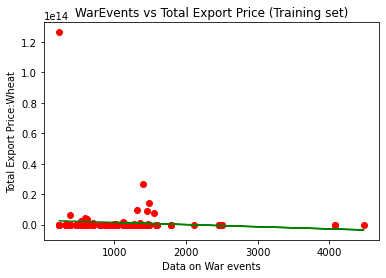

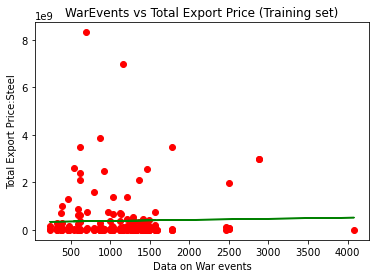

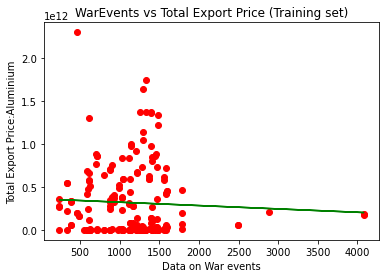

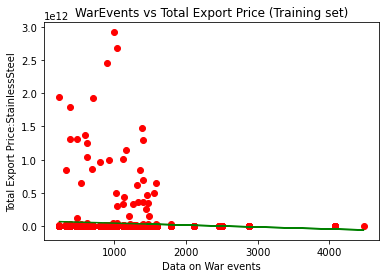

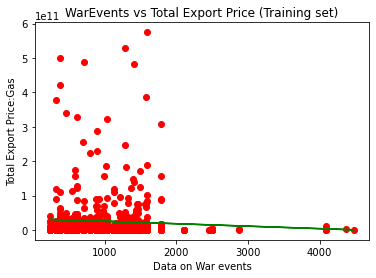

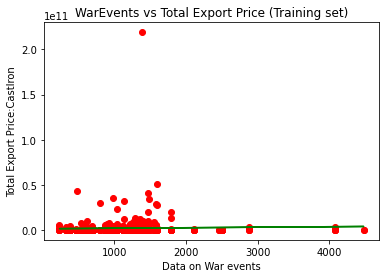

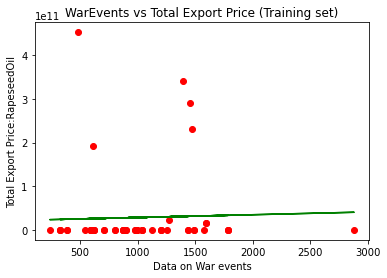

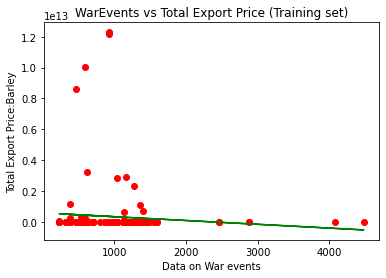

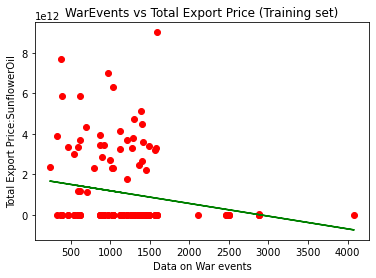

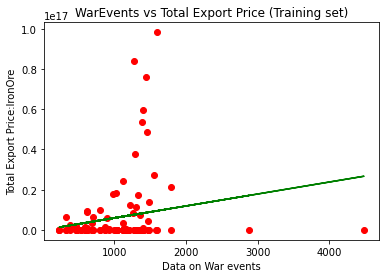

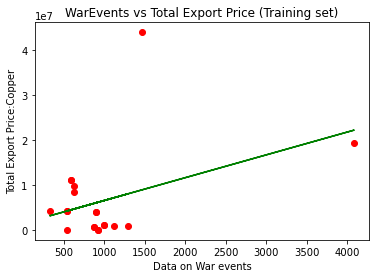

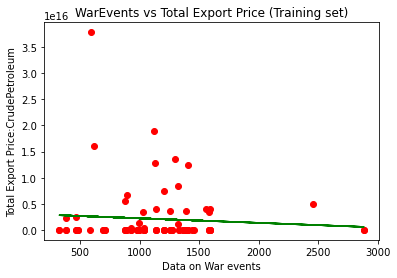

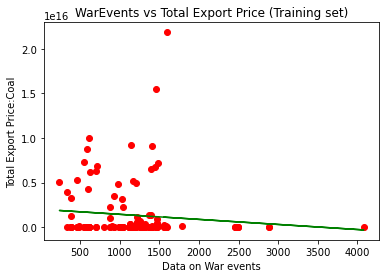

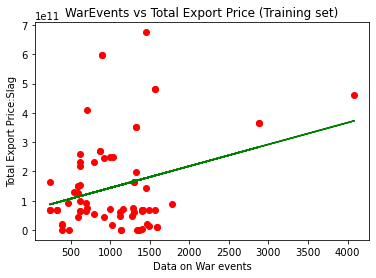

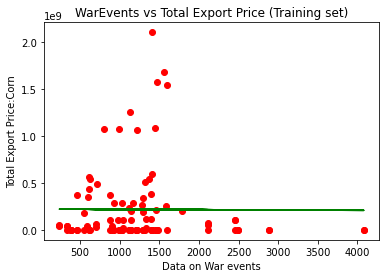

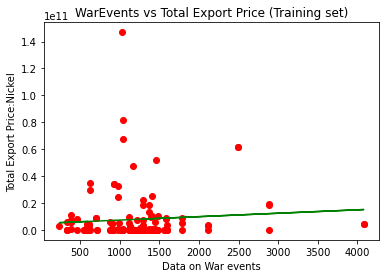

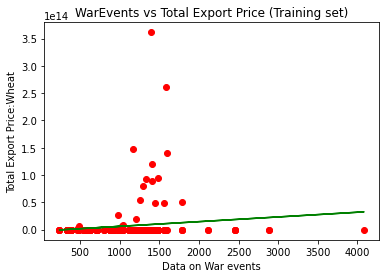

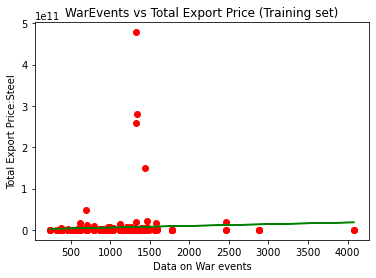

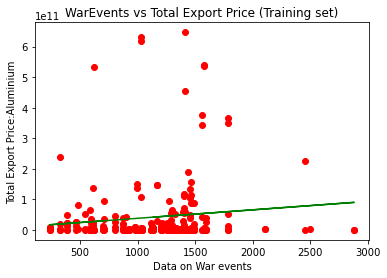

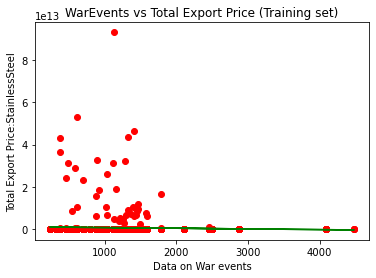

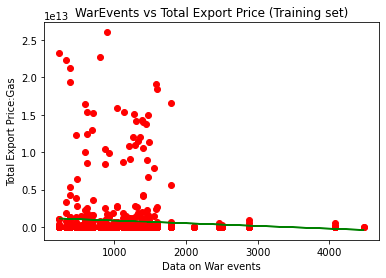

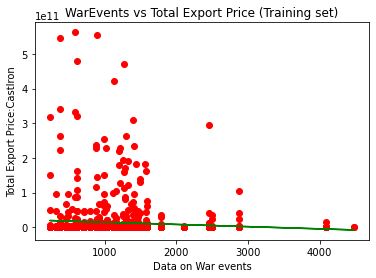

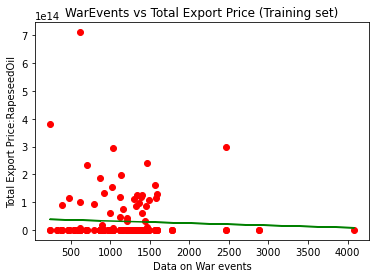

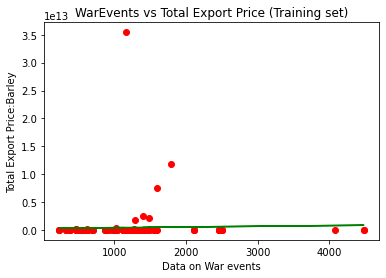

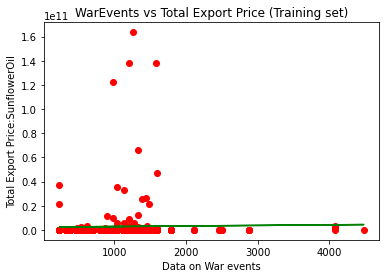

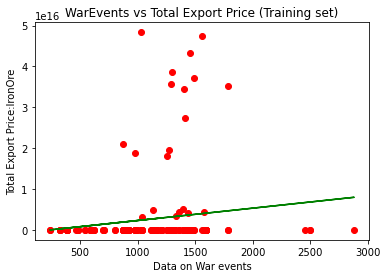

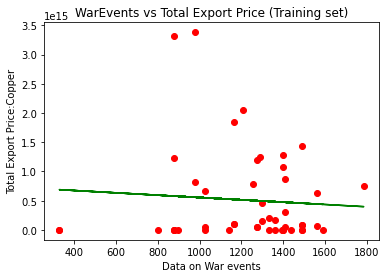

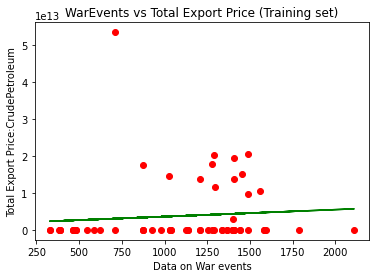

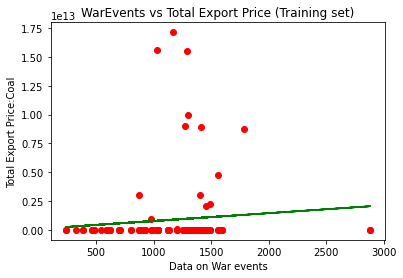

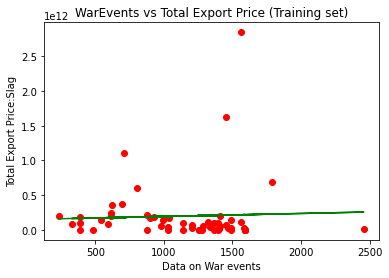

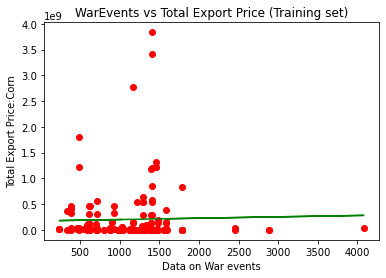

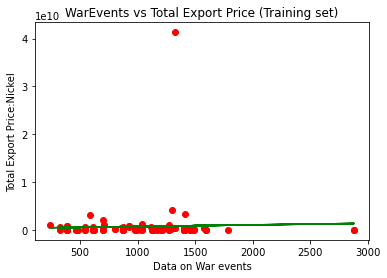

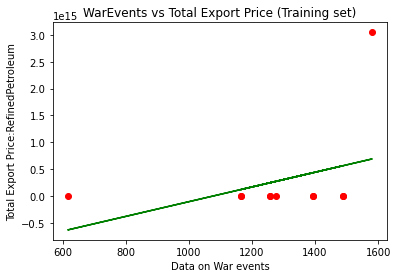

In [41]:
######################################################################################################################        
#                                              Linear Regression                                                     #
######################################################################################################################
linear_regression_model=LinearRegression()
features = ['COUNT_OF_EVENTS']
target = 'TOTAL_SOLD_USD'
for df_name in df_list:  
    # print(df_name.split("_")[1] + "_" + df_name.split("_")[3])
    if locals()[df_name].shape[0] > 1:
        
        X=locals()[df_name][features].values.reshape(-1, len(features))
        Y=locals()[df_name][target].values
        
        # X=locals()[df_name]['COUNT_OF_EVENTS'].values
        # Y=locals()[df_name]['TOTAL_SOLD_USD'].values
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=0)
######################################################################################################################        
#                                              Linear Regression                                                     #
######################################################################################################################
        clf=linear_regression_model.fit(x_train, y_train)
        # print("x_train",x_train)
        # print("y_train",y_train)
        # print("Coefficient/Slope : ", clf.coef_)
        # print("Intercept : ", clf.intercept_)
        linear_regression_predictions = linear_regression_model.predict(x_test)
        clf.score(x_test,y_test)
        linear_regression_model_mae=mean_absolute_error(y_test, linear_regression_predictions)
        linear_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, linear_regression_predictions))
        linear_regression_model_score=clf.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",linear_regression_model_mae)
        # print("RMSE: ",linear_regression_model_rmse)
        # print("Accuracy score of the model : ", linear_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3], 
            'Predictive_Analysis_Model': linear_regression_model.__class__.__name__,
            'Accuracy_Score': linear_regression_model_score,
            'Mean_Absolute_Error' : linear_regression_model_mae,
            'Root_Mean_Squared_Error':linear_regression_model_rmse
        }, ignore_index=True)
        
        plt.scatter(x_train, y_train, color = "red")
        plt.plot(x_train, linear_regression_model.predict(x_train), color = "green")
        plt.title("WarEvents vs Total Export Price (Training set)")
        plt.xlabel("Data on War events")
        plt.ylabel("Total Export Price:" + df_name.split("_")[3])
        plt.show()

df_Ukraine_commodity_Wheat
df_Ukraine_commodity_Steel
df_Ukraine_commodity_Aluminium
df_Ukraine_commodity_StainlessSteel
df_Ukraine_commodity_Gas
df_Ukraine_commodity_CastIron
df_Ukraine_commodity_RapeseedOil
df_Ukraine_commodity_Barley
df_Ukraine_commodity_SunflowerOil
df_Ukraine_commodity_IronOre
df_Ukraine_commodity_Copper
df_Ukraine_commodity_CrudePetroleum
df_Ukraine_commodity_Coal
df_Ukraine_commodity_Slag
df_Ukraine_commodity_Corn
df_Ukraine_commodity_Nickel
df_RussianFederation_commodity_Wheat
df_RussianFederation_commodity_Steel
df_RussianFederation_commodity_Aluminium
df_RussianFederation_commodity_StainlessSteel
df_RussianFederation_commodity_Gas
df_RussianFederation_commodity_CastIron
df_RussianFederation_commodity_RapeseedOil
df_RussianFederation_commodity_Barley
df_RussianFederation_commodity_SunflowerOil
df_RussianFederation_commodity_IronOre
df_RussianFederation_commodity_Copper
df_RussianFederation_commodity_CrudePetroleum
df_RussianFederation_commodity_Coal
df_Russian

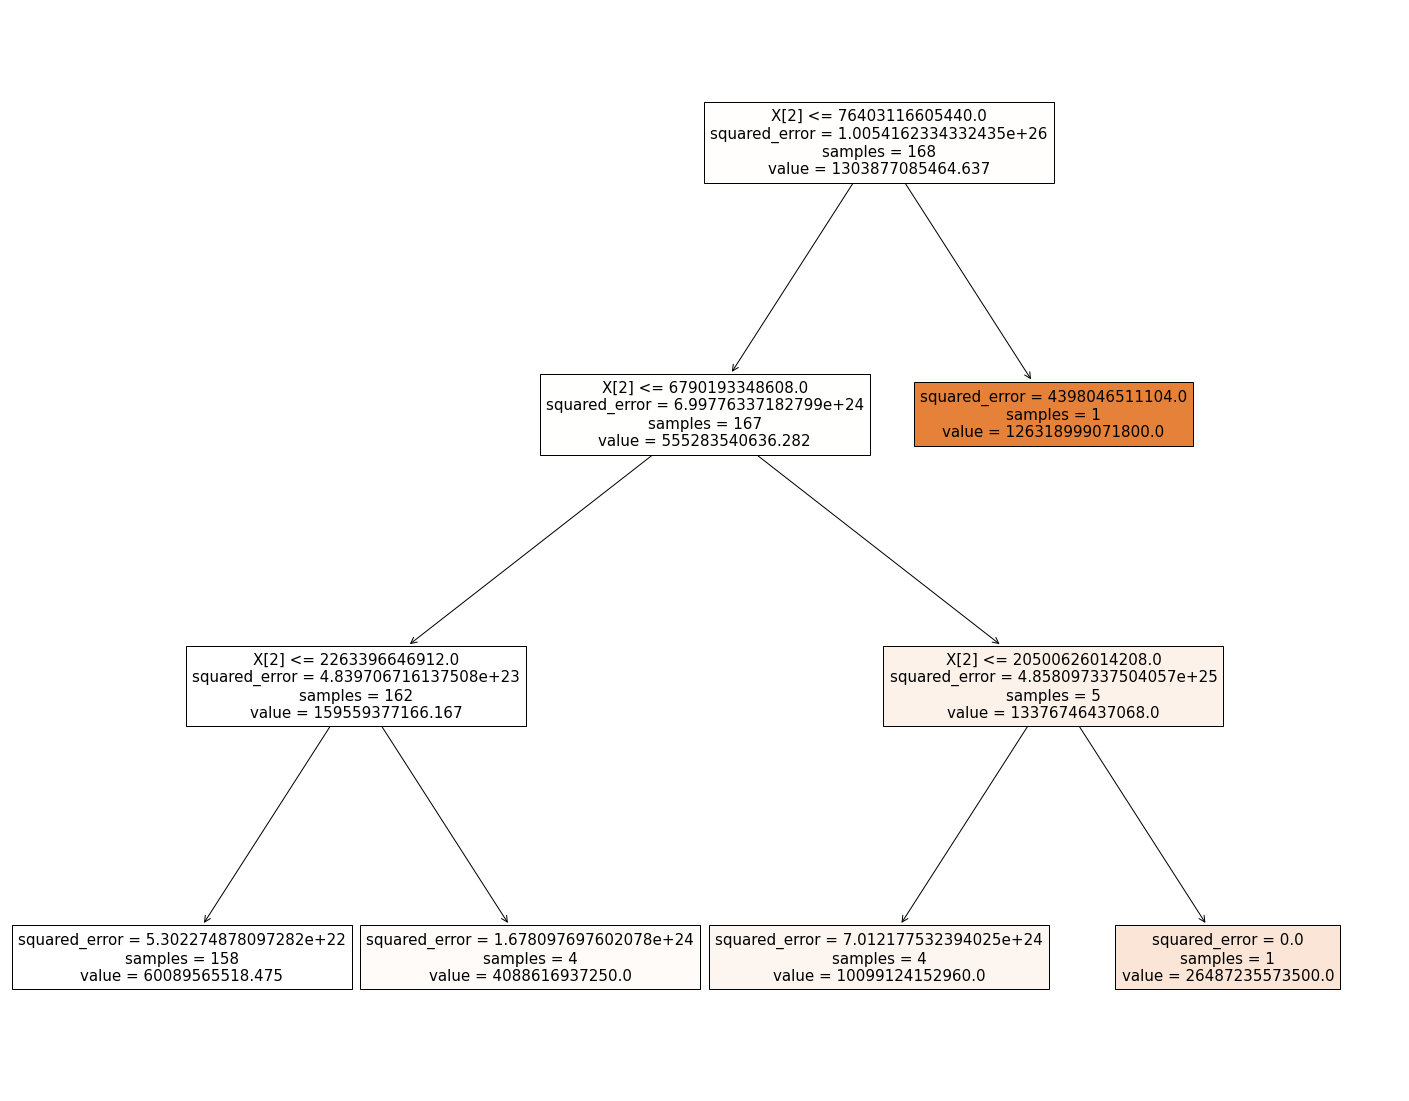

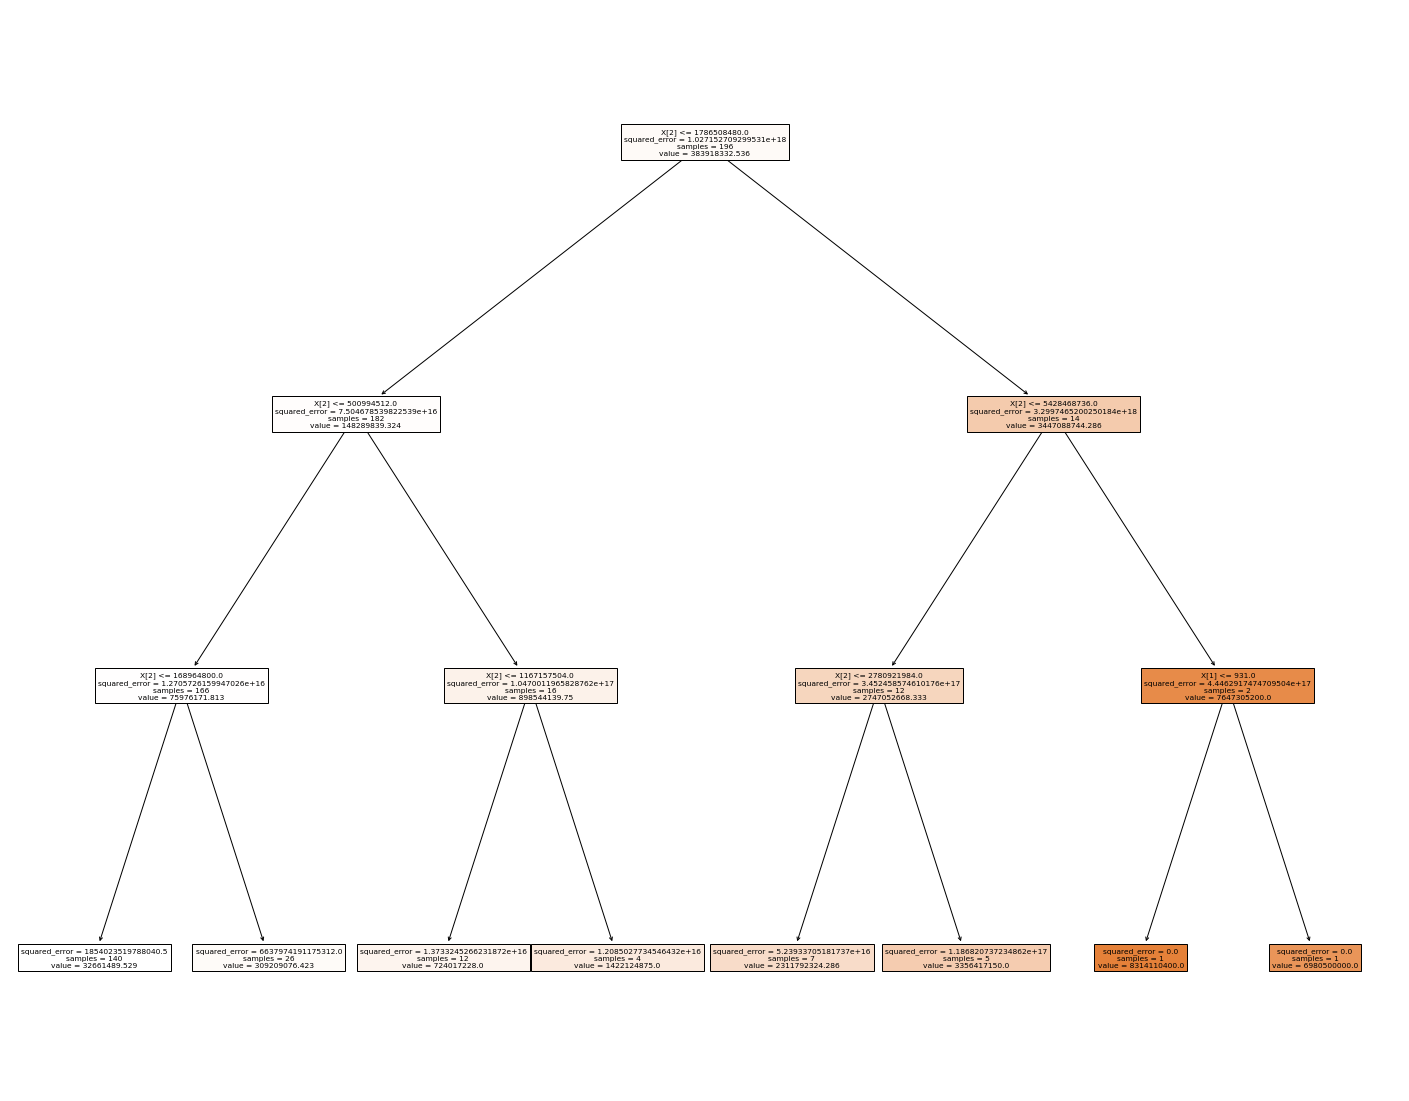

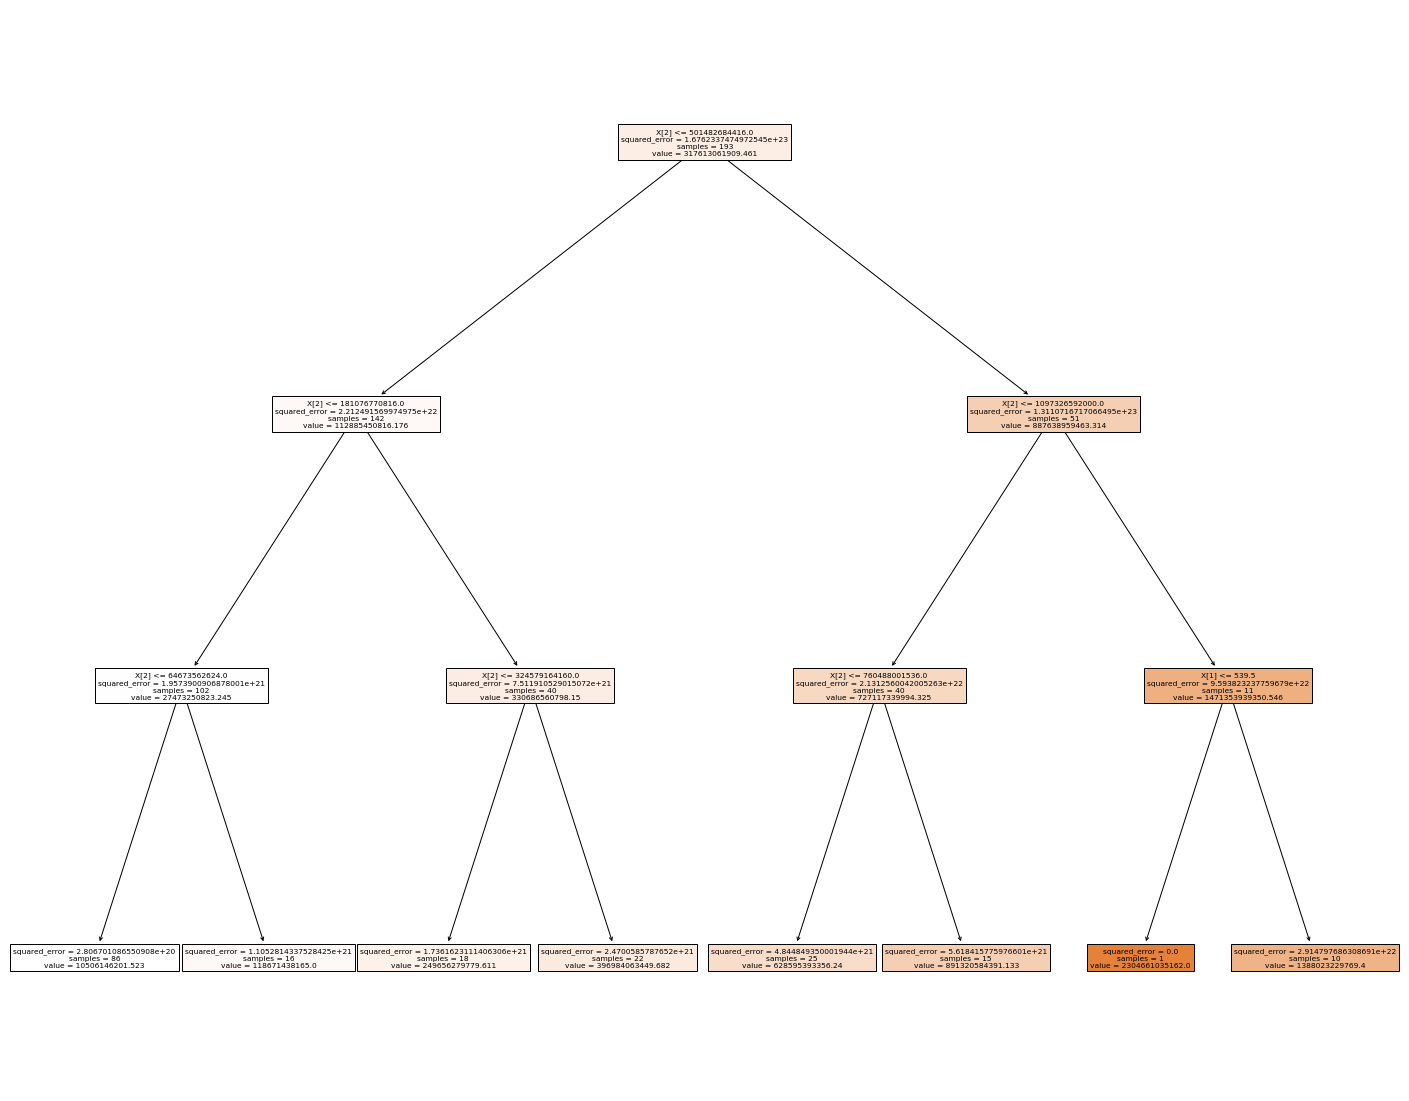

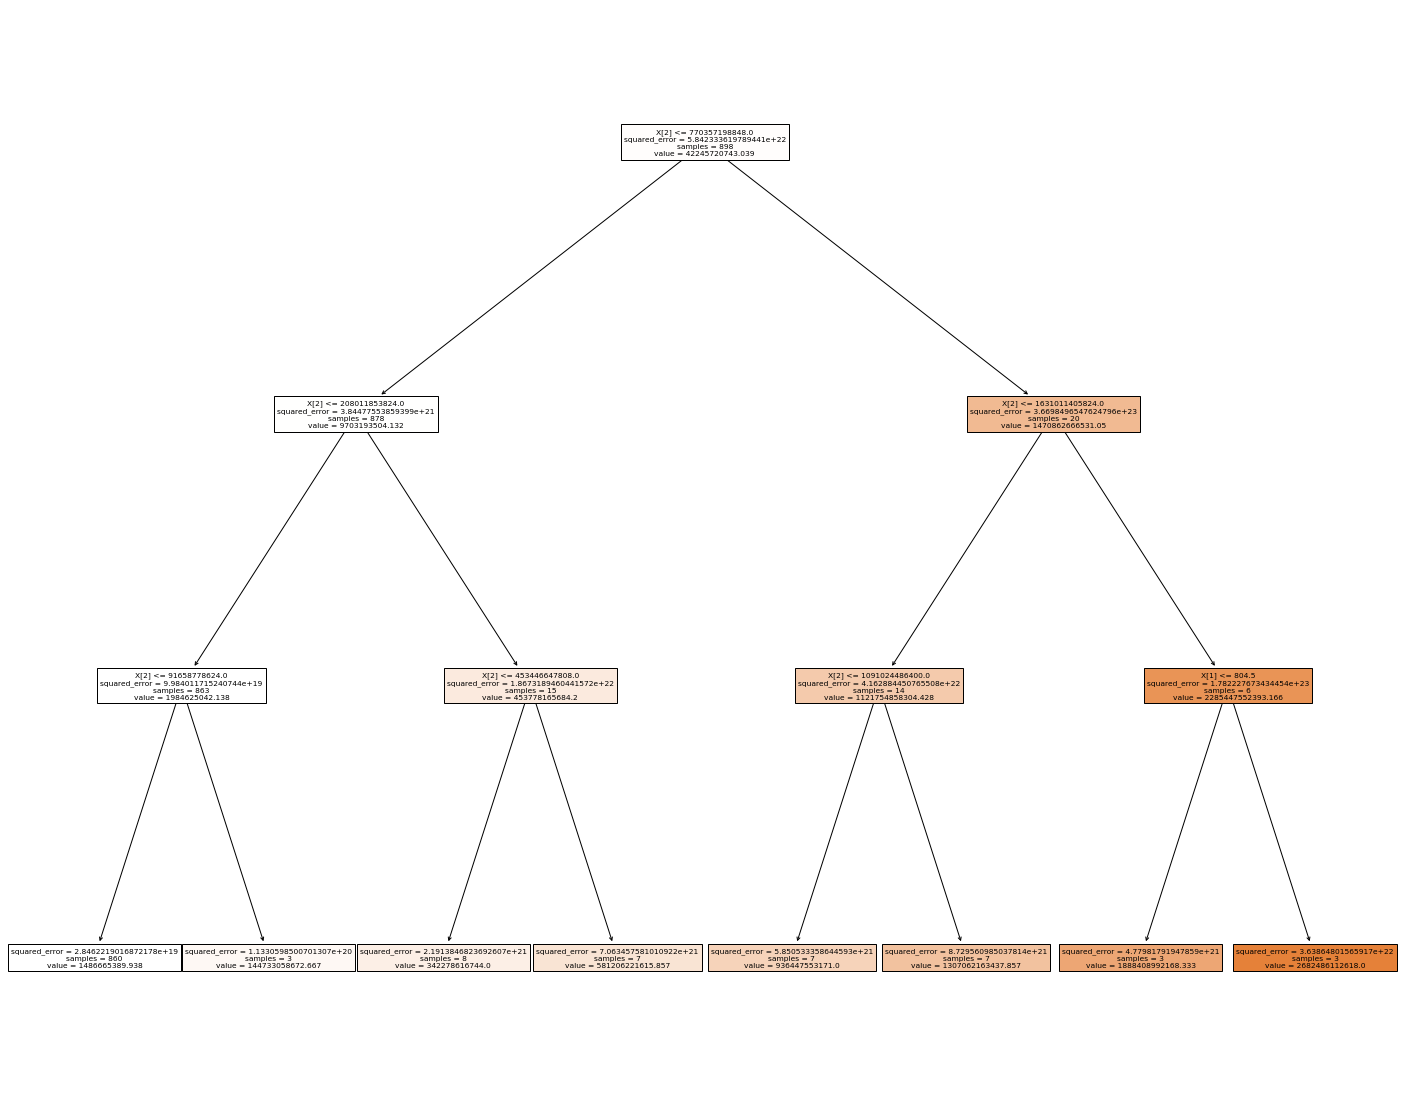

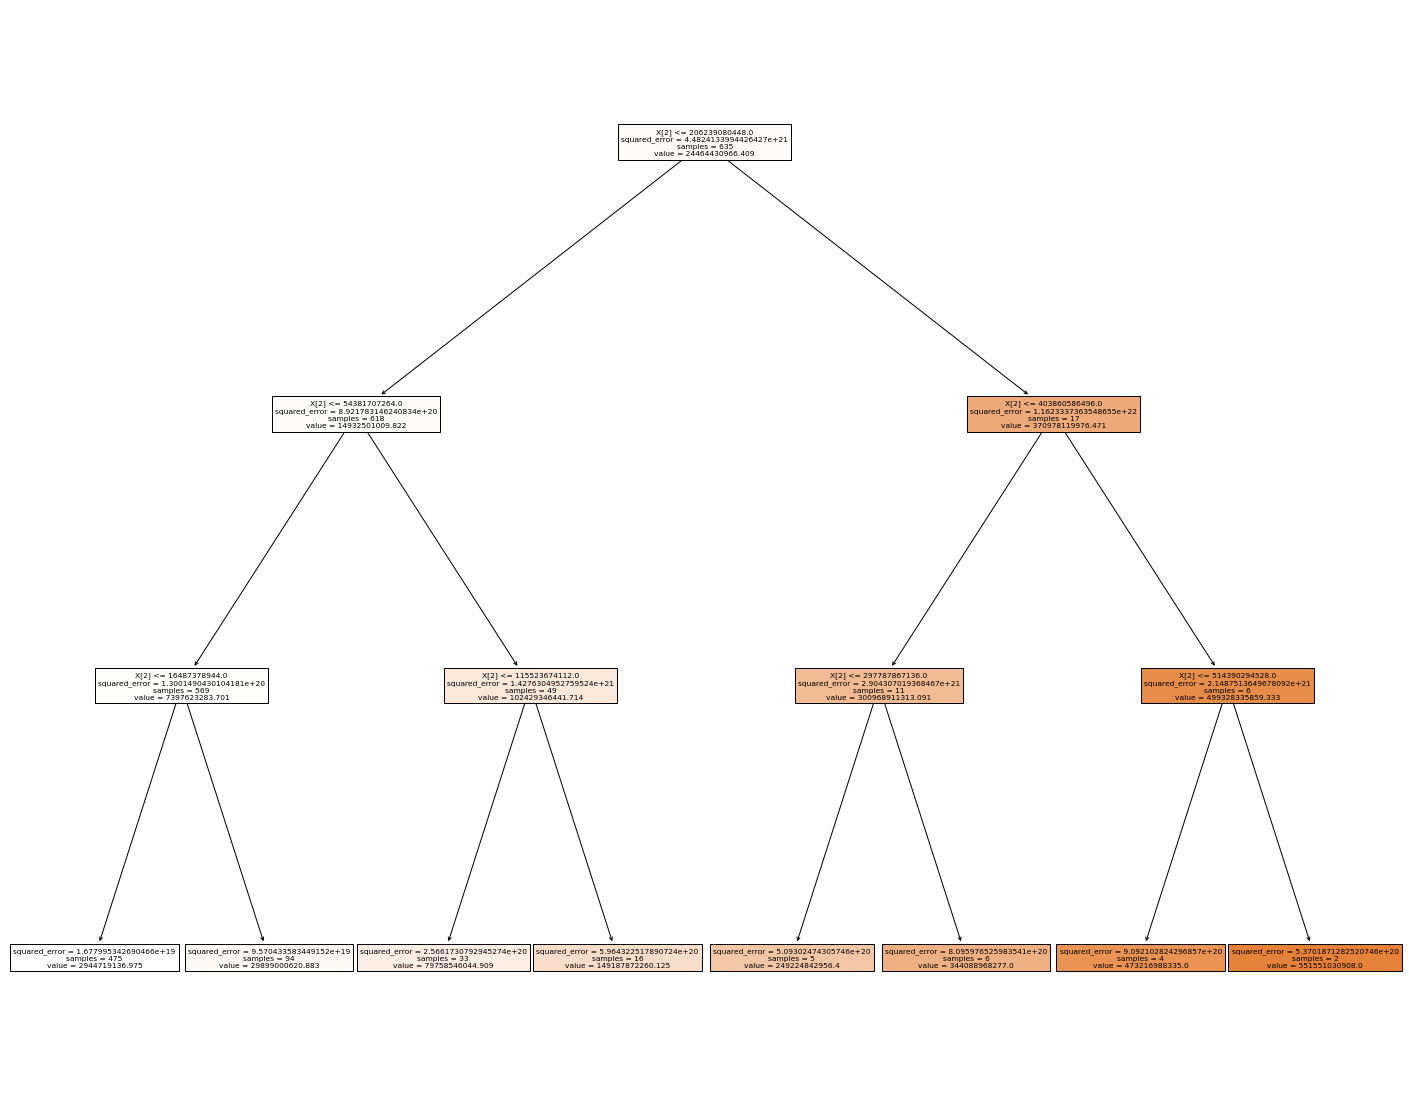

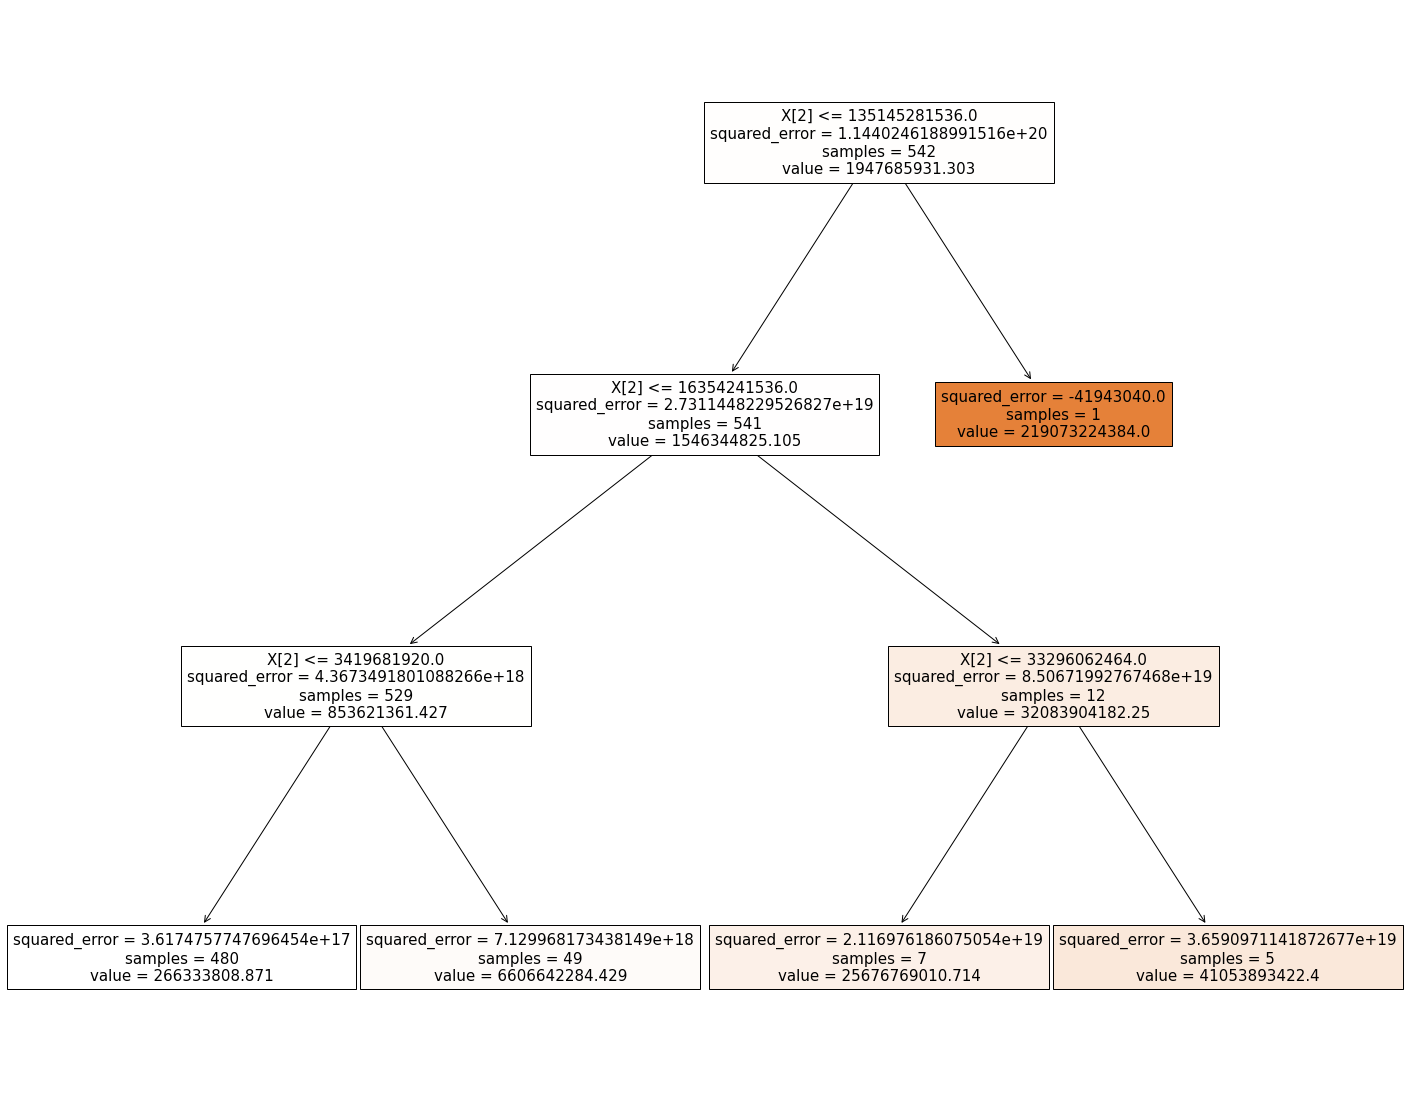

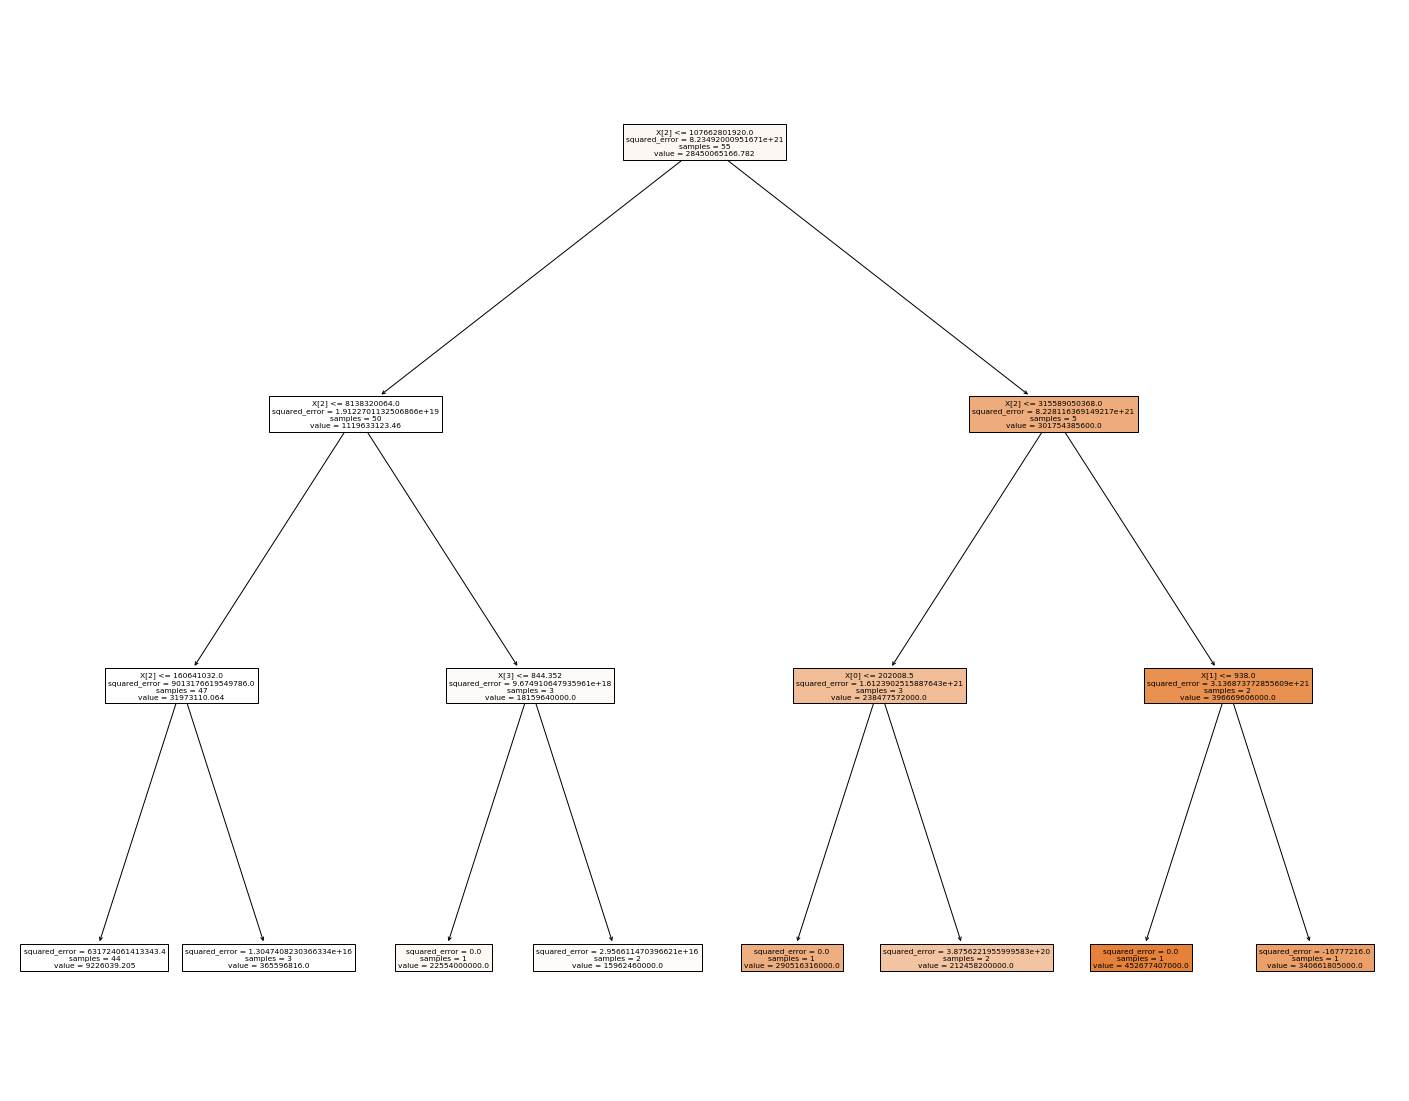

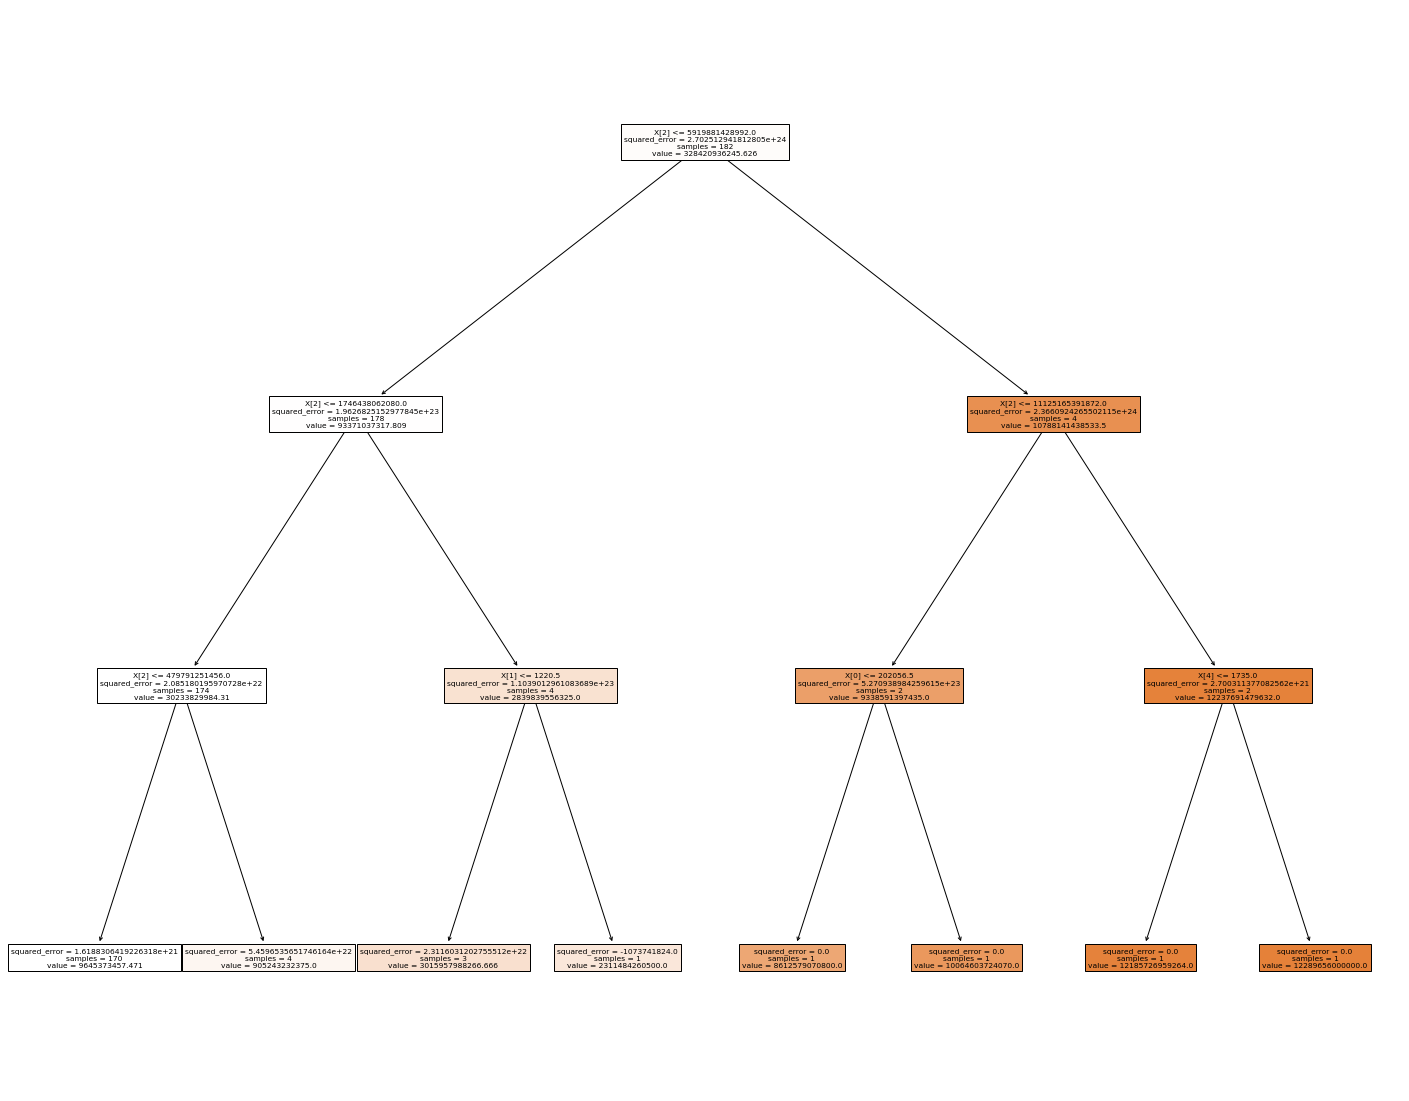

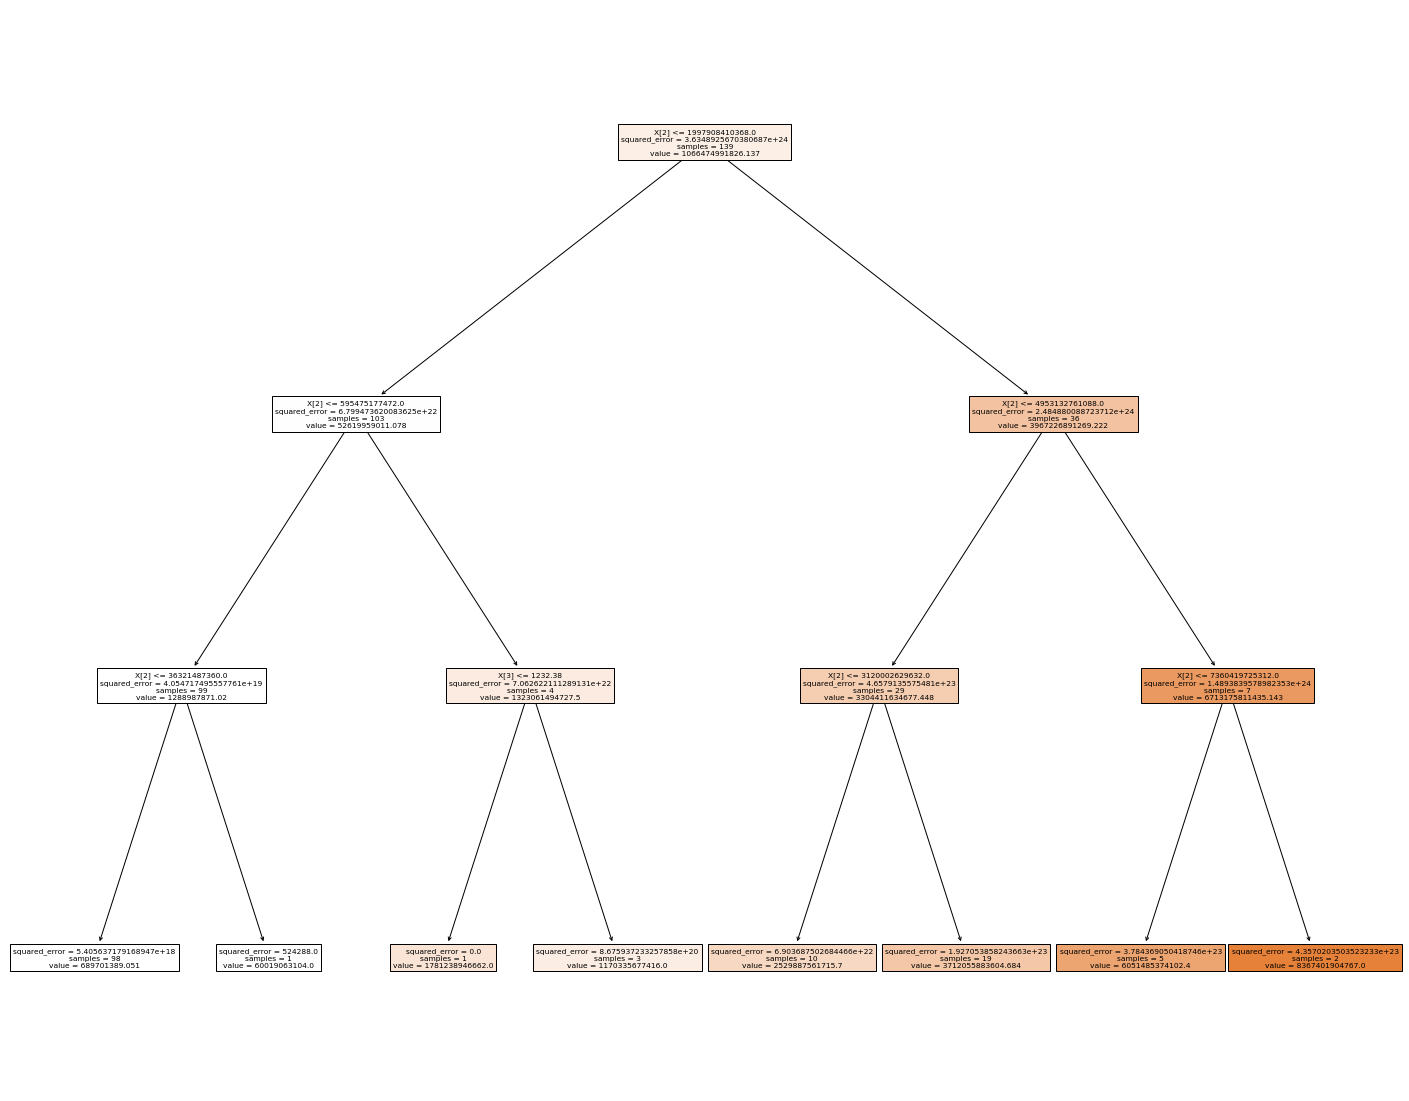

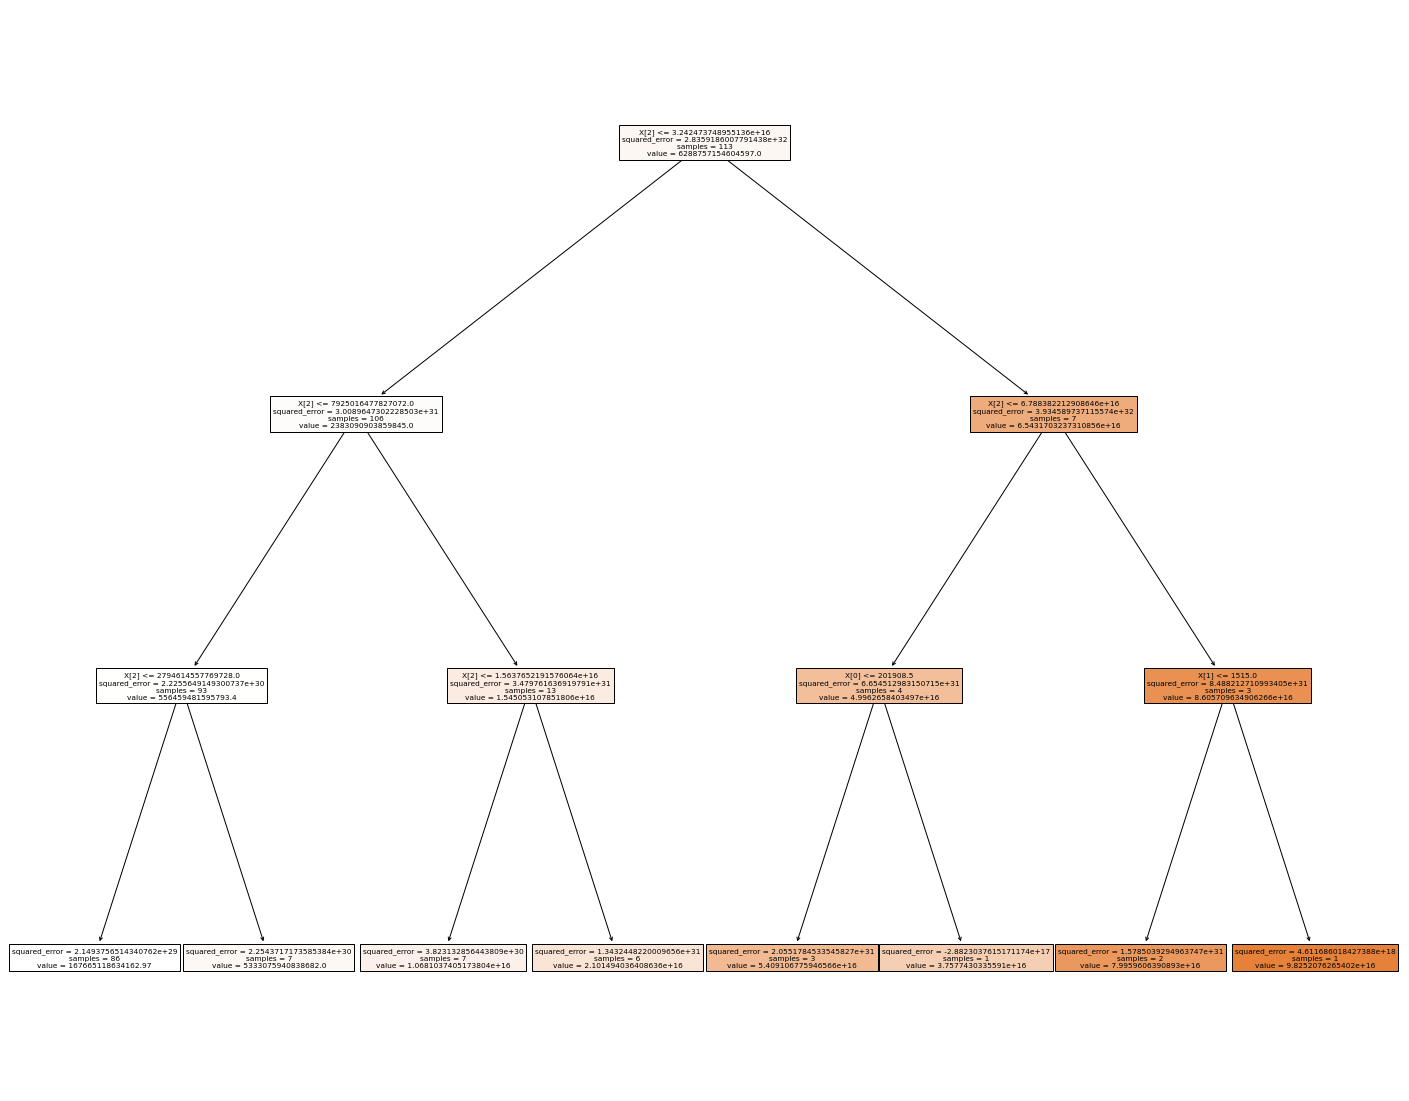

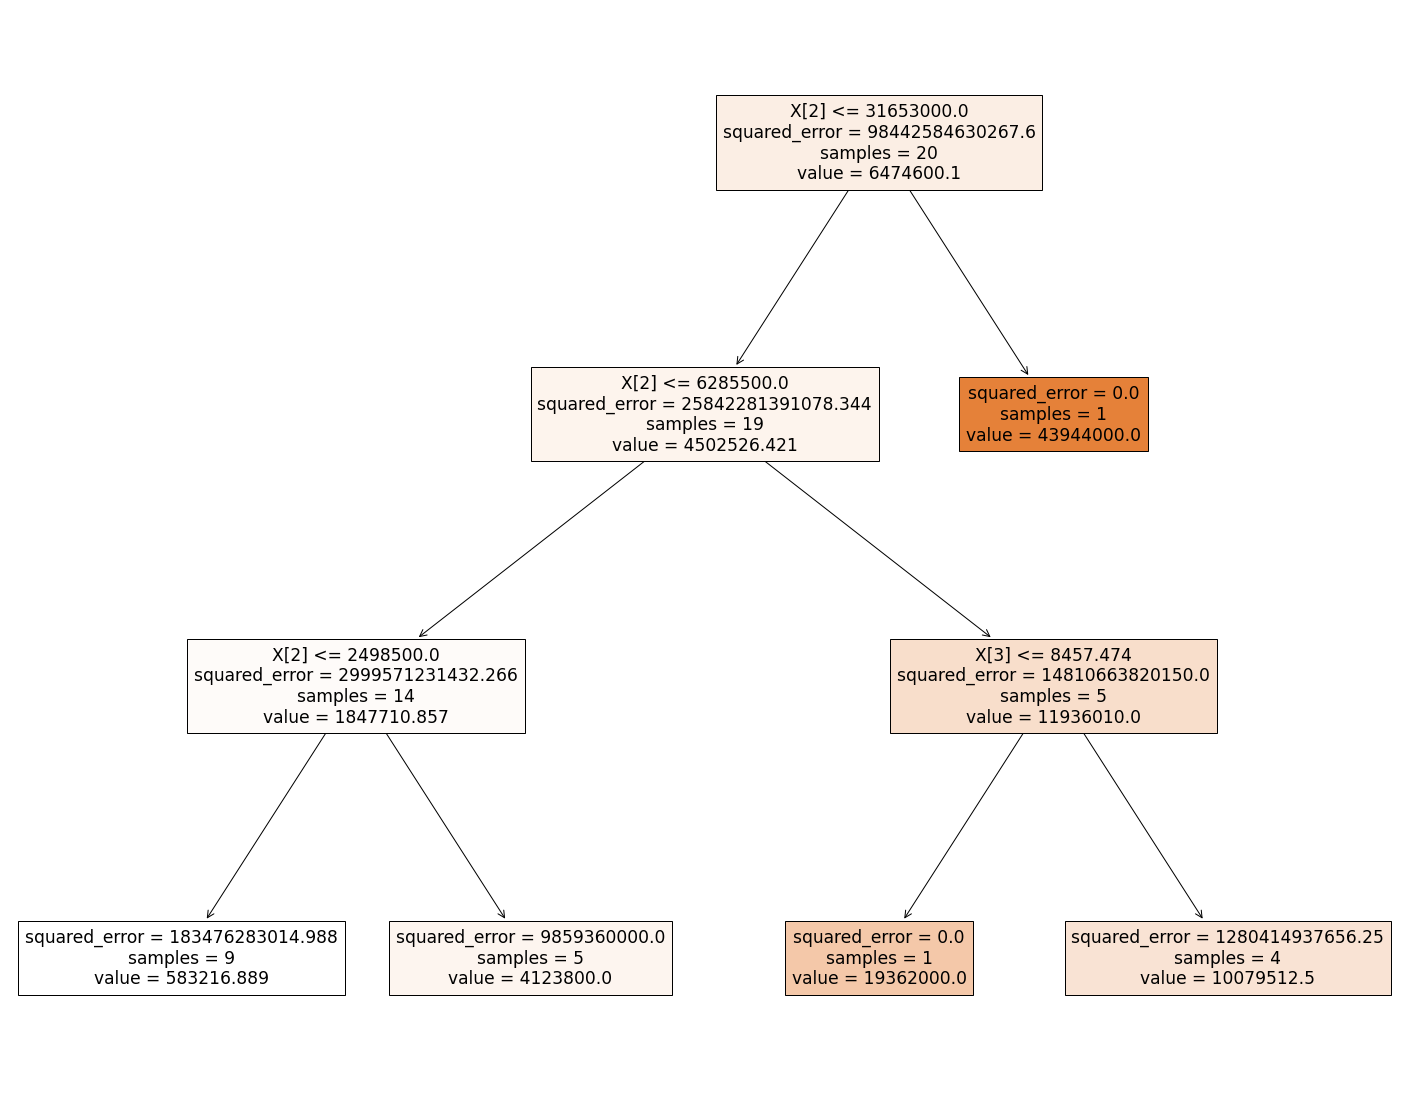

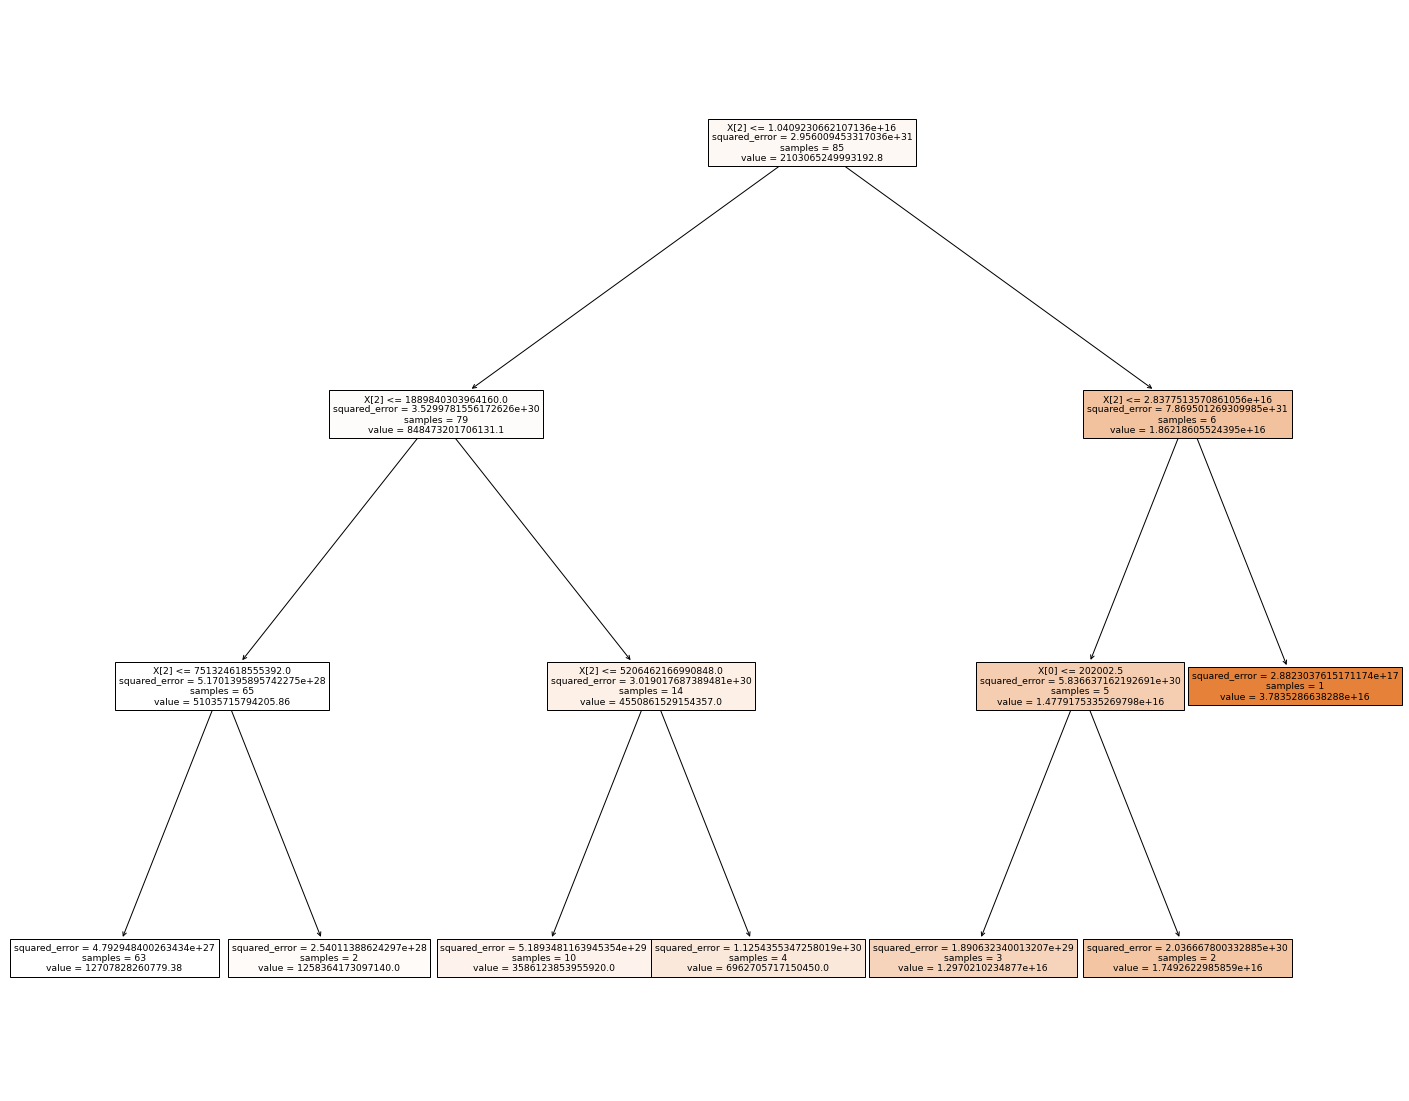

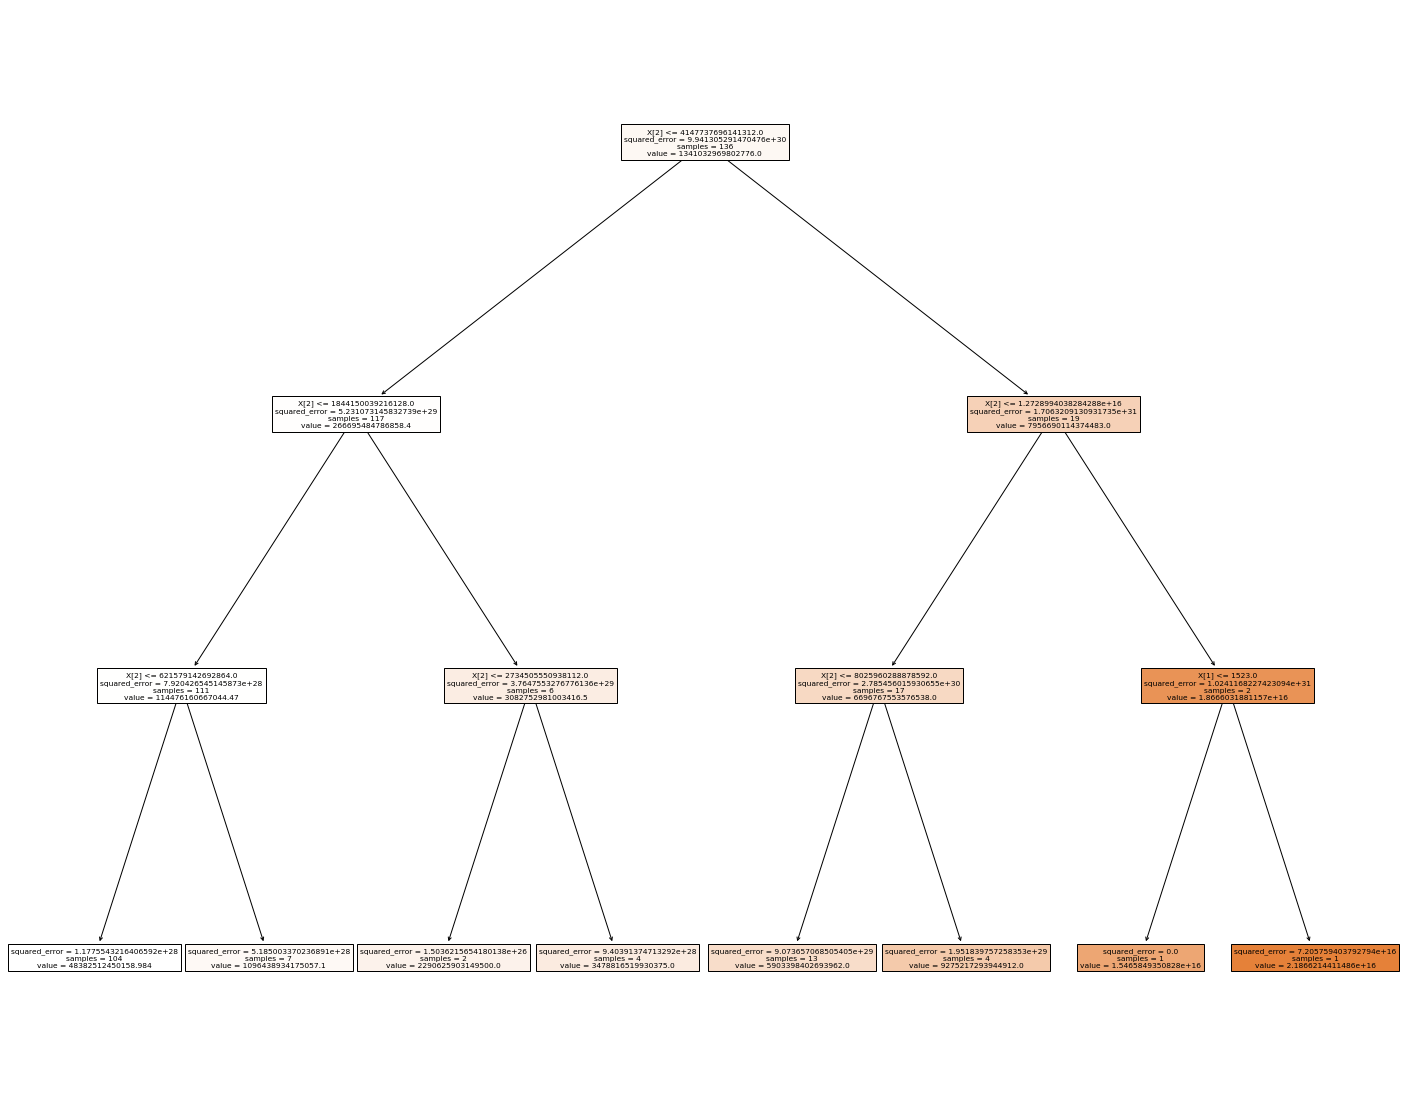

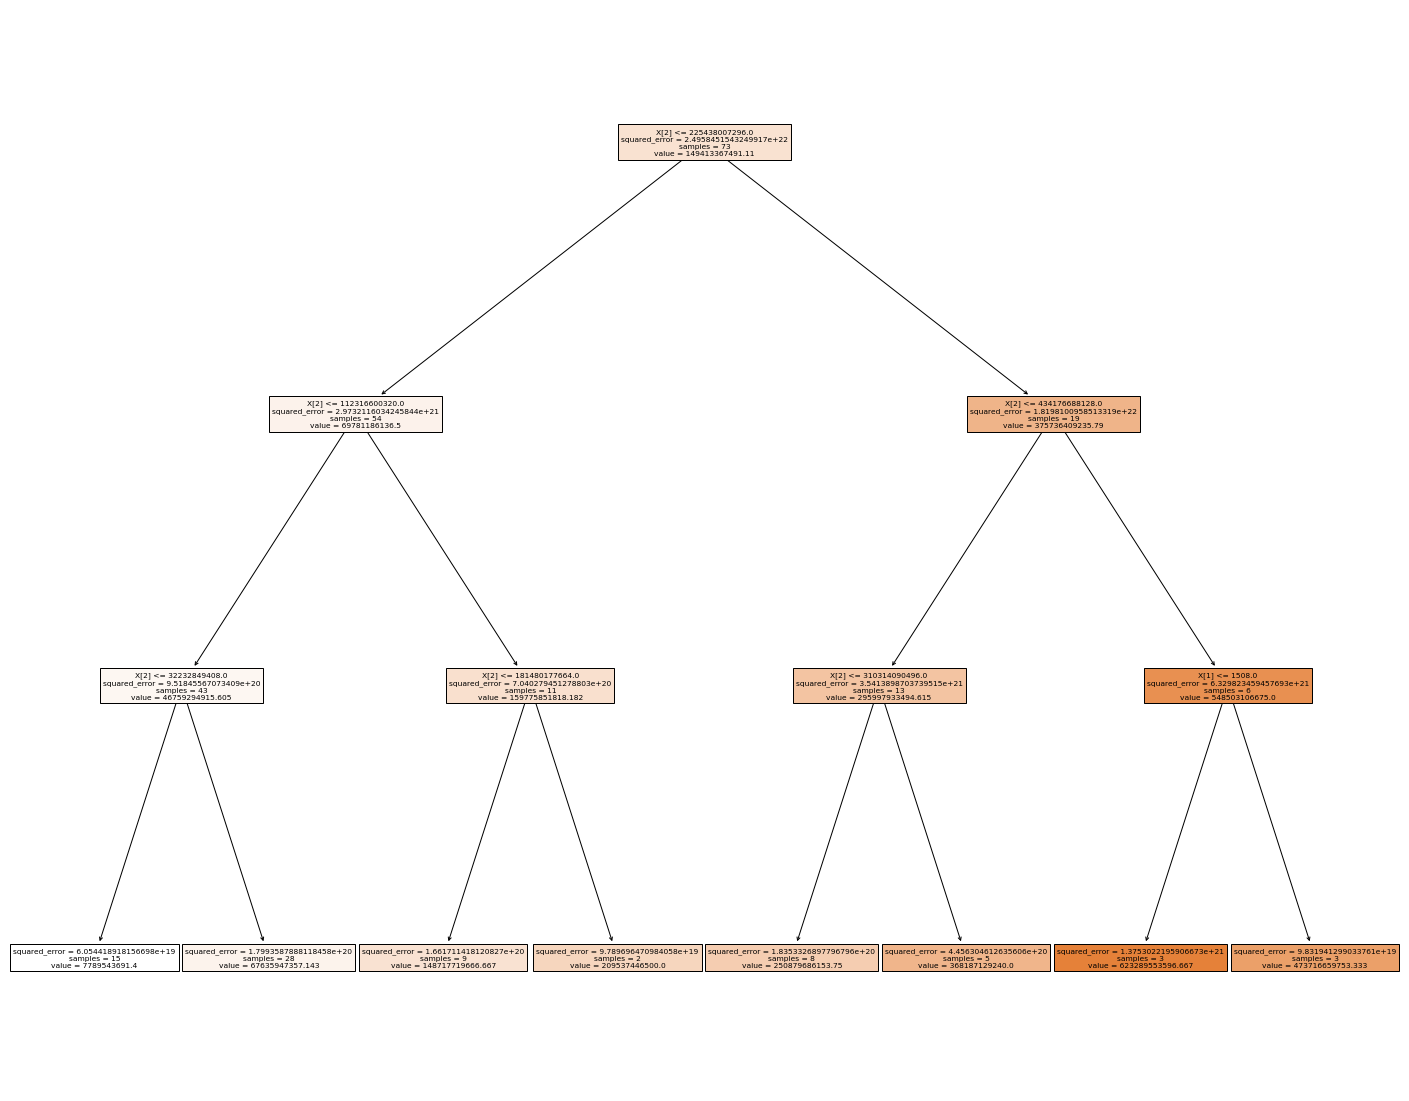

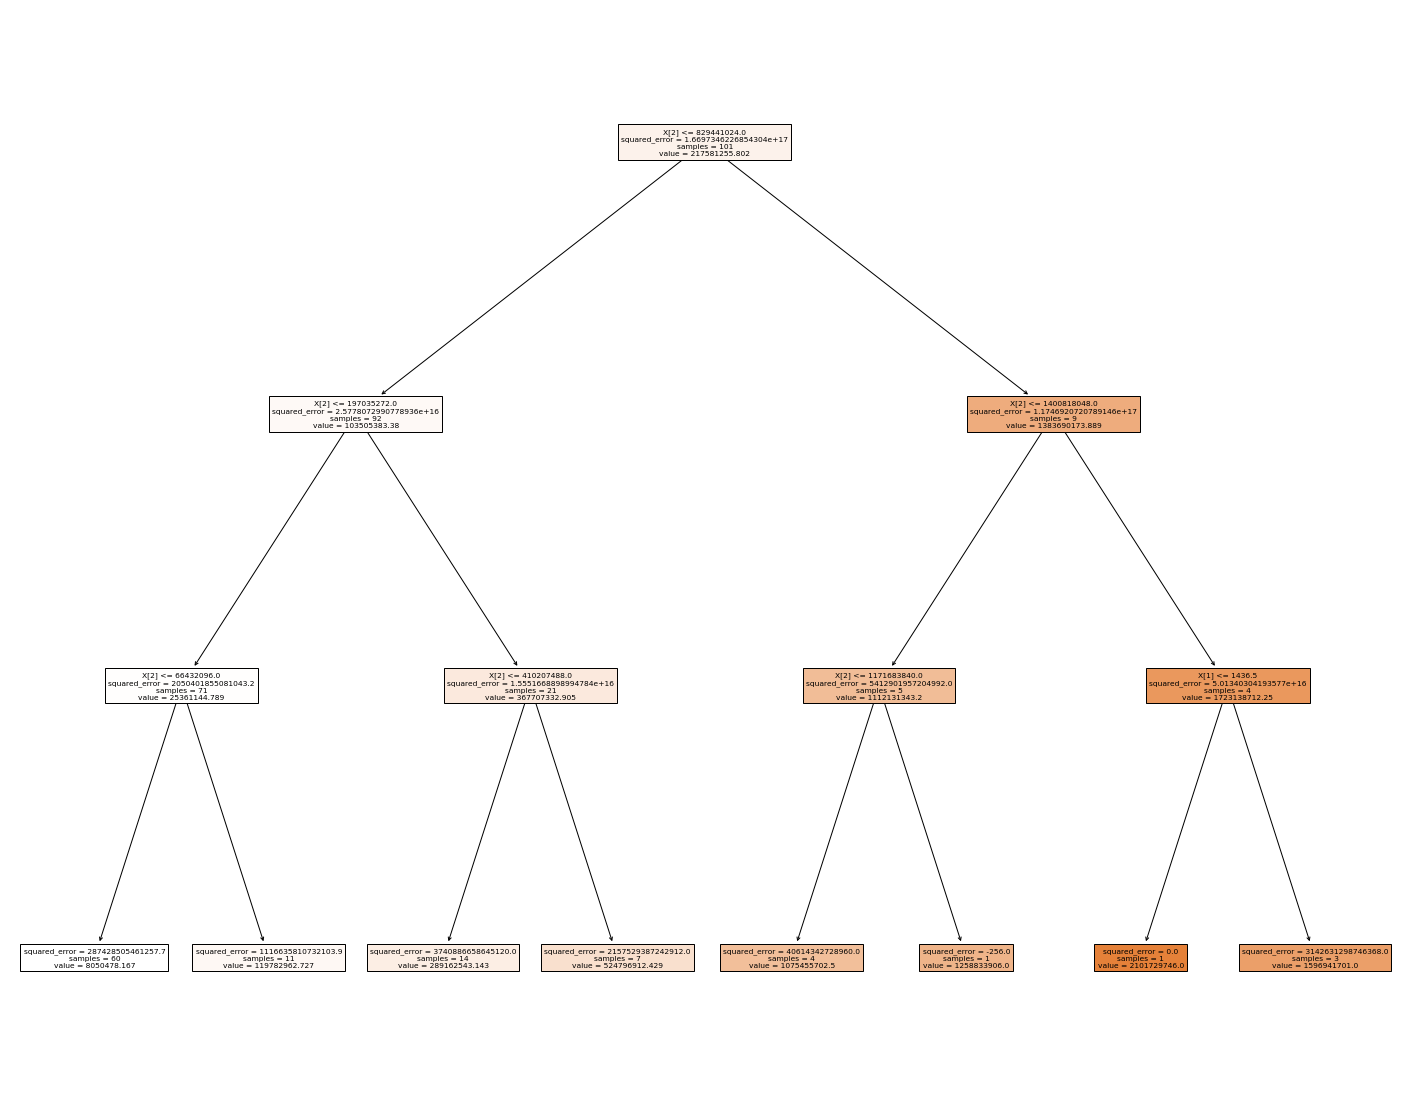

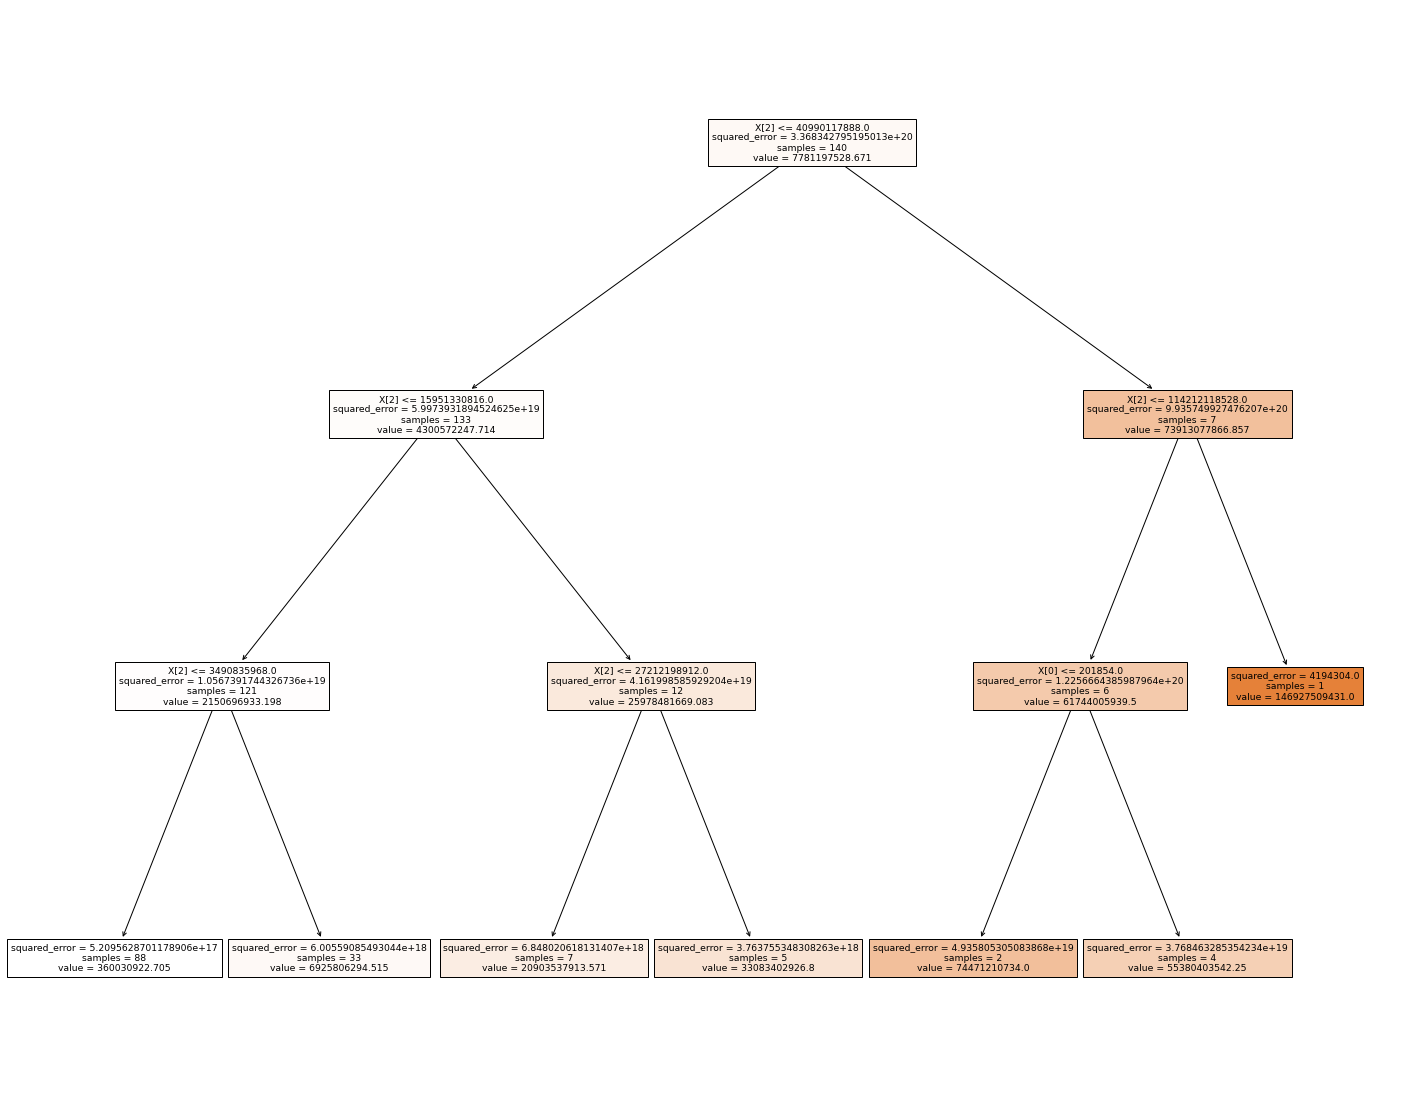

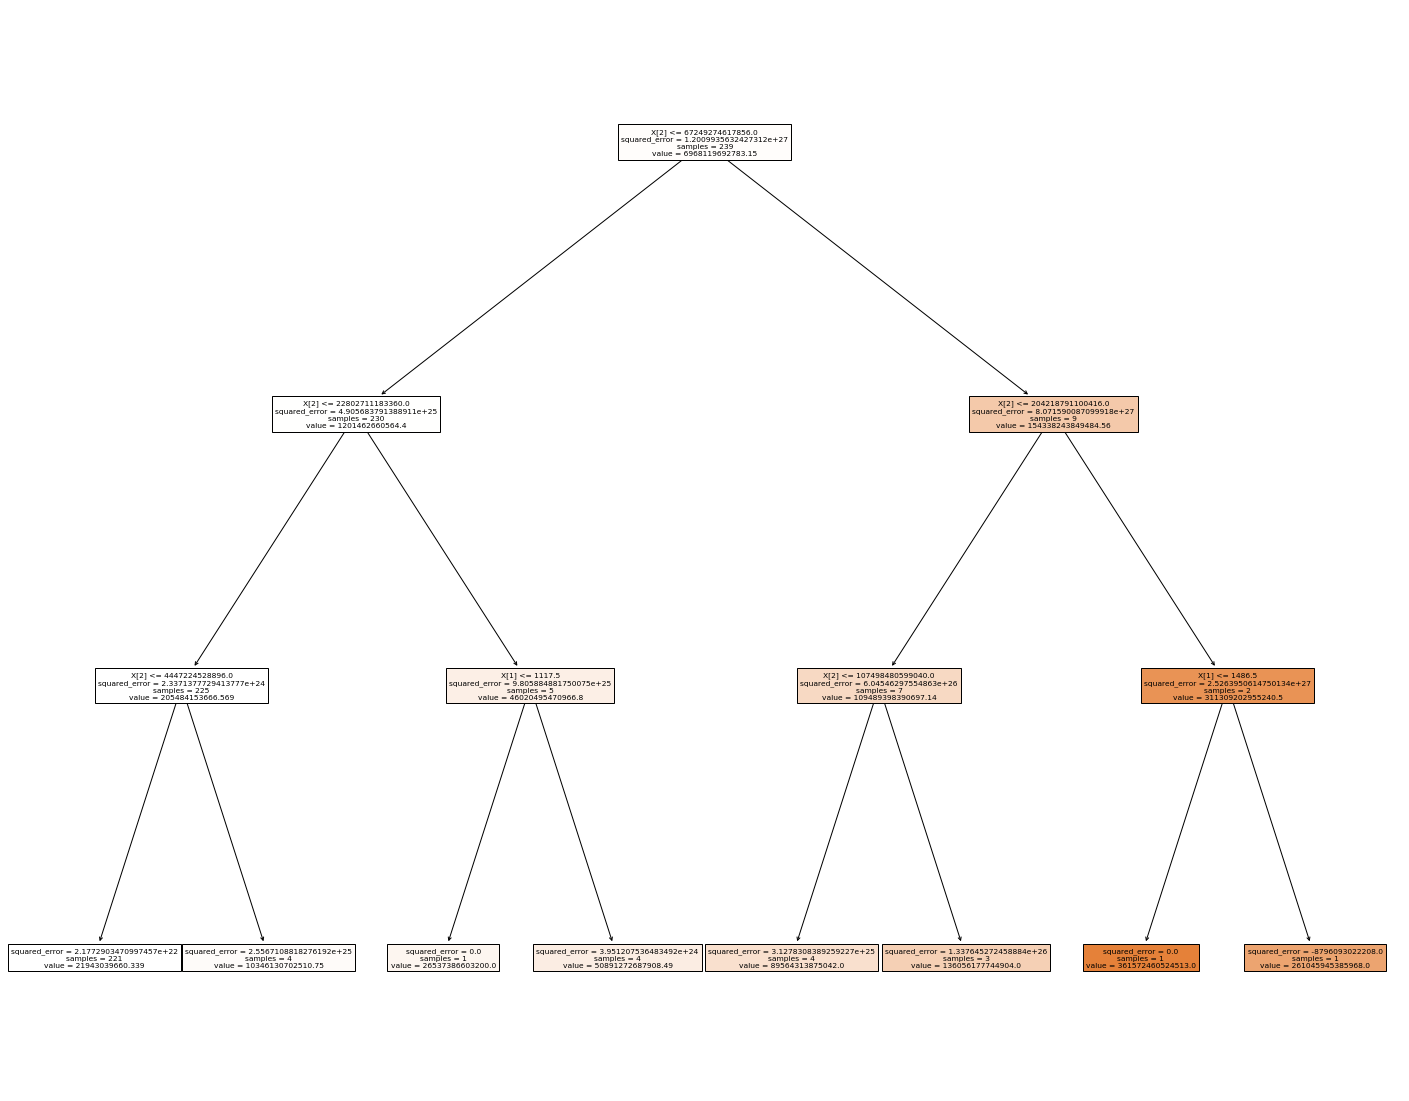

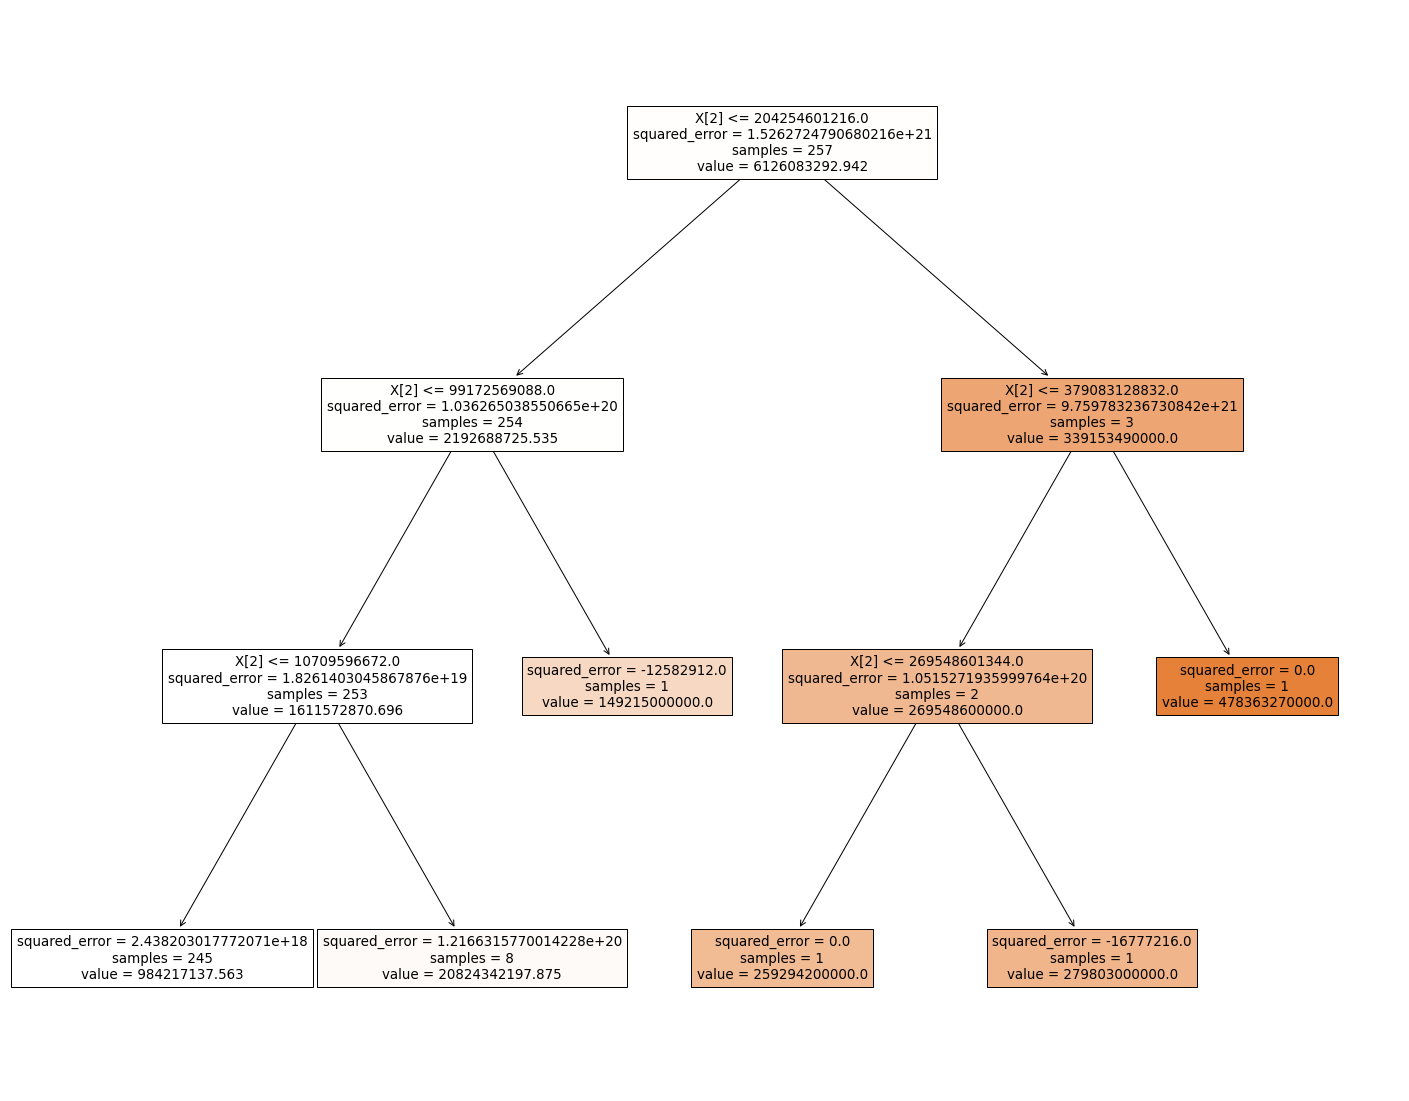

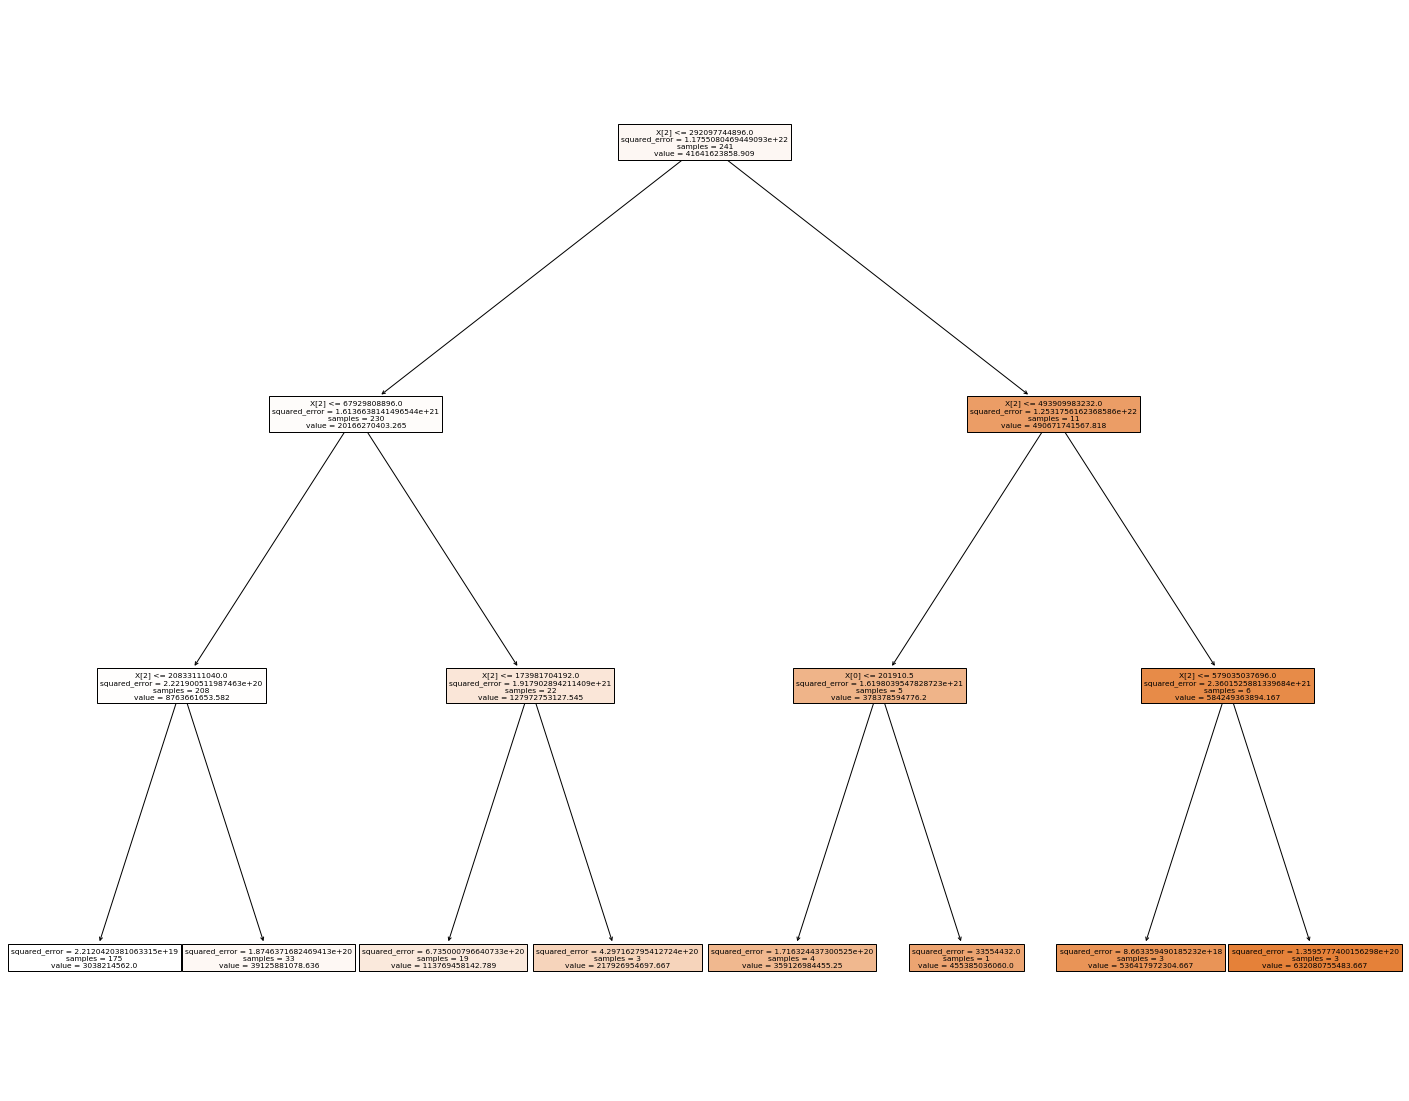

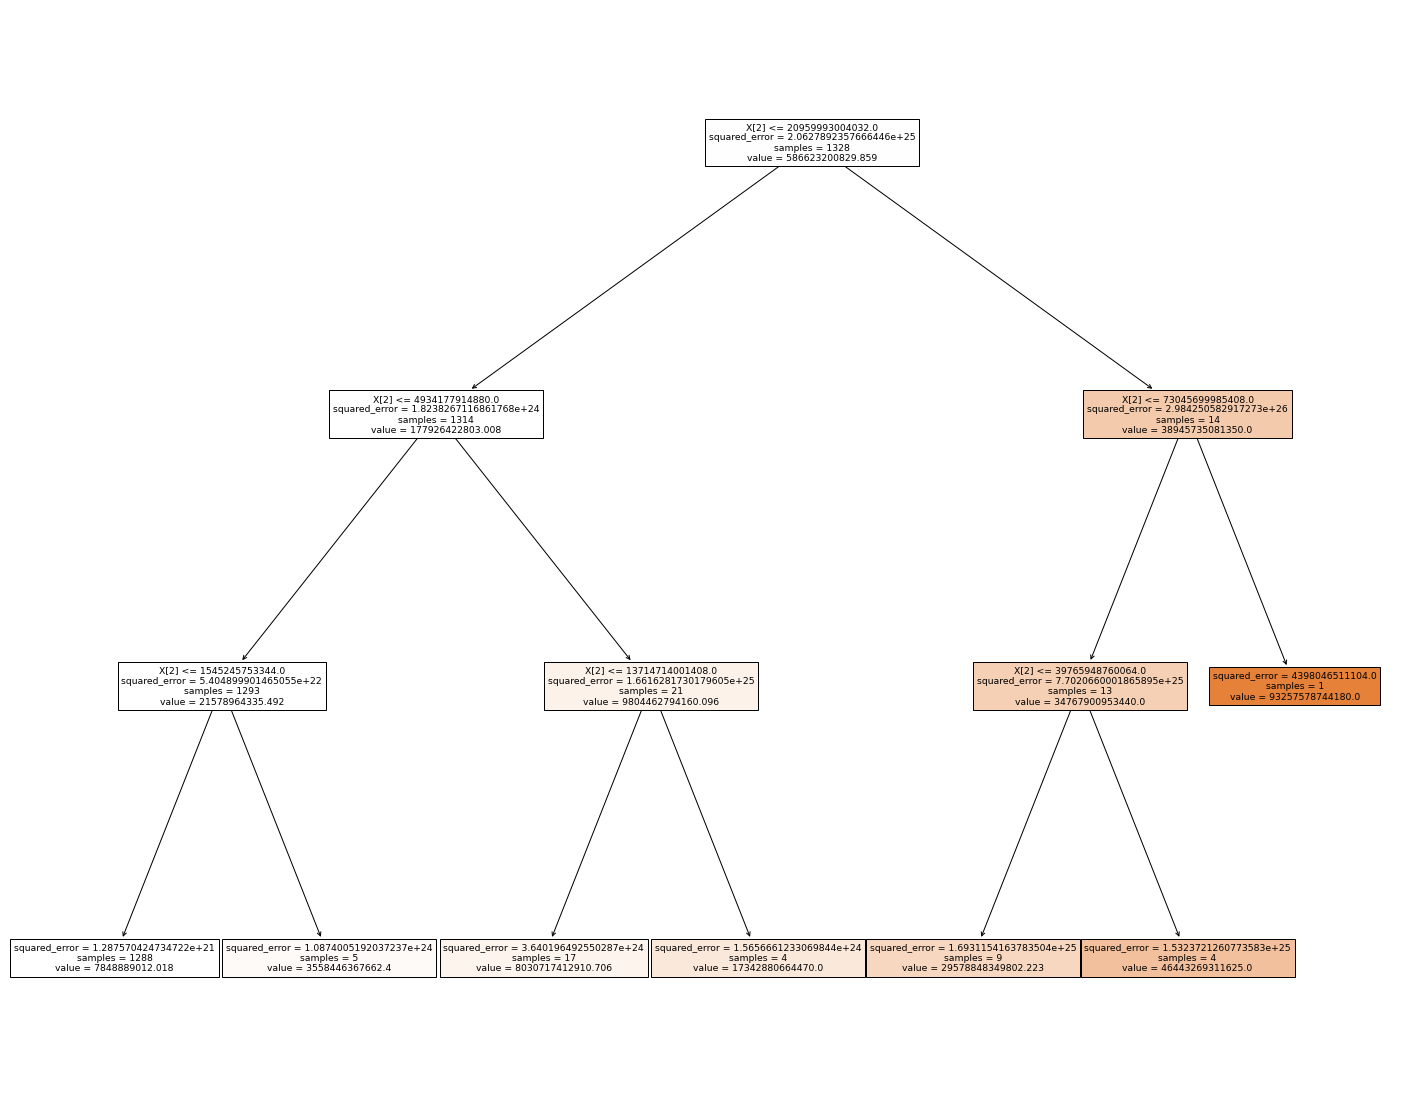

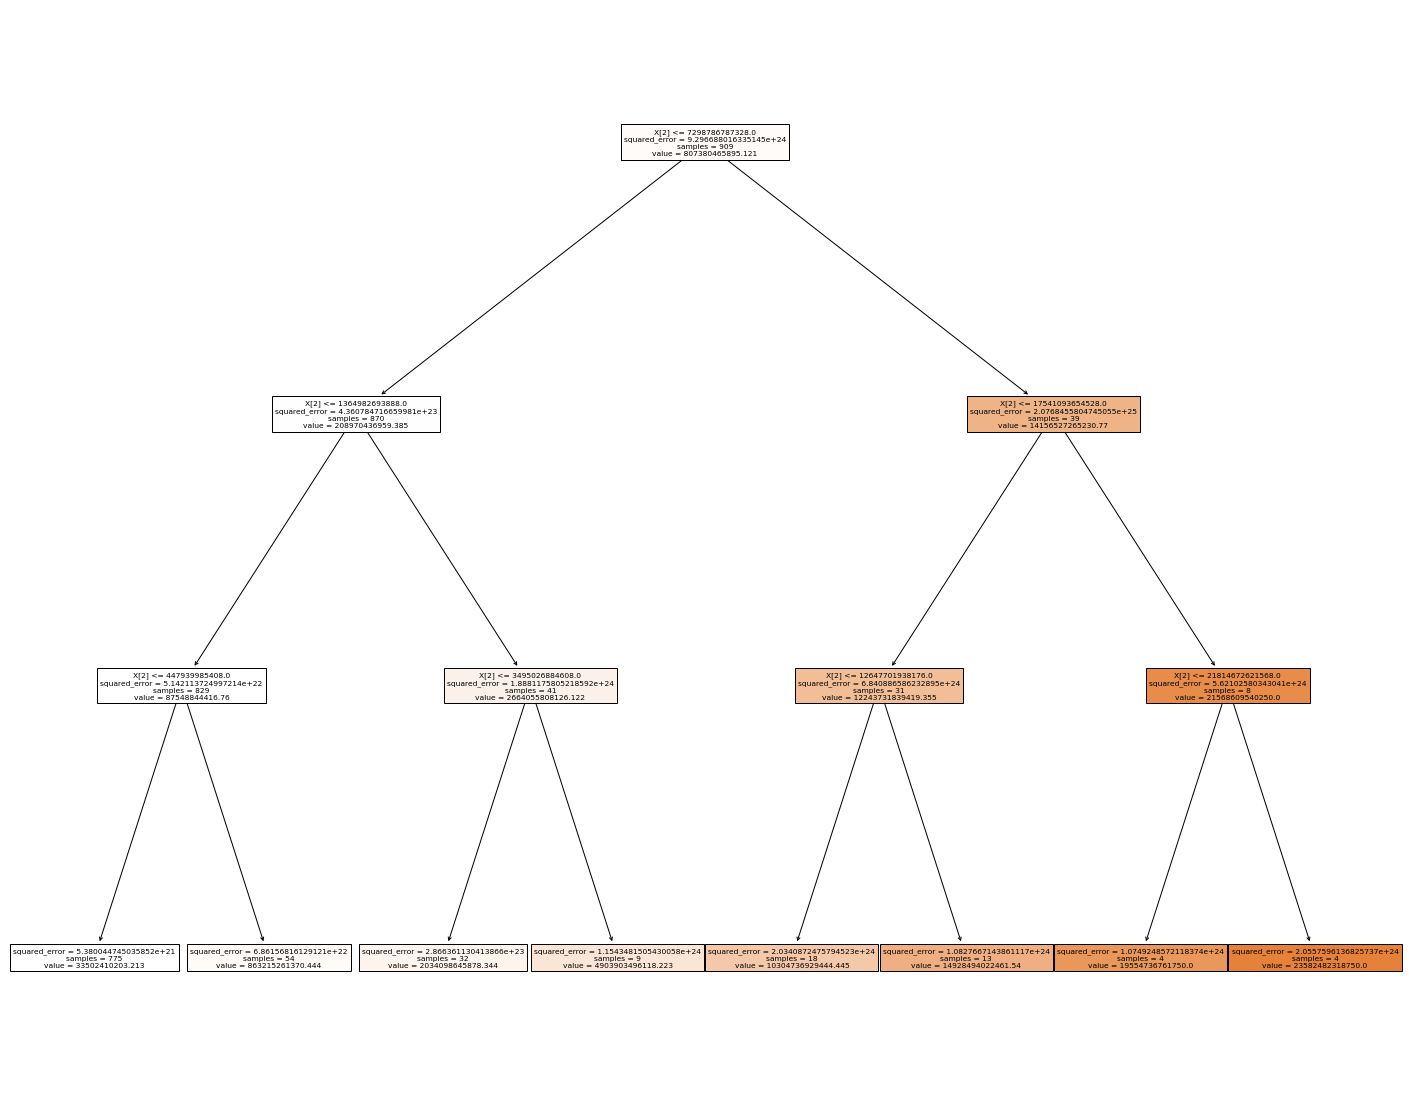

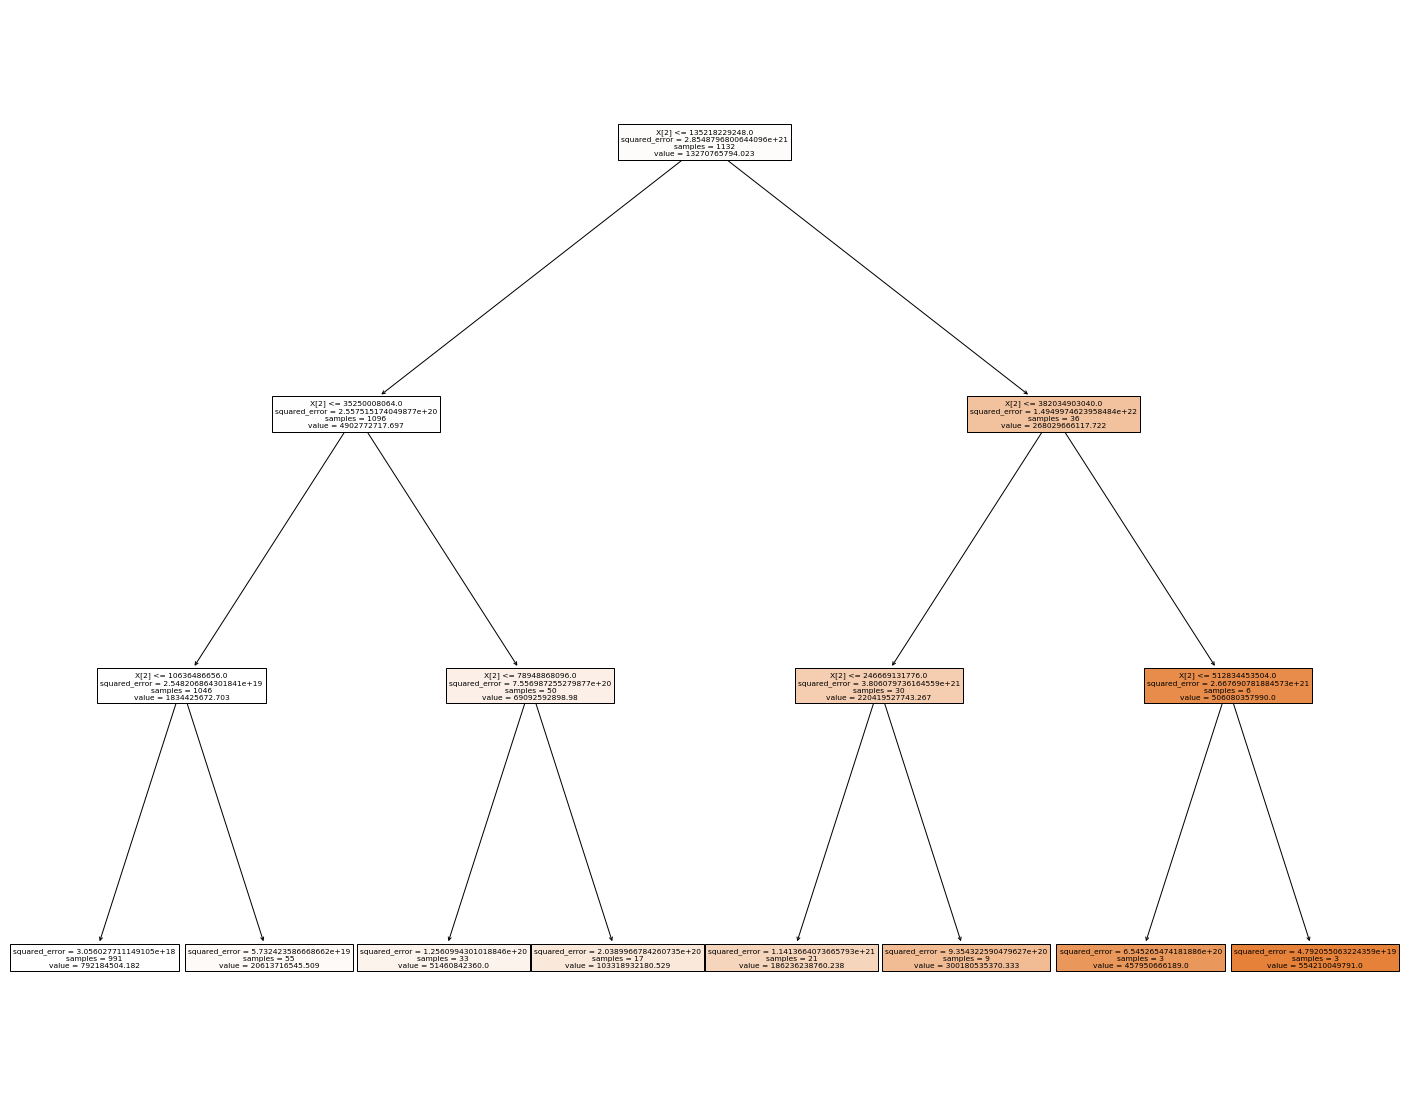

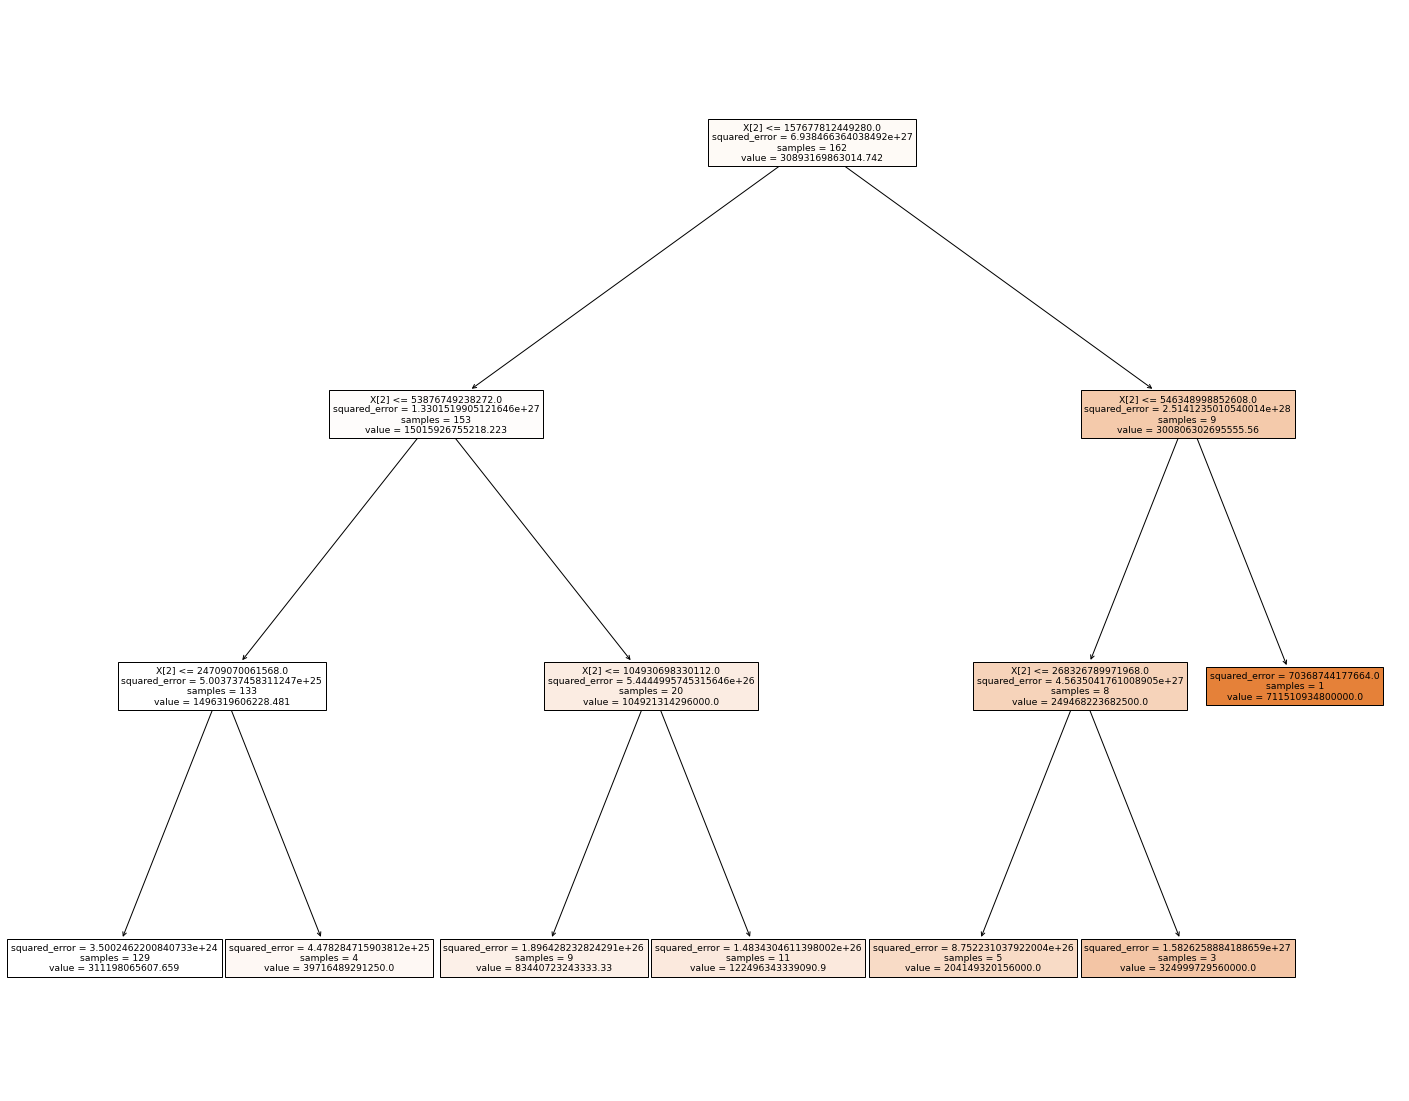

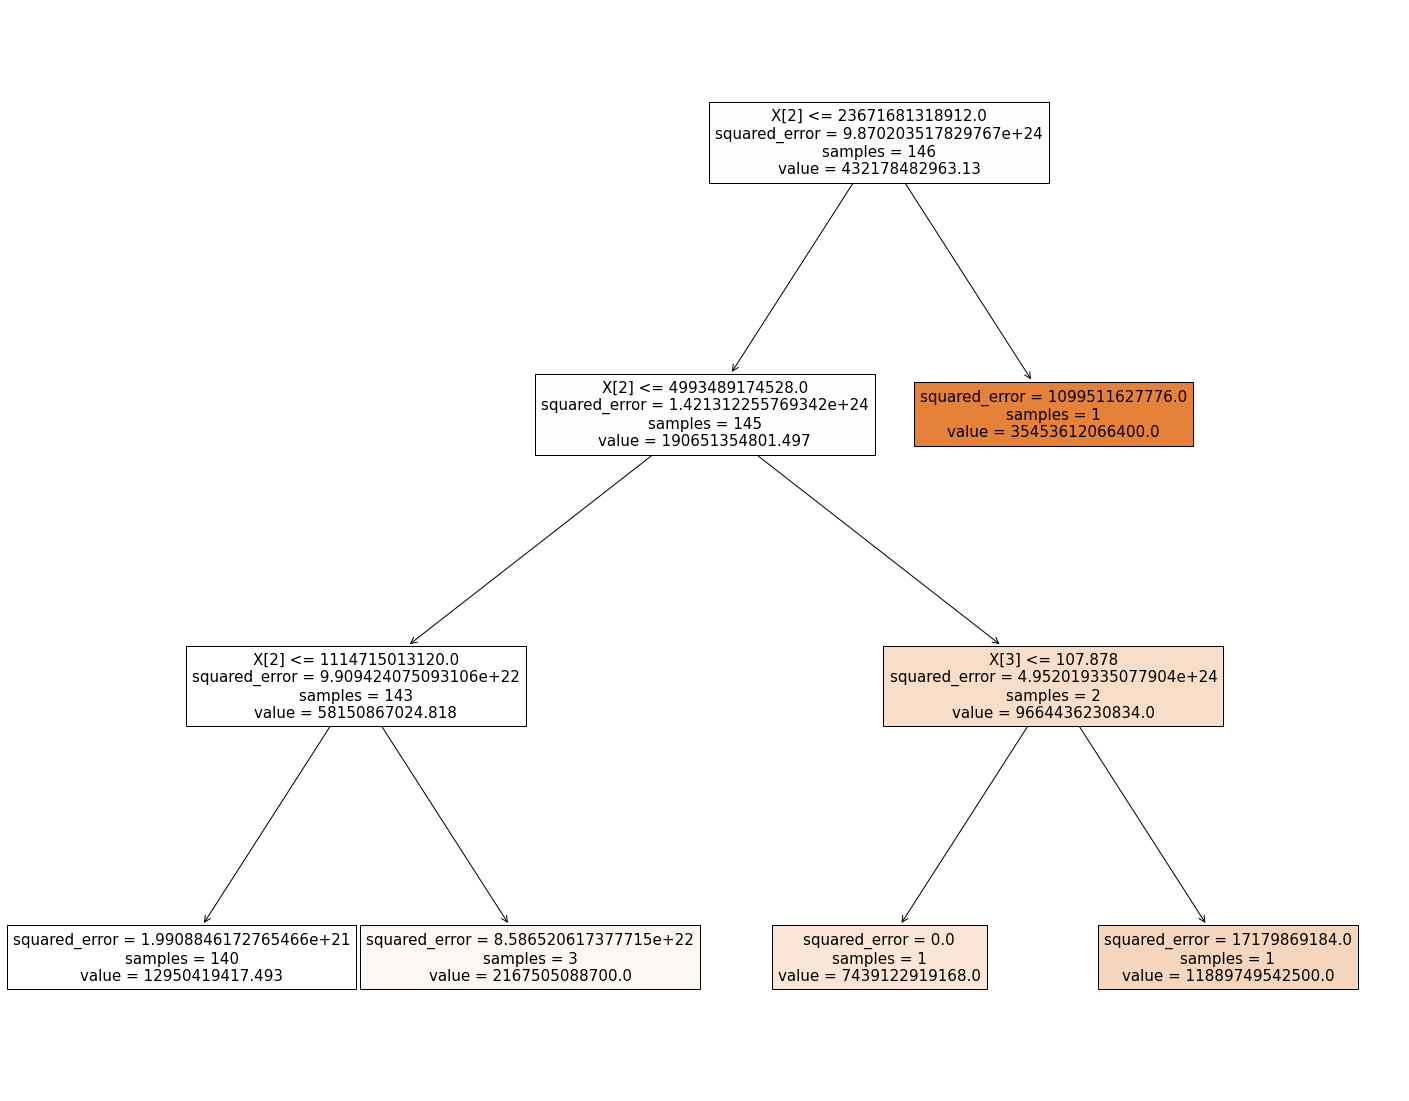

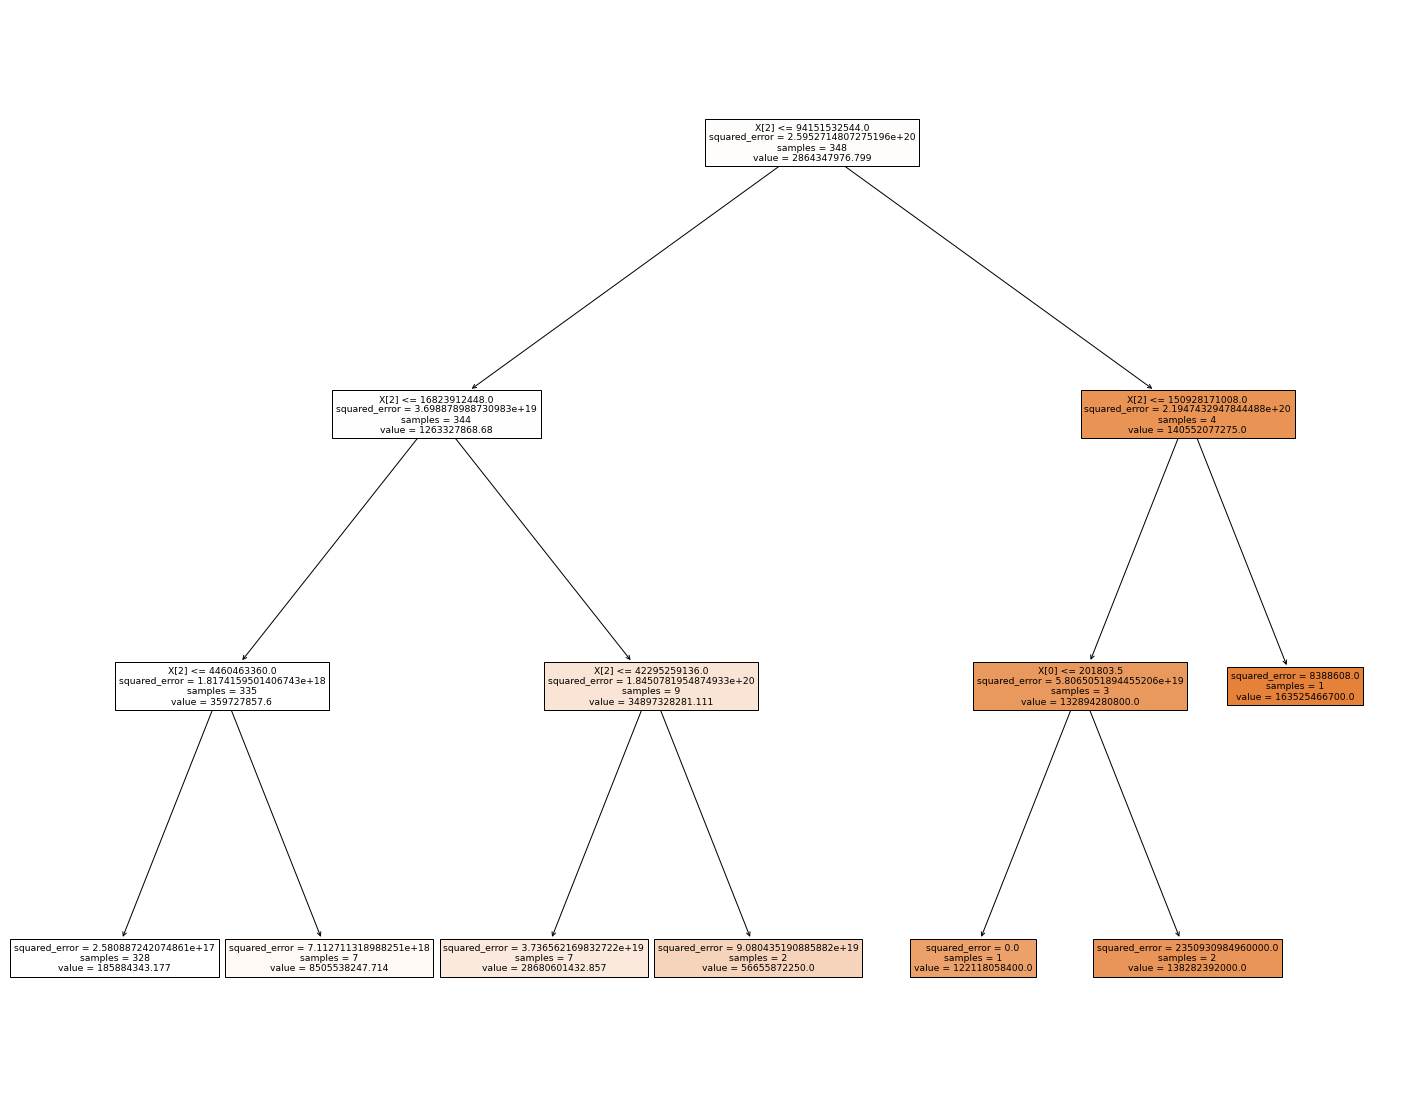

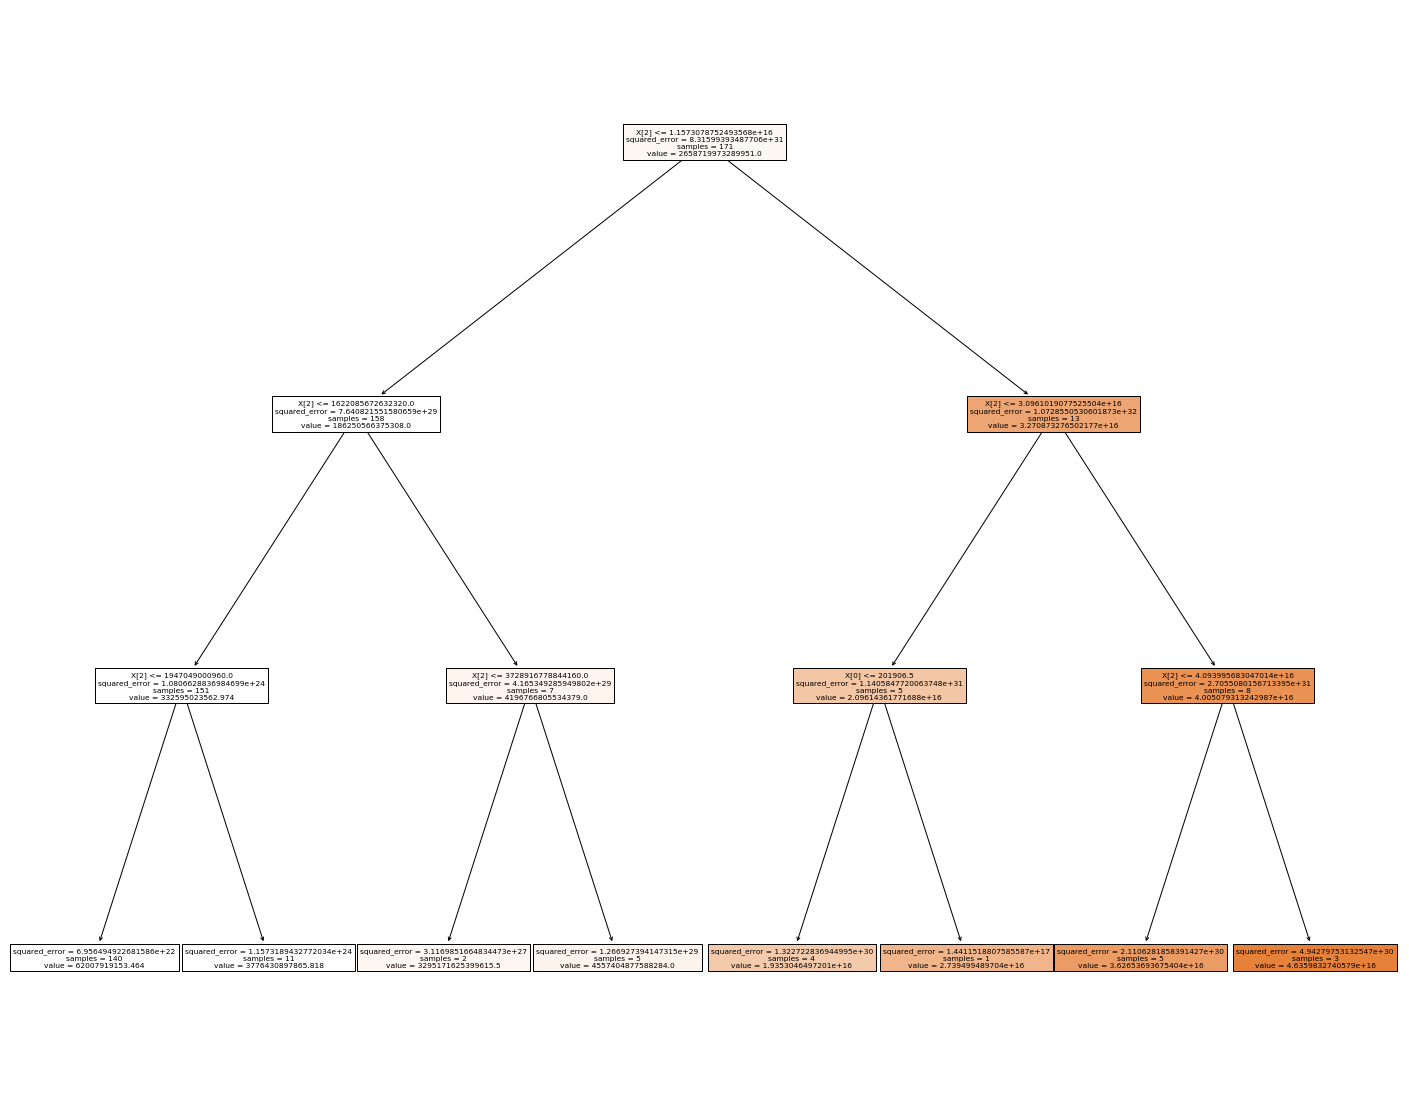

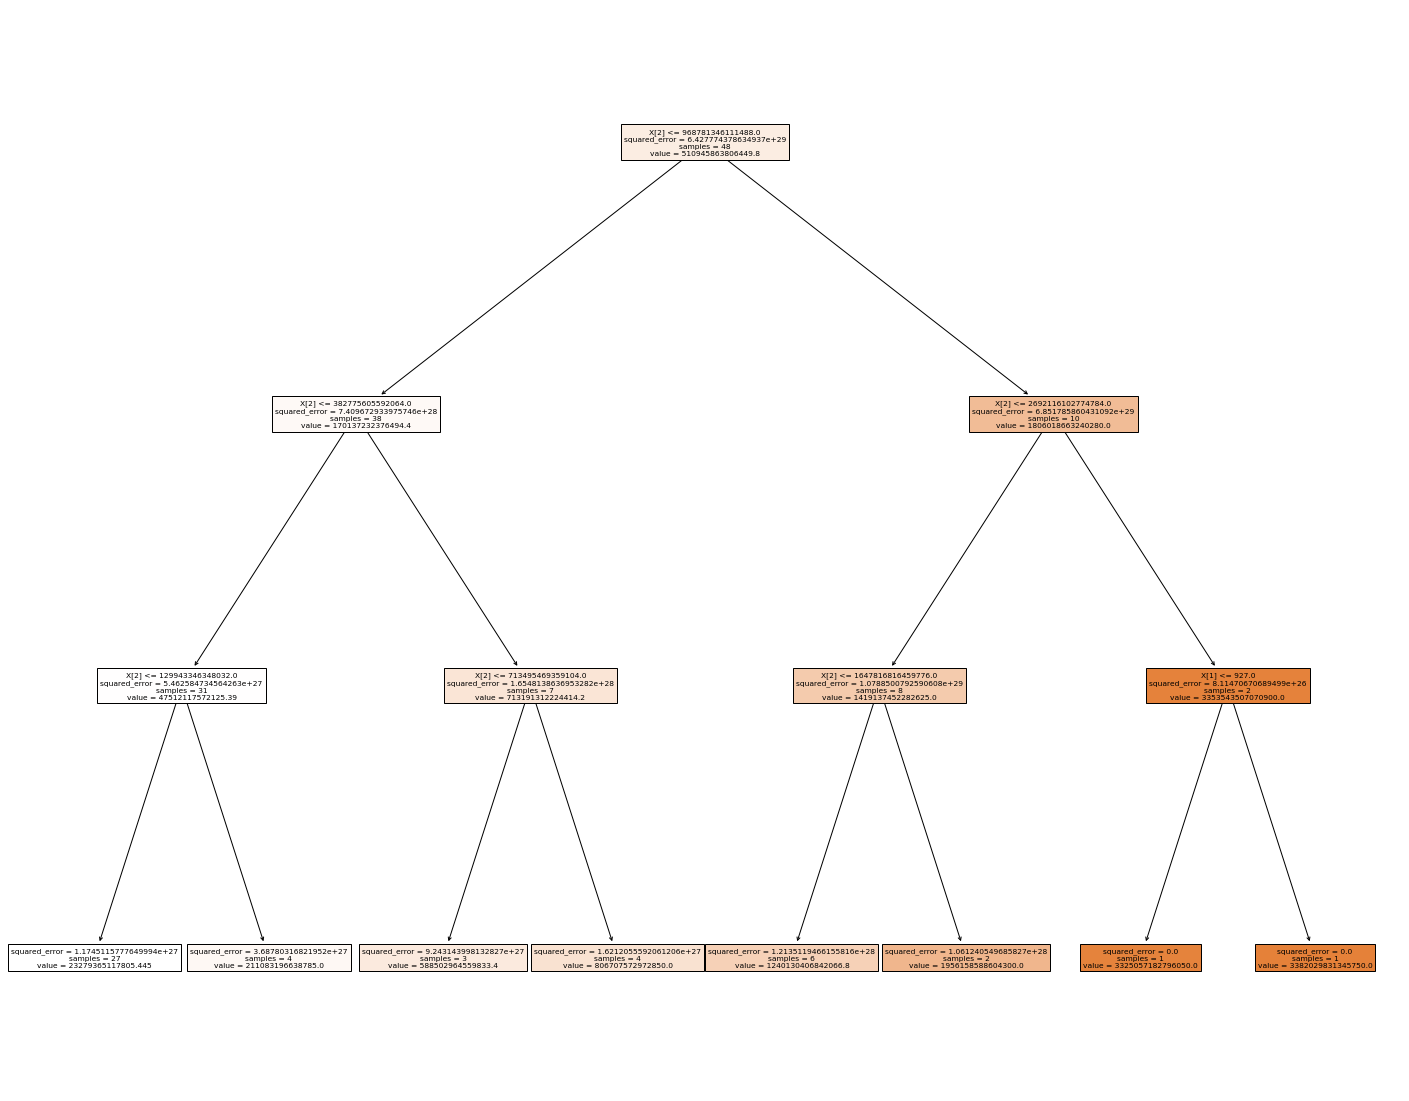

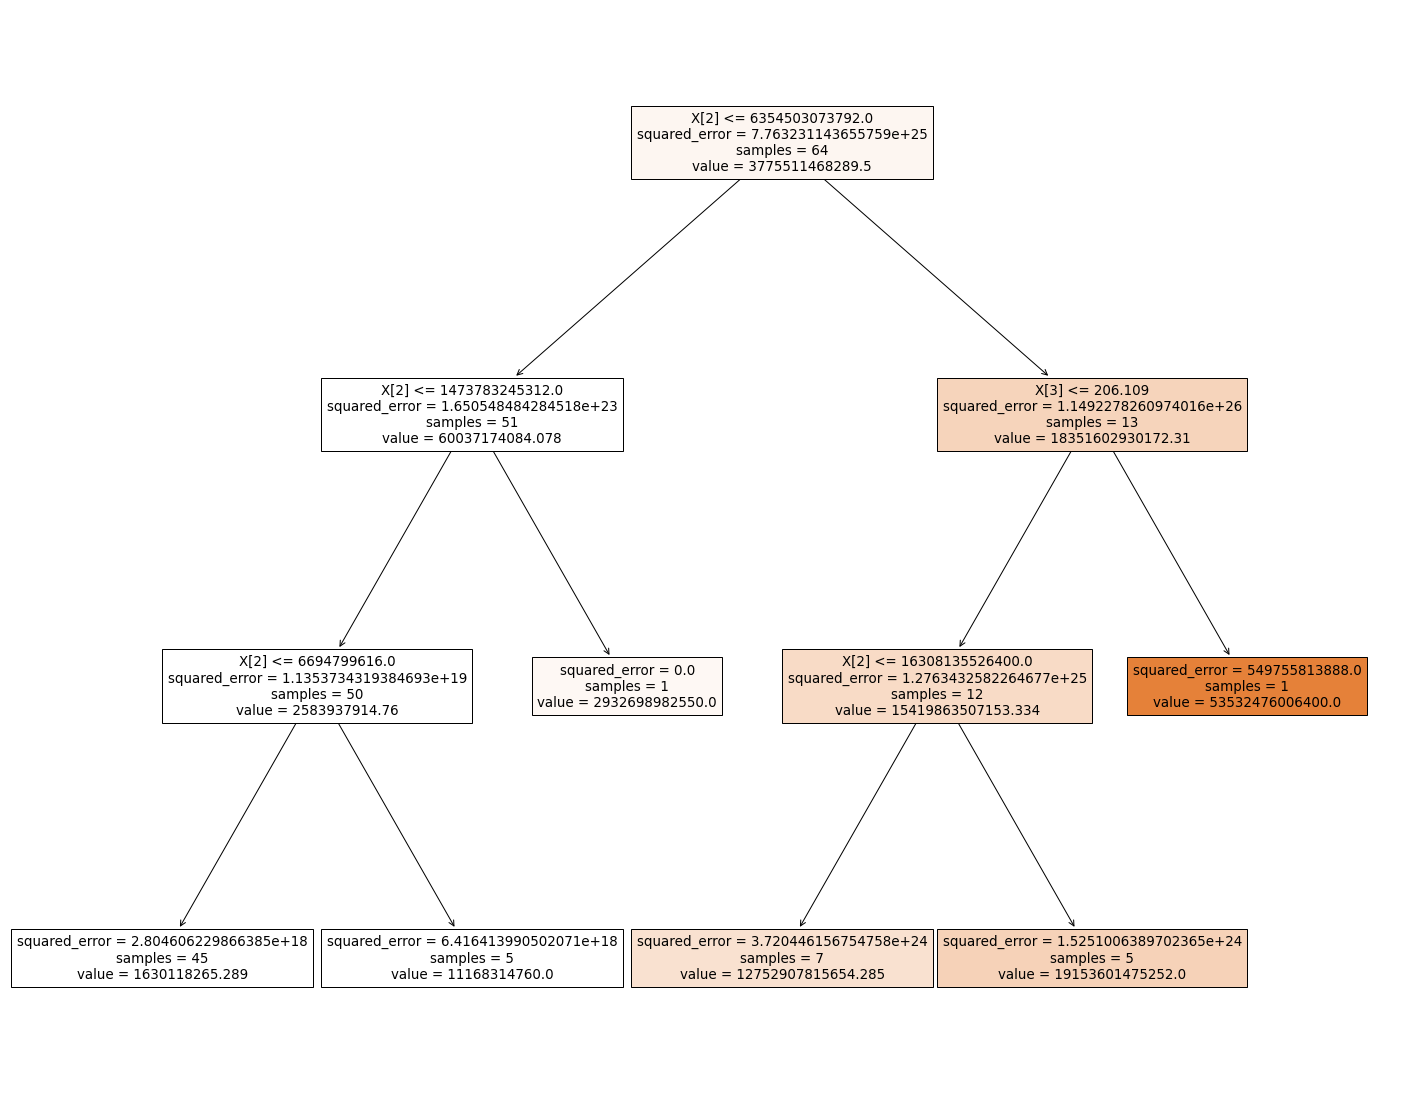

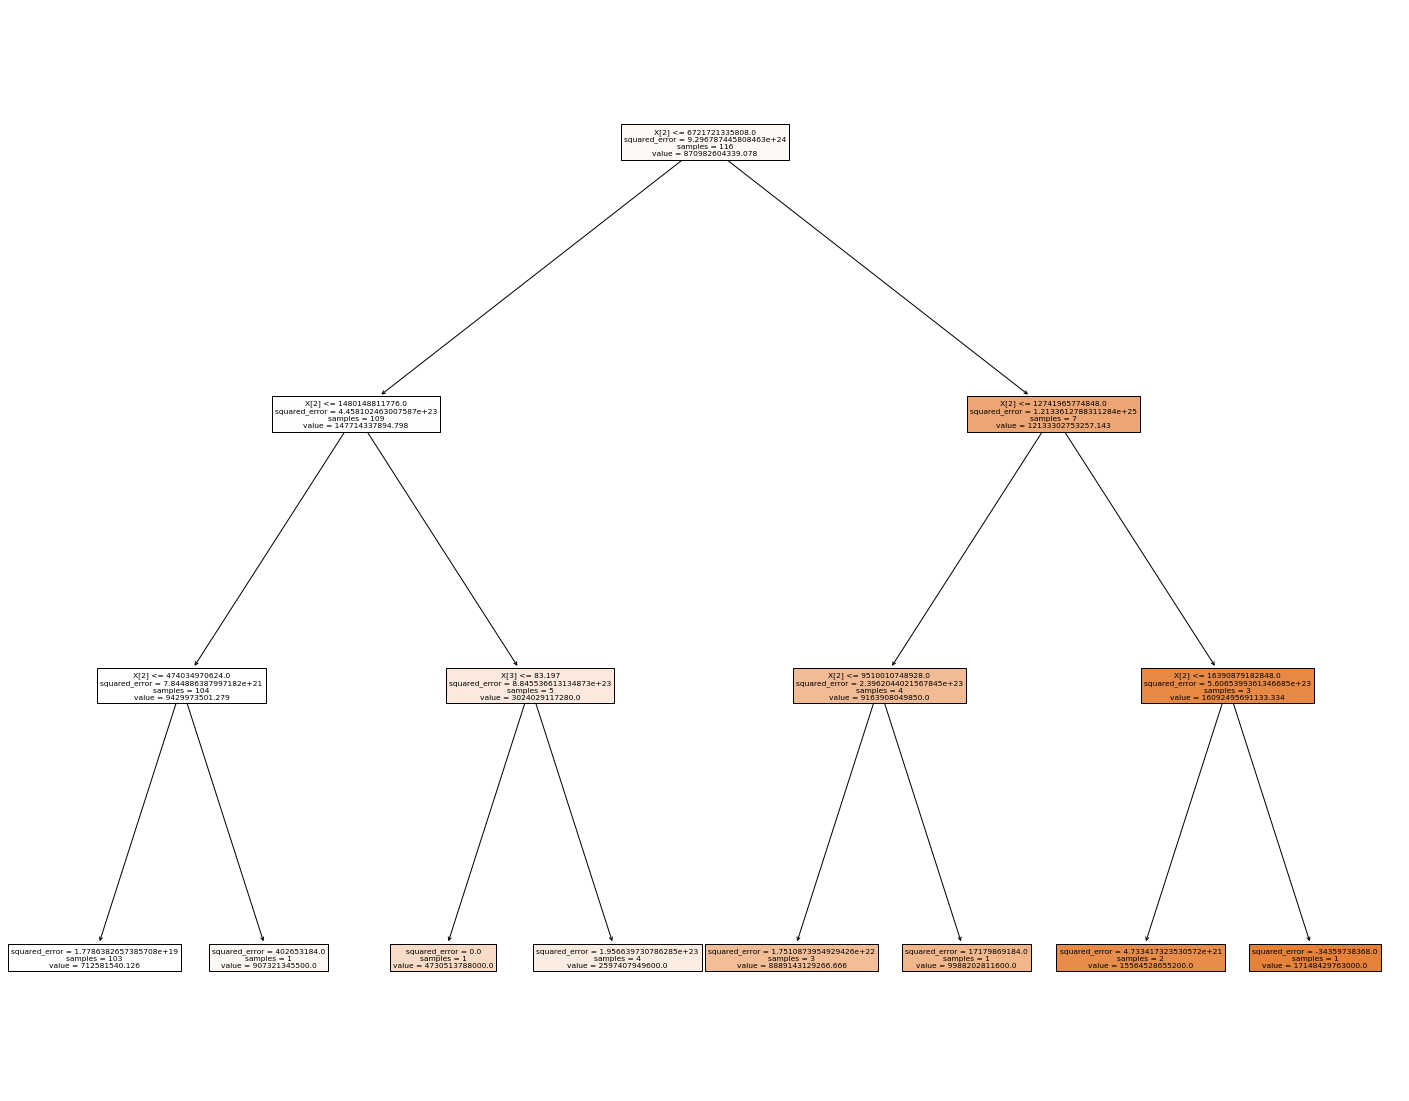

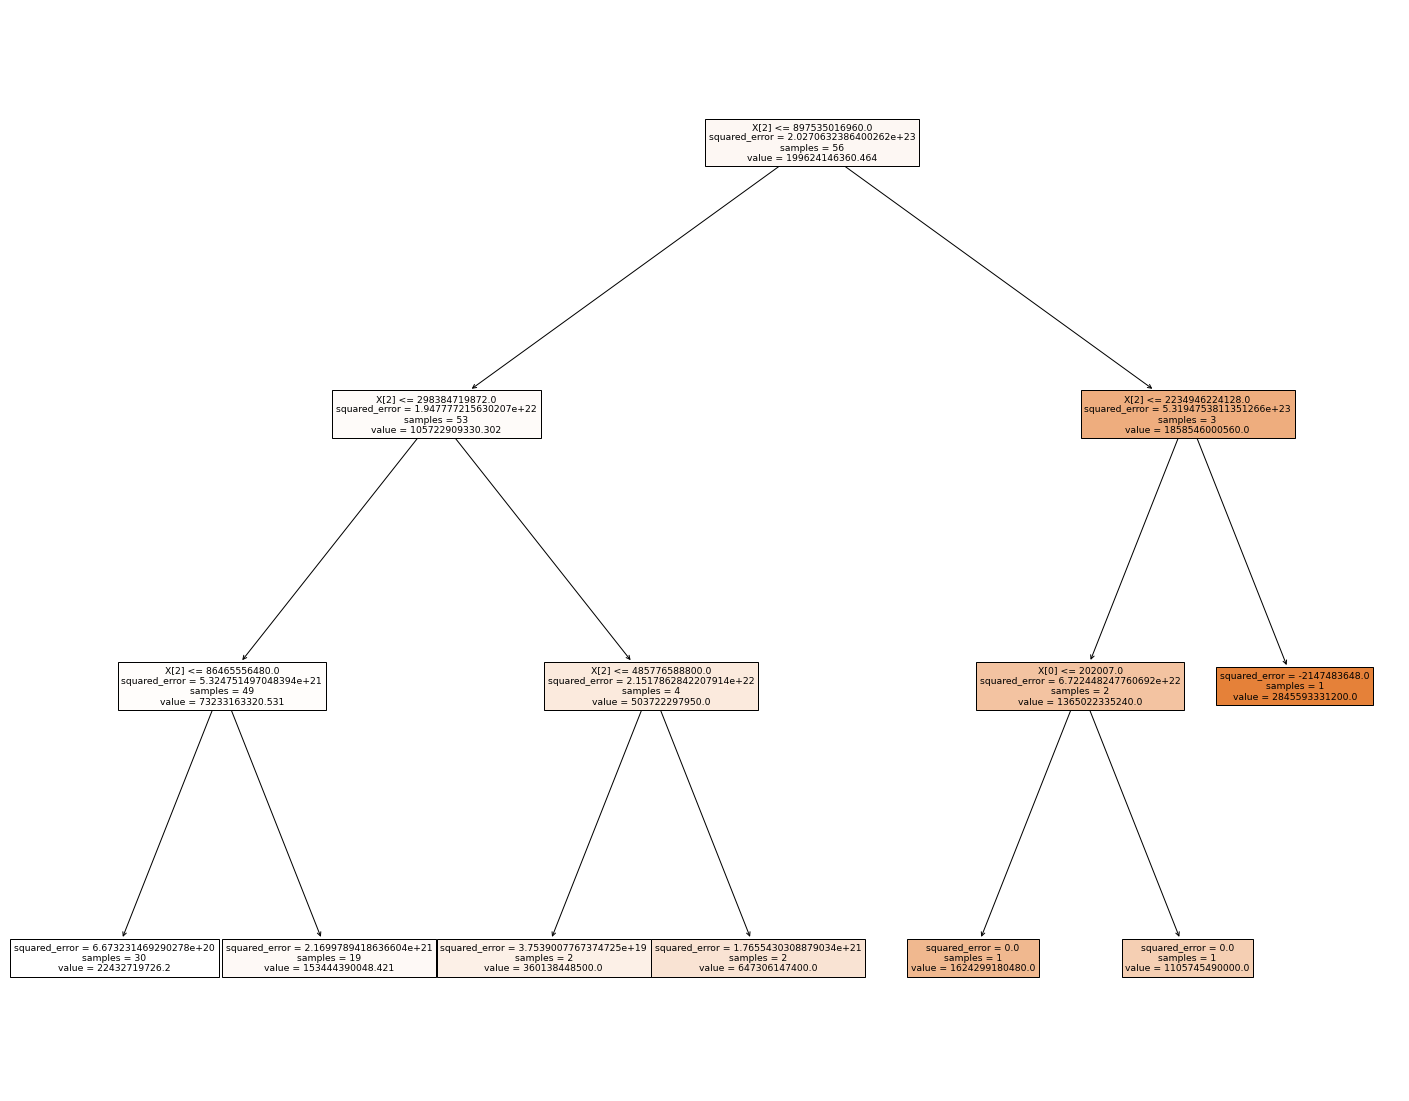

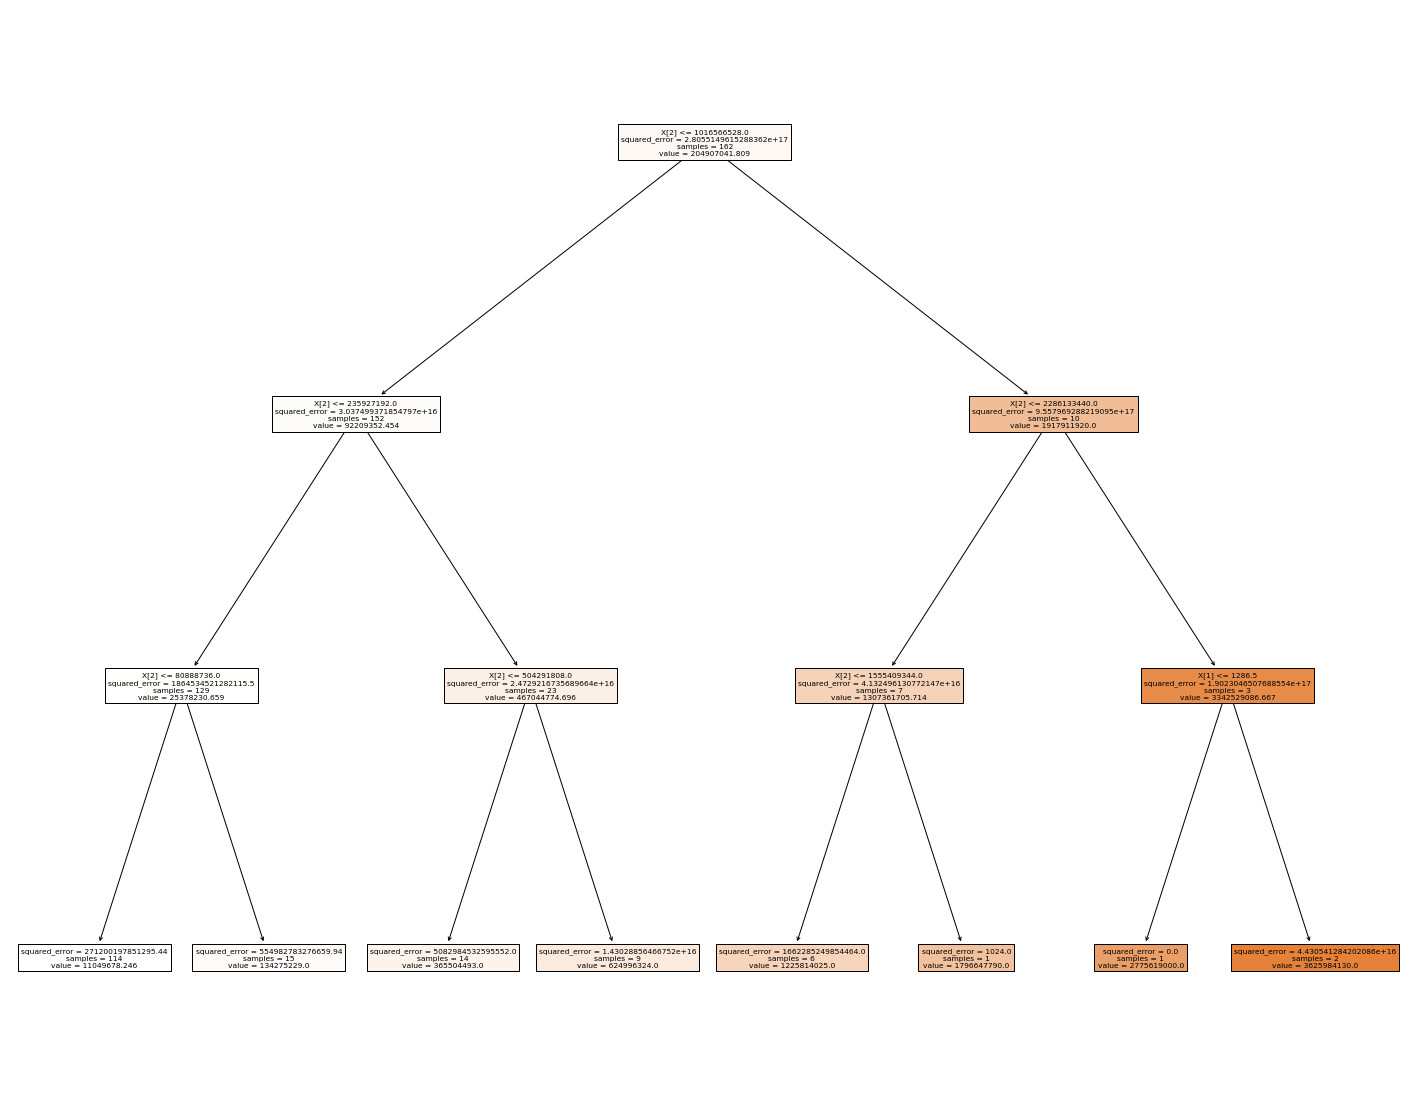

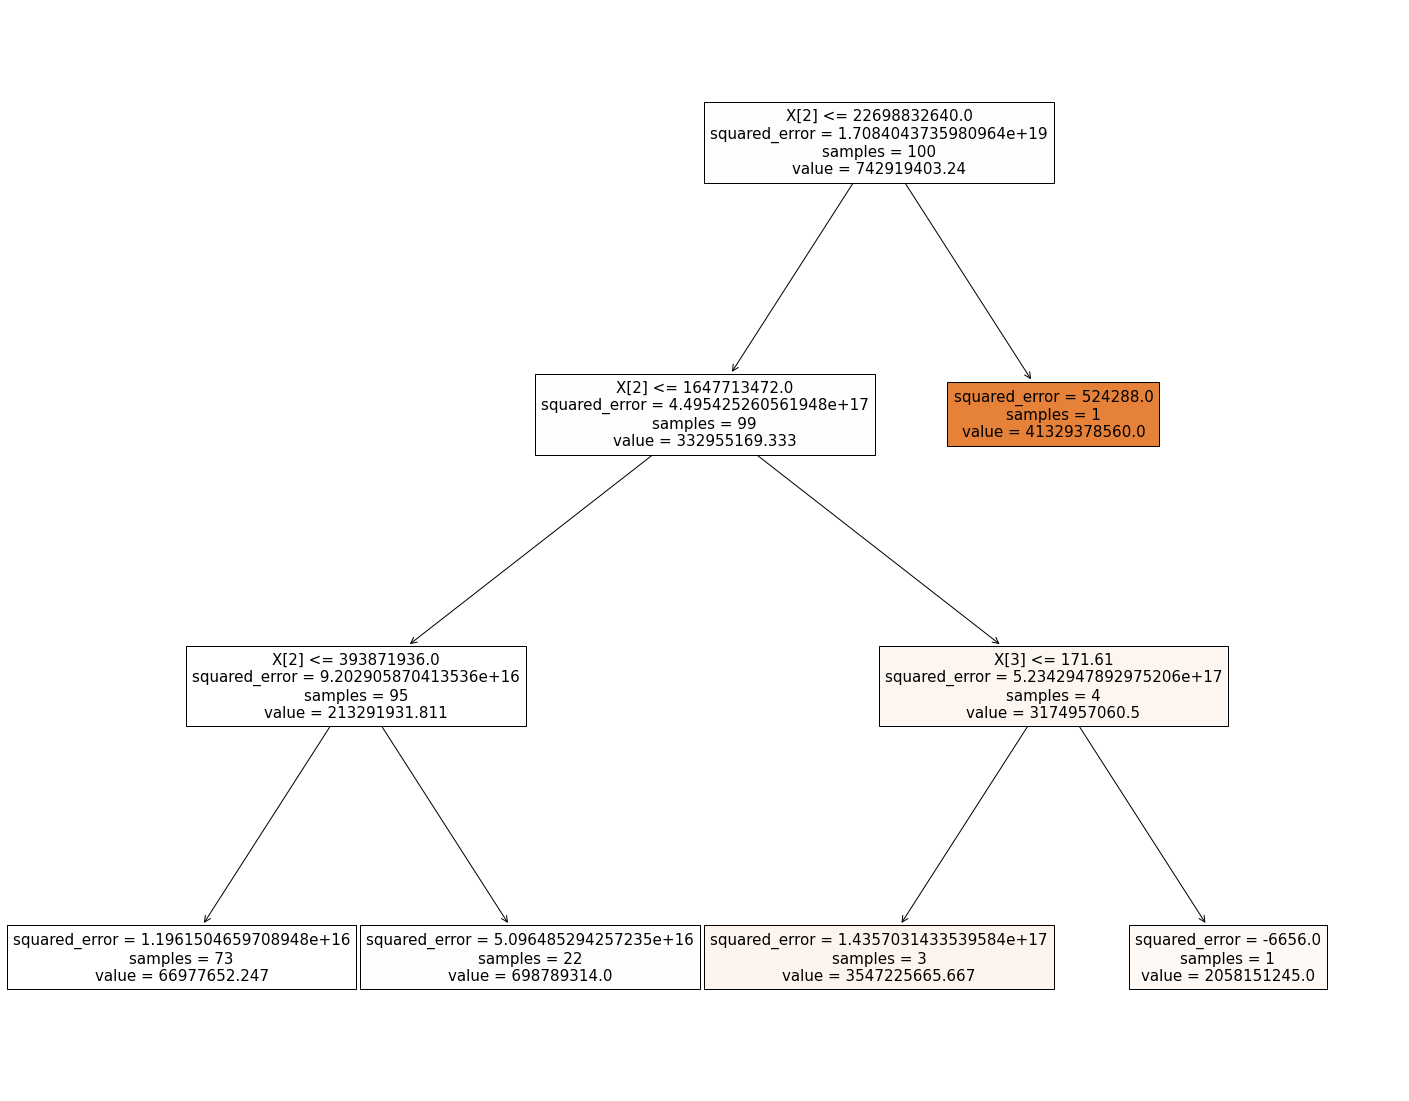

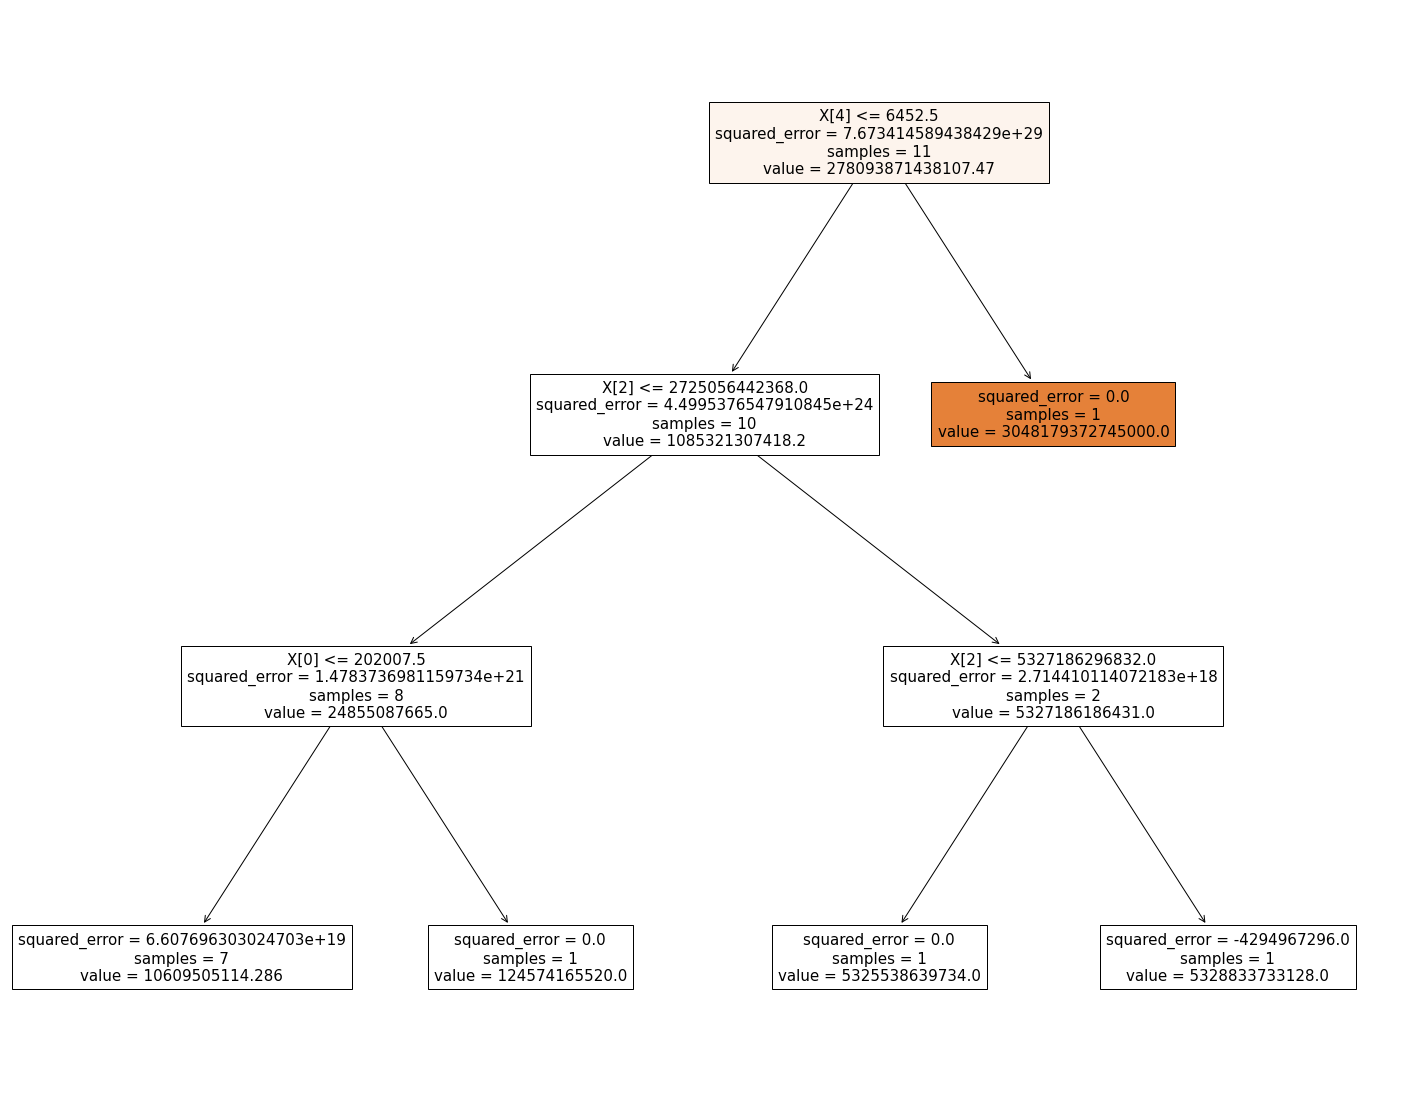

In [20]:
decision_tree_regression_model=tree.DecisionTreeRegressor(max_depth=3, random_state=1234)
for df_name in df_list:  
    # print(df_name.split("_")[1] + "_" + df_name.split("_")[3])
    if locals()[df_name].shape[0] > 1:
        X=locals()[df_name].drop(columns="TOTAL_SOLD_USD")
        Y=locals()[df_name]['TOTAL_SOLD_USD']
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=0)
######################################################################################################################        
#                                       Decision Tree Regression                                                     #
######################################################################################################################
        decision_tree_regression_model.fit(x_train, y_train)
        decision_tree_regression_predictions = decision_tree_regression_model.predict(x_test)
        decision_tree_regression_model_mae=mean_absolute_error(y_test, decision_tree_regression_predictions)
        decision_tree_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, decision_tree_regression_predictions))
        decision_tree_regression_model_score=decision_tree_regression_model.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",decision_tree_regression_model_mae)
        # print("RMSE: ",decision_tree_regression_model_rmse)
        # print("Accuracy score of the model : ", decision_tree_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3],
            'Predictive_Analysis_Model': decision_tree_regression_model.__class__.__name__ + "_with_" + str(decision_tree_regression_model.get_params()['max_leaf_nodes']) + "_max_leaf_modes",
            'Accuracy_Score': decision_tree_regression_model_score,
            'Mean_Absolute_Error' : decision_tree_regression_model_mae,
            'Root_Mean_Squared_Error':decision_tree_regression_model_rmse
        }, ignore_index=True)
        print(df_name)
        fig = plt.figure(figsize=(25,20))
        tree.plot_tree(decision_tree_regression_model,filled=True)

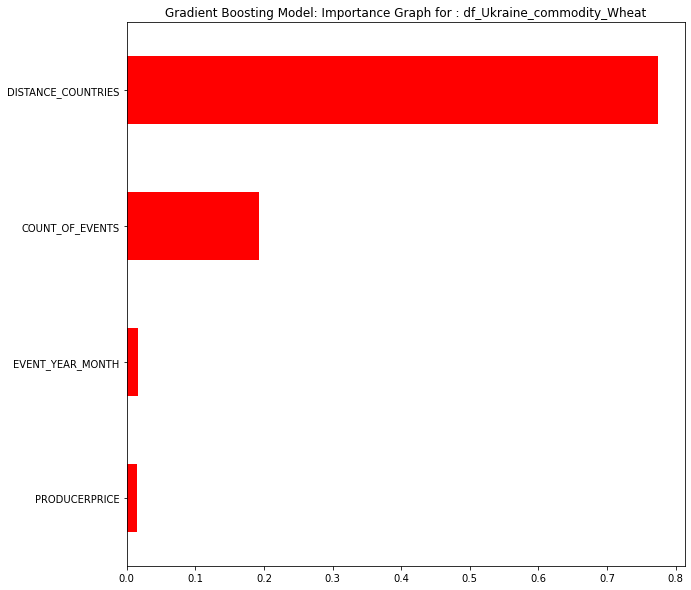

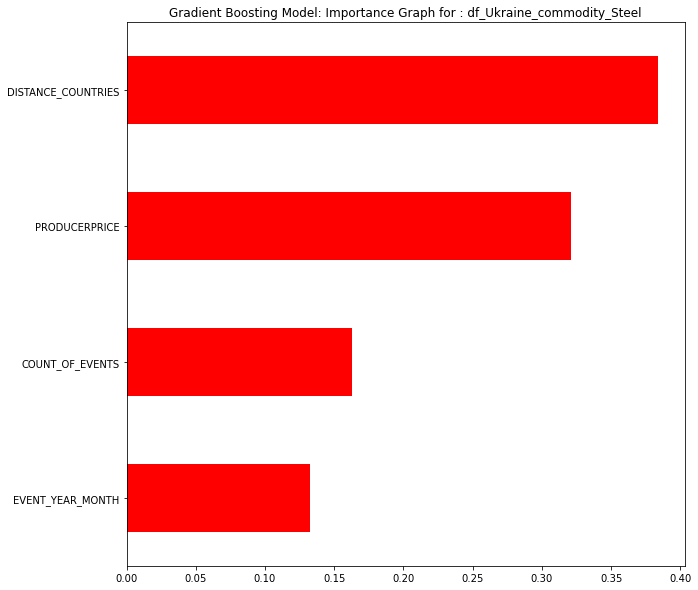

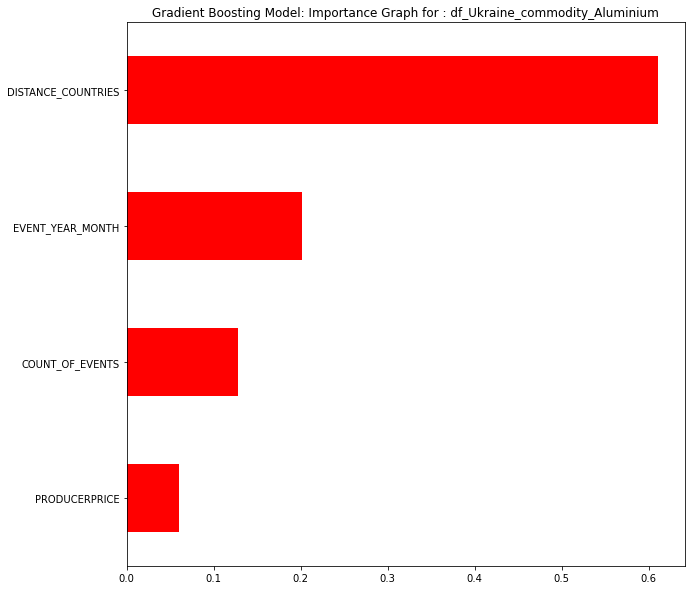

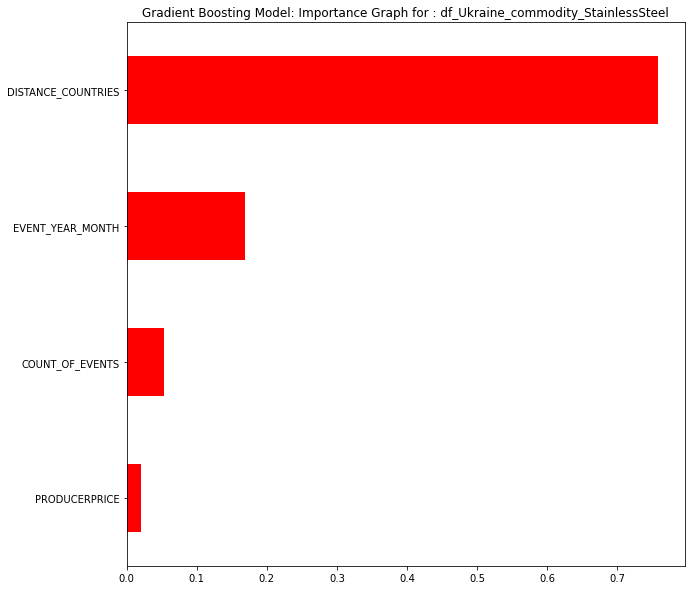

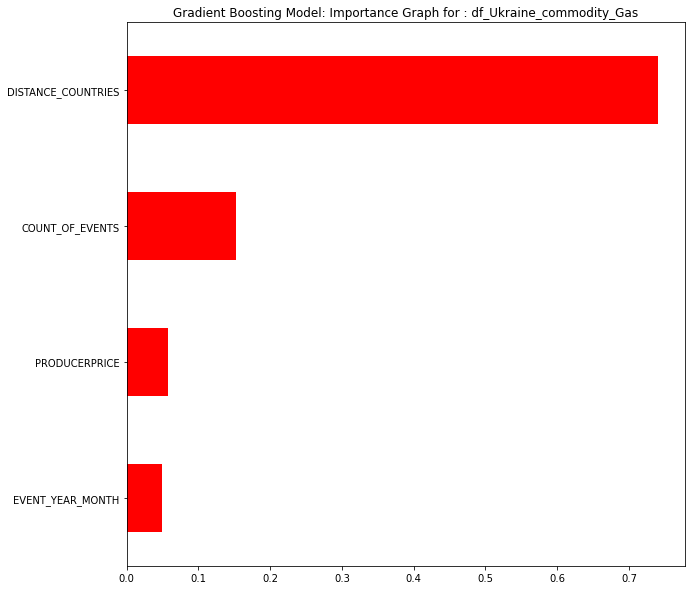

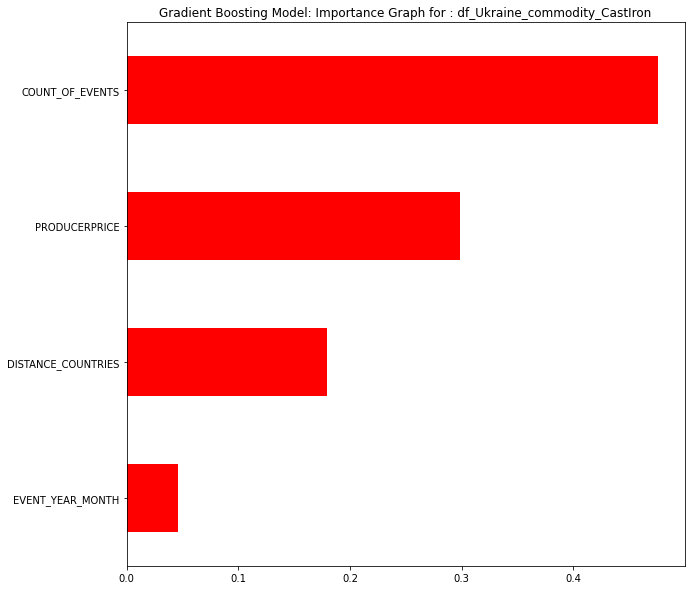

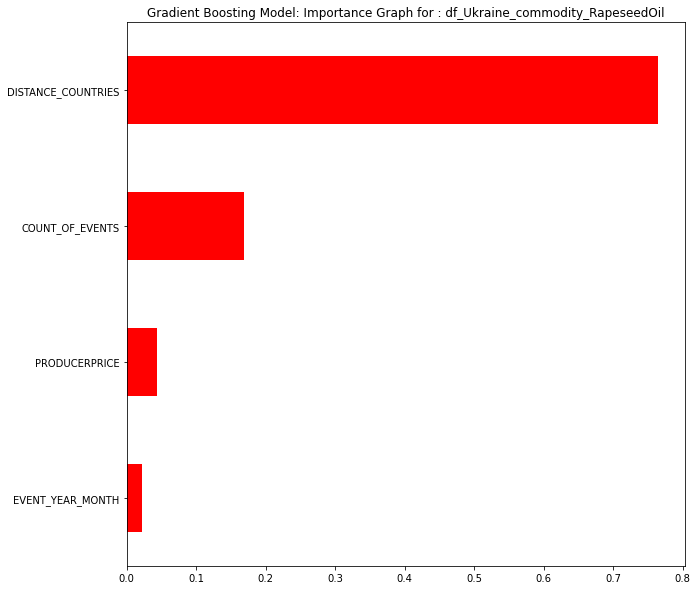

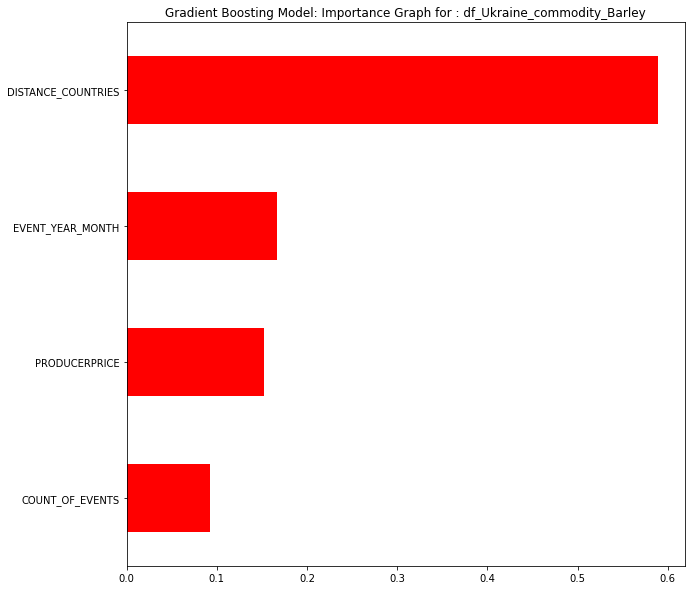

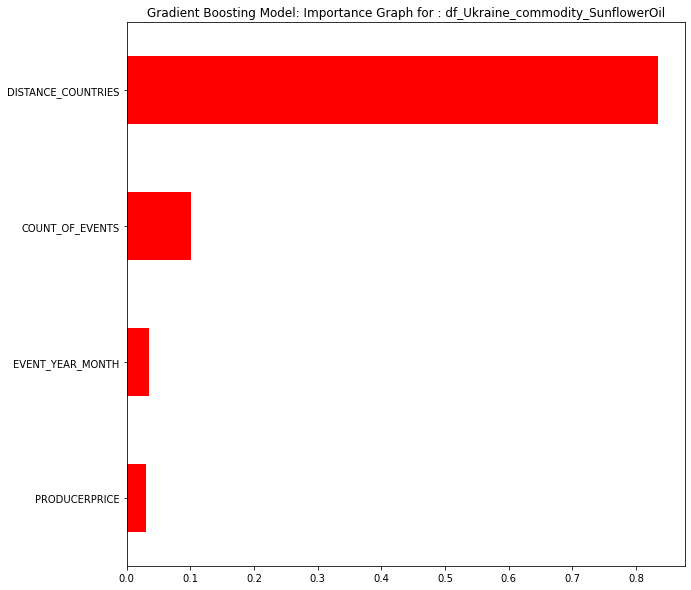

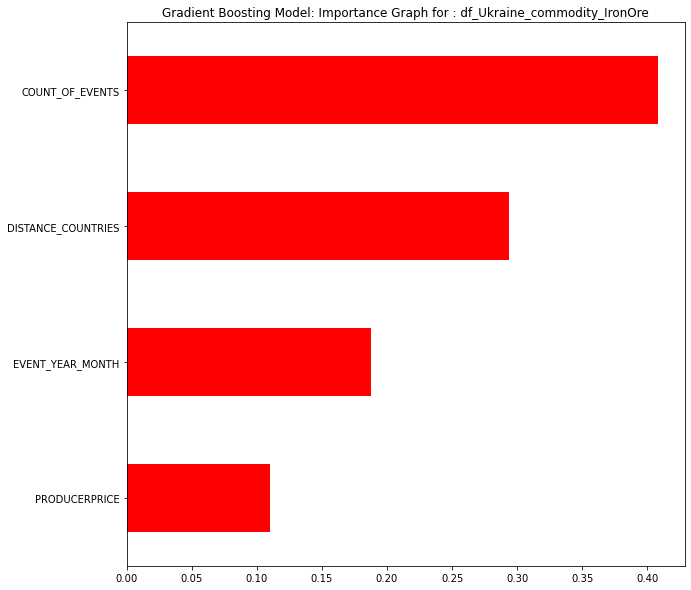

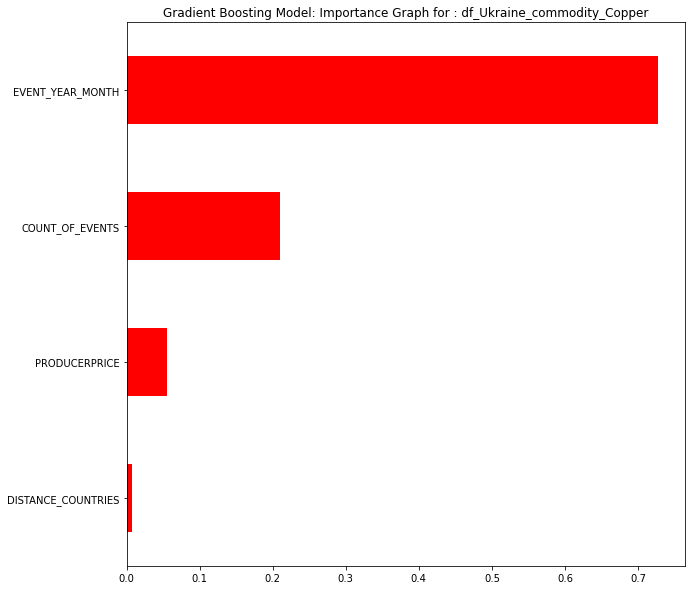

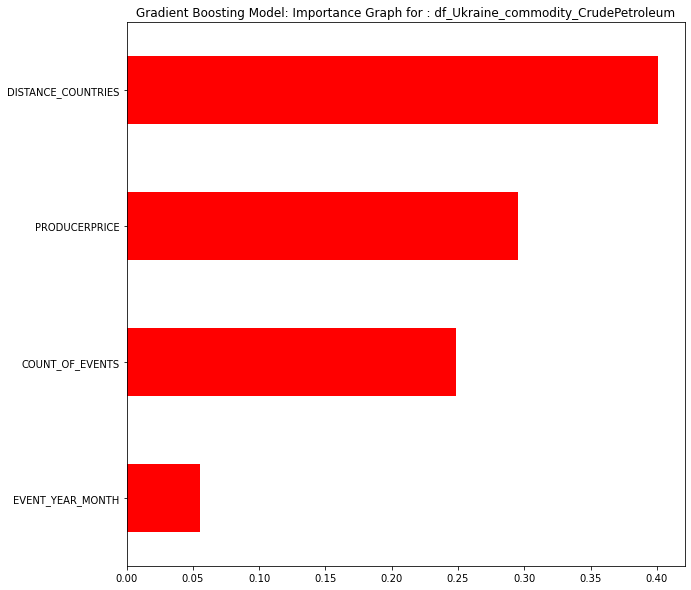

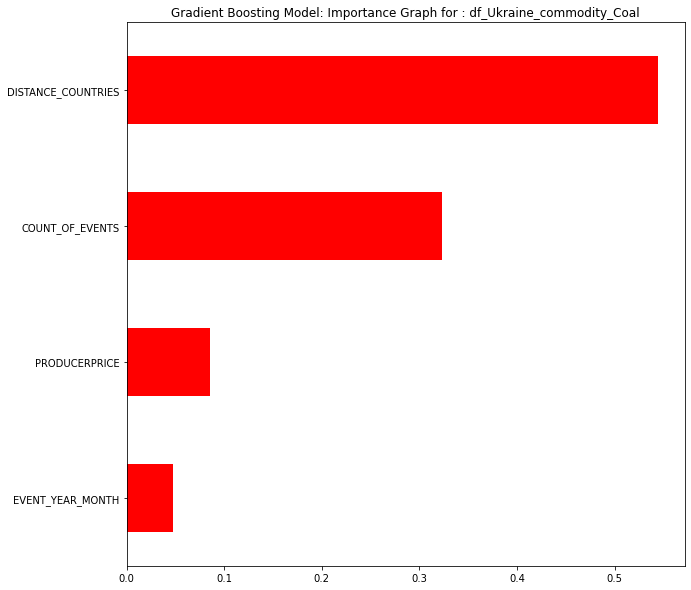

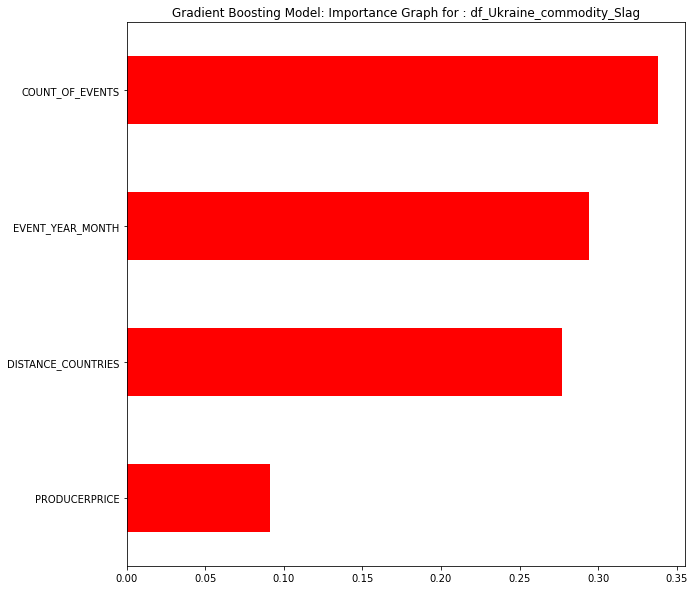

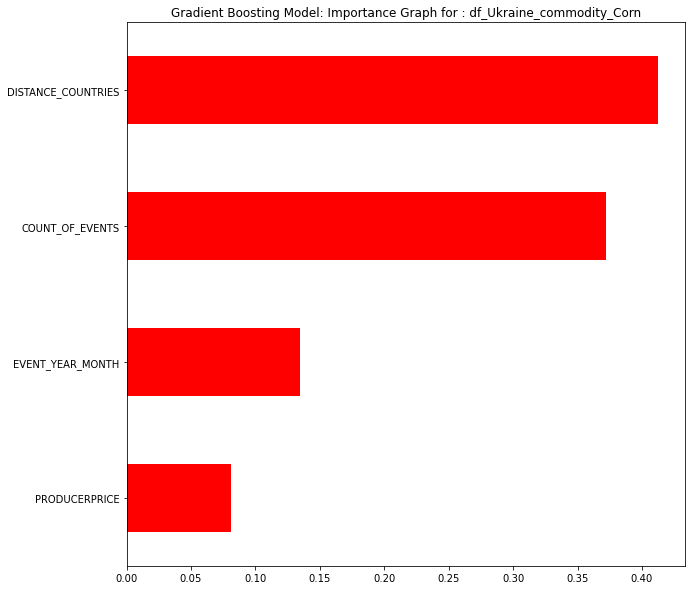

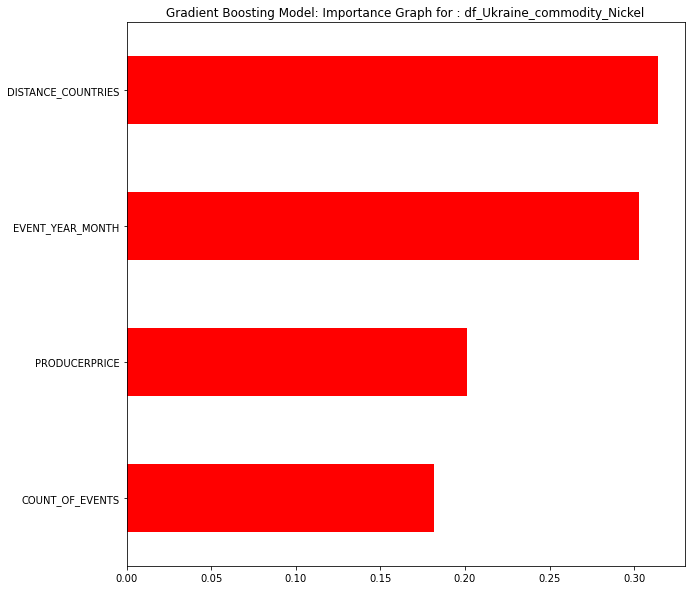

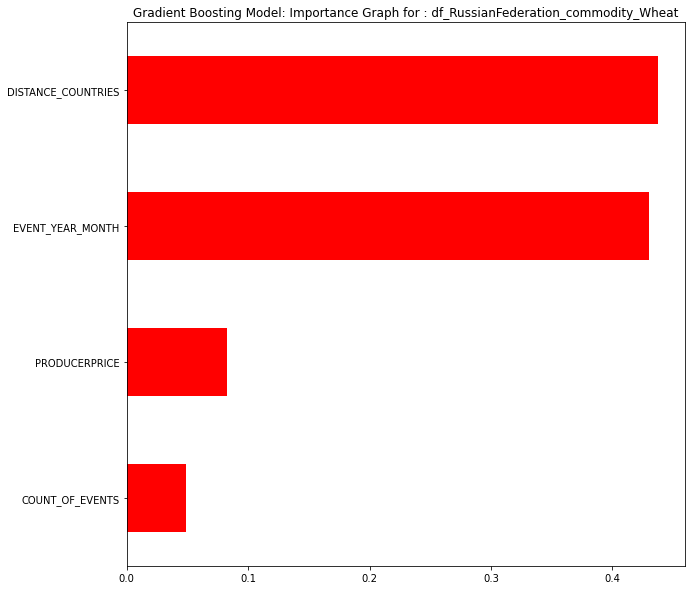

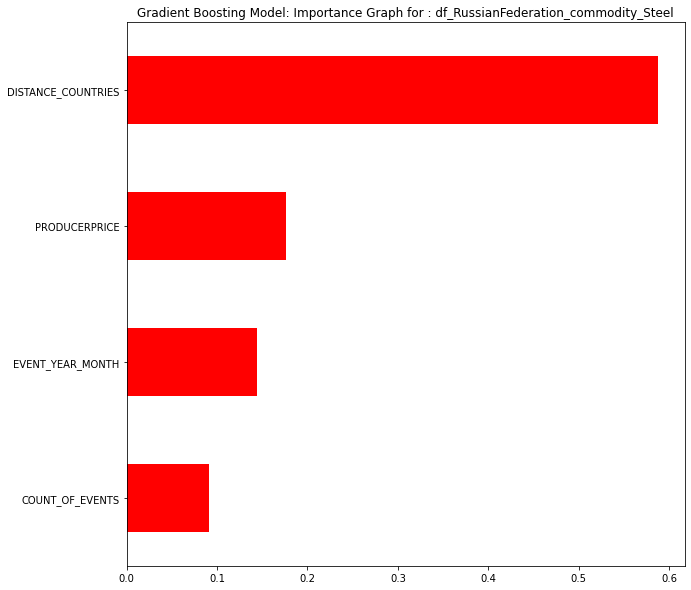

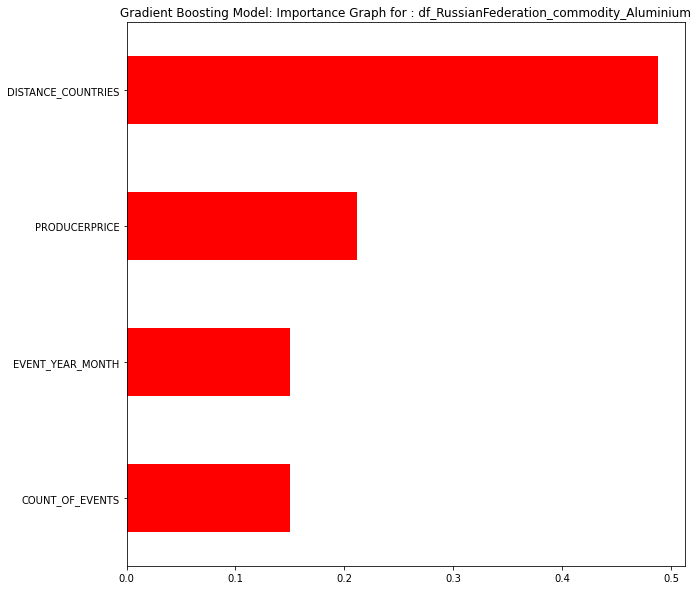

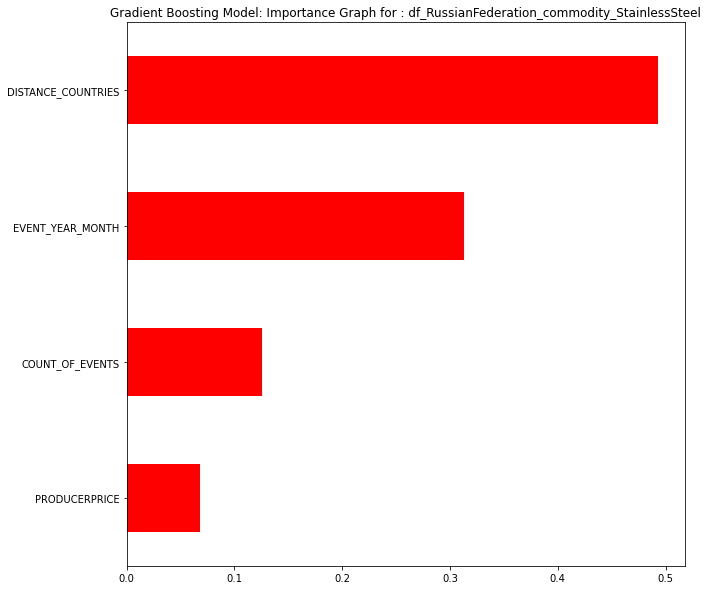

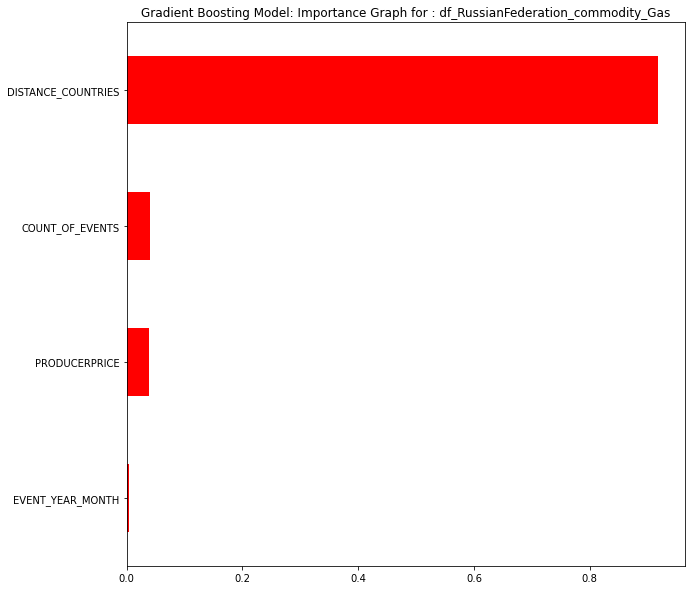

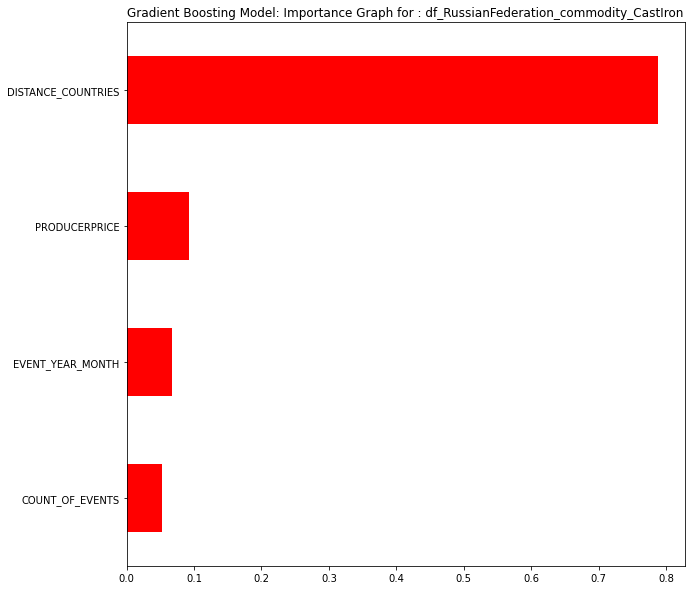

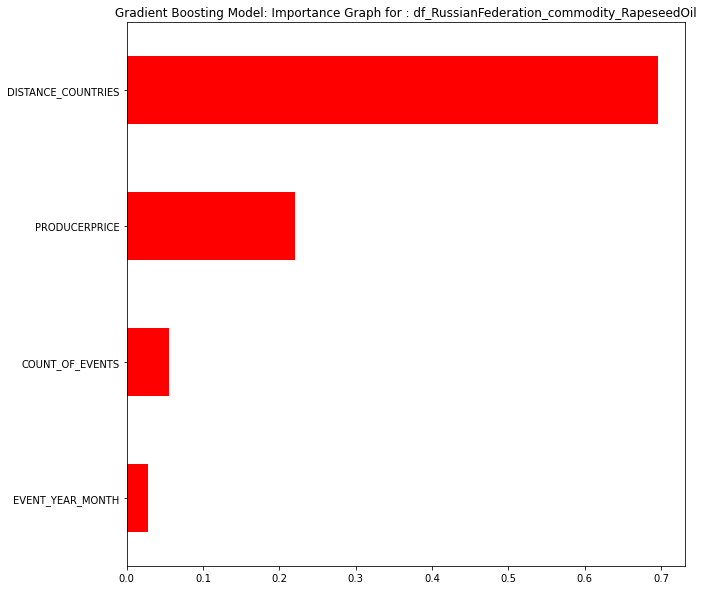

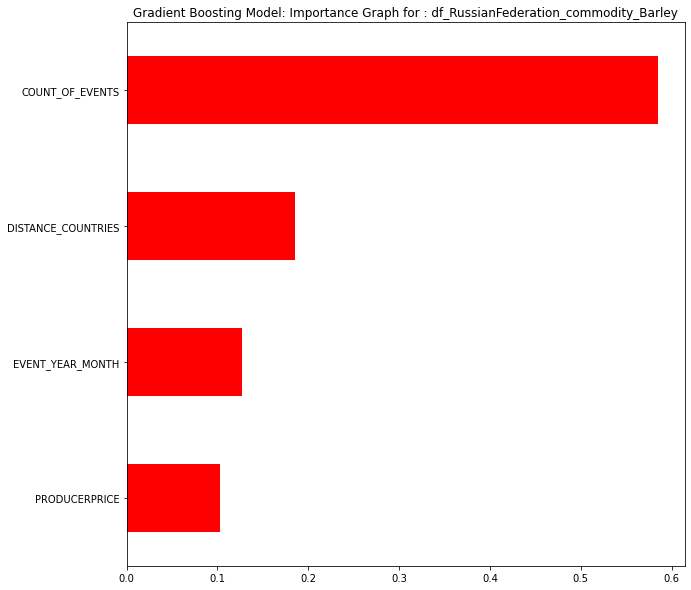

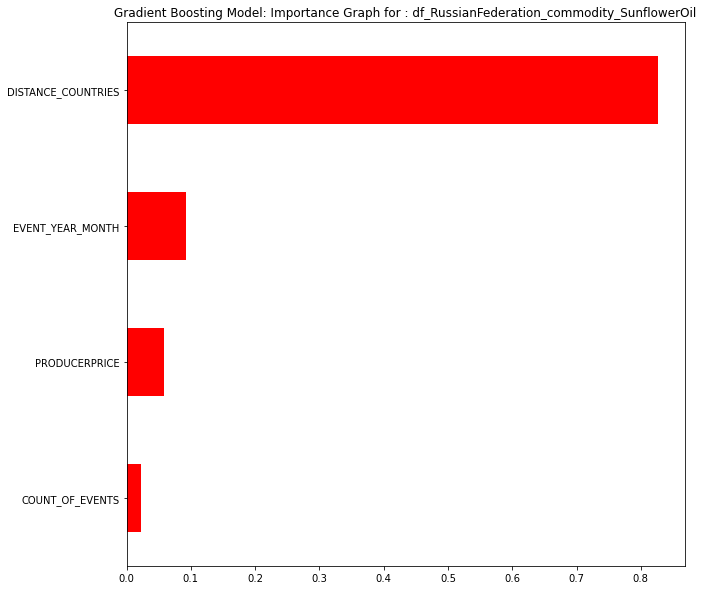

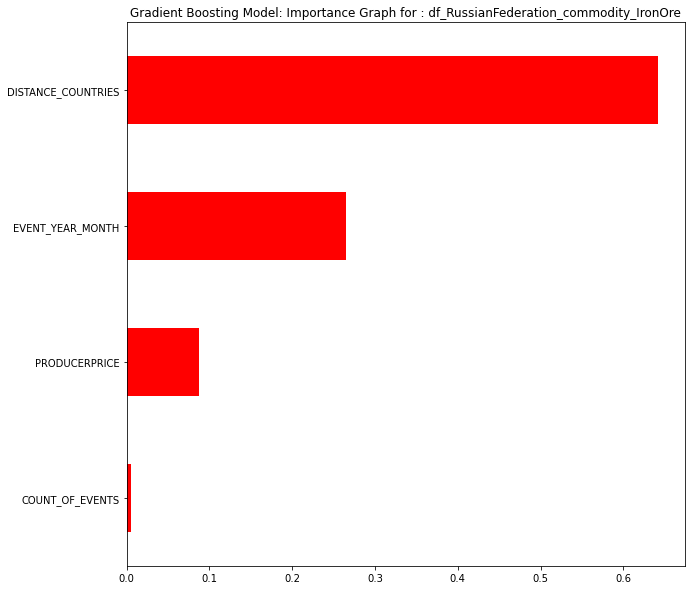

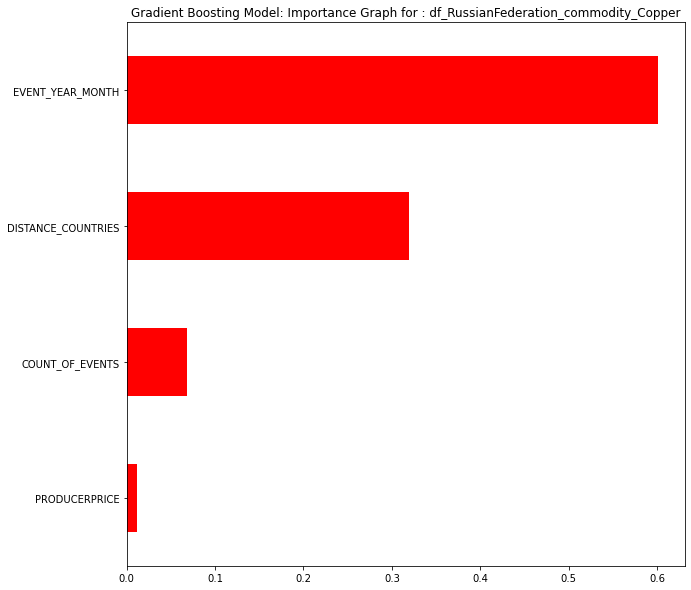

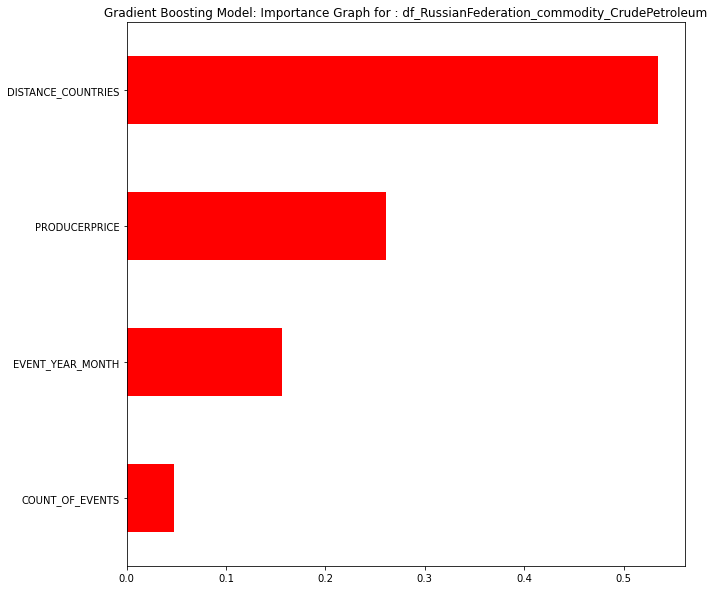

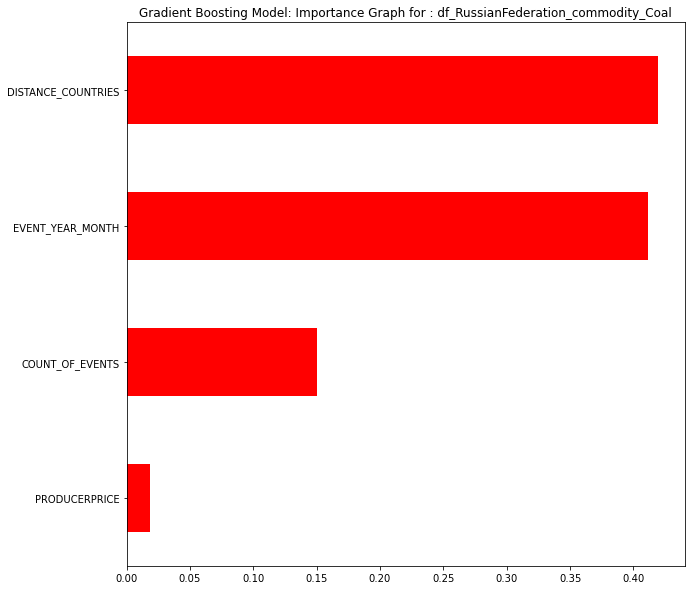

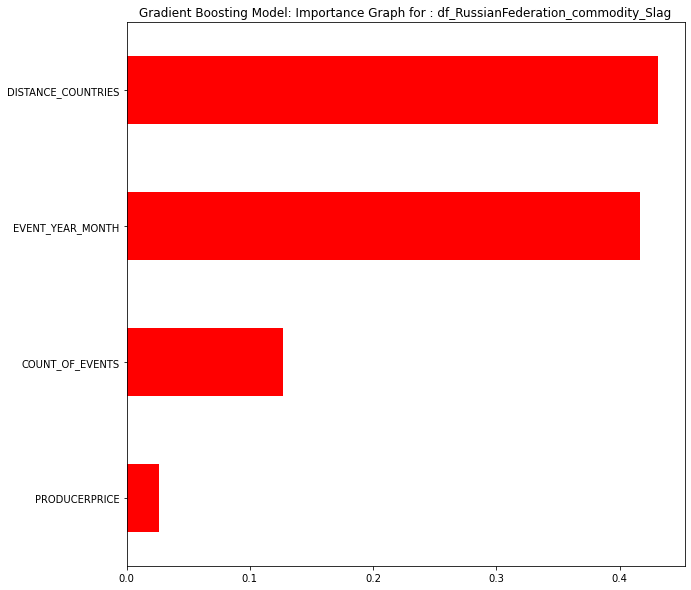

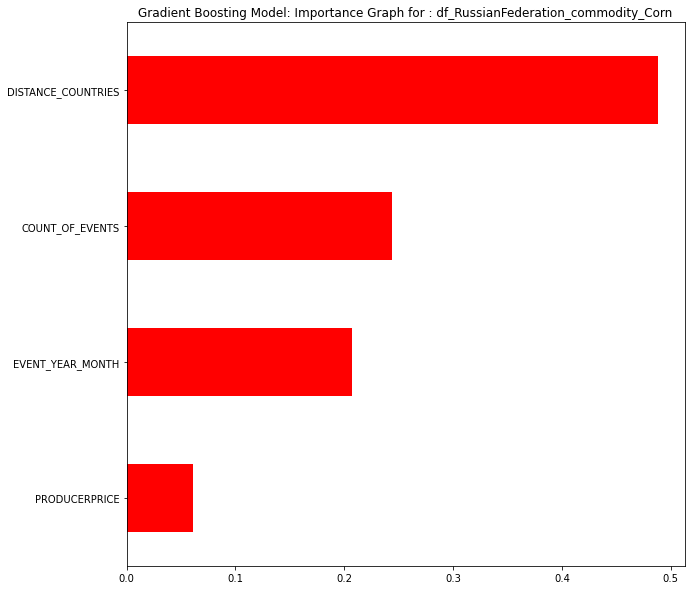

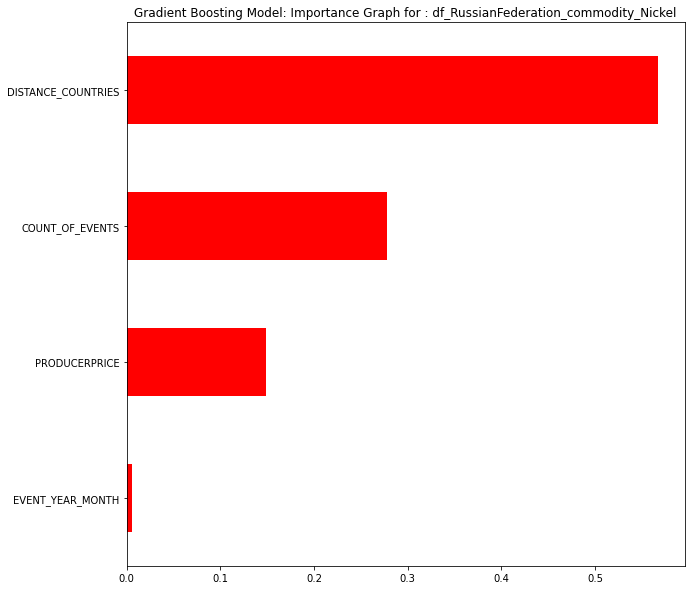

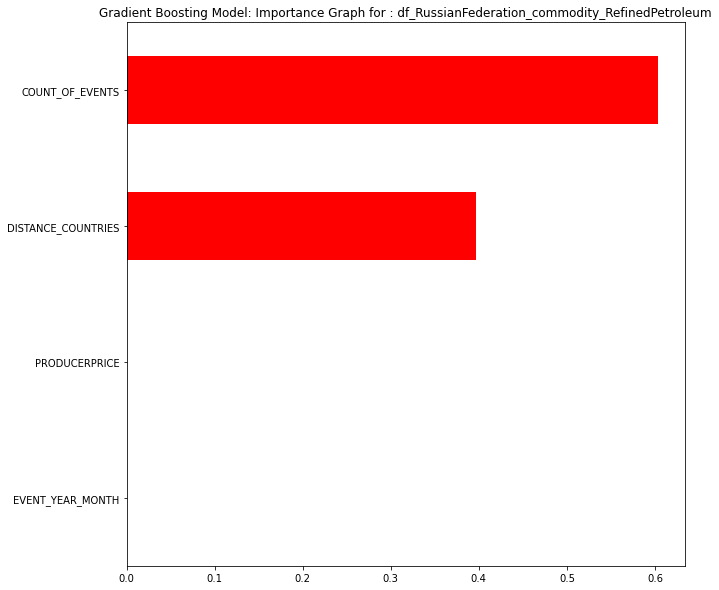

In [34]:
gradient_boost_regression_model = GradientBoostingRegressor()
for df_name in df_list:  
    # print(df_name.split("_")[1] + "_" + df_name.split("_")[3])
    if locals()[df_name].shape[0] > 1:
        X=locals()[df_name].drop(columns="TOTAL_SOLD_USD")
        Y=locals()[df_name]['TOTAL_SOLD_USD']
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=0)
######################################################################################################################        
#                                       Gradient Boost Regression                                                    #
######################################################################################################################        
        gradient_boost_regression_model.fit(x_train, y_train)
        gradient_boost_regression_predictions = gradient_boost_regression_model.predict(x_test)
        gradient_boost_regression_model_mae=mean_absolute_error(y_test, gradient_boost_regression_predictions)
        gradient_boost_regression_model_rmse=np.sqrt(metrics.mean_squared_error(y_test, gradient_boost_regression_predictions))
        gradient_boost_regression_model_score=gradient_boost_regression_model.score(x_test,y_test)
        # print("\n\nMean Absolute Error:",gradient_boost_regression_model_mae)
        # print("RMSE: ",gradient_boost_regression_model_rmse)
        # print("Accuracy score of the model : ", gradient_boost_regression_model_score)
        models_comparison_matrix = models_comparison_matrix.append({
            'Regression_Commodity_Partner': df_name.split("_")[1] + "_" + df_name.split("_")[3],
            'Predictive_Analysis_Model': gradient_boost_regression_model.__class__.__name__, 
            'Accuracy_Score': gradient_boost_regression_model_score,
            'Mean_Absolute_Error' : gradient_boost_regression_model_mae,
            'Root_Mean_Squared_Error':gradient_boost_regression_model_rmse
        }, ignore_index=True)
        
        columns=x_train.columns
        importance_gb=gradient_boost_regression_model.feature_importances_
        gbr_graph=pd.Series(importance_gb, columns)
        fig = plt.figure(figsize=(10,10))
        gbr_graph.sort_values().plot.barh(color='Red')
        title="Gradient Boosting Model: Importance Graph for : " + df_name
        plt.title(title)

        


In [22]:
print(x_train)

[[2.01812000e+05 1.39200000e+03 7.01660652e+09 4.80200000e+02
  3.92200000e+03]
 [2.01802000e+05 1.25700000e+03 5.32553864e+12 4.49200000e+02
  6.21700000e+03]
 [2.01901000e+05 1.16600000e+03 2.66714420e+09 4.81200000e+02
  3.92200000e+03]
 [2.01902000e+05 1.27500000e+03 2.77214246e+10 4.80700000e+02
  4.92700000e+03]
 [2.01903000e+05 1.48800000e+03 1.35883660e+10 4.77300000e+02
  4.92700000e+03]
 [2.02112000e+05 6.16000000e+02 1.24574166e+11 5.56332000e+02
  4.18000000e+03]
 [2.01812000e+05 1.39200000e+03 7.01748432e+09 4.80200000e+02
  4.92700000e+03]
 [2.01802000e+05 1.25700000e+03 5.32883373e+12 4.49200000e+02
  4.92700000e+03]
 [2.01903000e+05 1.48800000e+03 1.35883660e+10 4.77300000e+02
  3.92200000e+03]
 [2.01811000e+05 1.58100000e+03 3.04817937e+15 4.78700000e+02
  6.68800000e+03]
 [2.01901000e+05 1.16600000e+03 2.66714420e+09 4.81200000e+02
  4.92700000e+03]]
